In [1]:
import pandas as pd
import pypsa
import numpy as np
import matplotlib.pyplot as plt

# Load Data

In [2]:
# load electricity demand data
df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0) # in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime

# load onshore wind data
df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)

# load offshore wind data
df_offshorewind = pd.read_csv('data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
df_offshorewind.index = pd.to_datetime(df_offshorewind.index)

# load large scale pv data
df_pv = pd.read_csv('data\pv_optimal.csv', sep=';', index_col=0)
df_pv.index = pd.to_datetime(df_pv.index)

# load rooftop pv data
df_rooftop = pd.read_csv('data\pv_rooftop.csv', sep=';', index_col=0)
df_rooftop.index = pd.to_datetime(df_rooftop.index)

# load hydro inflow in Austria
df_hydro = pd.read_csv('data/Hydro_Inflow_AT.csv')  # assumes columns: Year, Month, Day, Inflow [GWh]
df_hydro['date'] = pd.to_datetime(df_hydro[['Year', 'Month', 'Day']])
df_hydro.set_index('date', inplace=True)

# Convert from GWh/day → MW (spread evenly across 24 hours)
df_hydro['inflow_MW'] = df_hydro['Inflow [GWh]'] * 1000 / 24
## Align to model snapshots
df_hydro_hourly = df_hydro['inflow_MW'].resample('H').ffill()


hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

df_hydro_inflow = pd.DataFrame(index=hours_in_2015)
df_hydro_inflow['inflow_MW'] = df_hydro_hourly.loc[df_hydro_hourly.index.year==2011].values

<>:14: DeprecationWarning: invalid escape sequence '\p'
<>:18: DeprecationWarning: invalid escape sequence '\p'
<>:14: DeprecationWarning: invalid escape sequence '\p'
<>:18: DeprecationWarning: invalid escape sequence '\p'
C:\Users\alexk\AppData\Local\Temp\ipykernel_18208\3096401804.py:14: DeprecationWarning: invalid escape sequence '\p'
  df_pv = pd.read_csv('data\pv_optimal.csv', sep=';', index_col=0)
C:\Users\alexk\AppData\Local\Temp\ipykernel_18208\3096401804.py:18: DeprecationWarning: invalid escape sequence '\p'
  df_rooftop = pd.read_csv('data\pv_rooftop.csv', sep=';', index_col=0)
C:\Users\alexk\AppData\Local\Temp\ipykernel_18208\3096401804.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hydro_hourly = df_hydro['inflow_MW'].resample('H').ffill()


In [3]:
colors = {"onshore": "blue", "offshore": "darkblue", "pv": "orange", 
          "rooftop": "yellow", "coal": "brown", "OCGT": "grey"}

In [4]:
def annuity_calc(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n

# Define the model in PypSa

__Electricity Busses__

In [5]:
n = pypsa.Network()
n.set_snapshots(hours_in_2015.values)

# add the different carriers, only gas emits CO2
n.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
n.add("Carrier", "coal", co2_emissions=0.9) # in t_CO2/MWh_th
n.add("Carrier", "onshorewind")
n.add("Carrier", "offshorewind")
n.add("Carrier", "solarPV")
n.add("Carrier", "rooftopPV")
n.add("Carrier", "hydro")

countries = ['DEU', 'DNK', 'AUT']
coordinates = {'DNK': (55.67, 12.57), # Copenhagen
                'DEU': (52.37, 9.73), # Hannover
                'AUT': (47.57, 14.23)} # Liezen

# add electricity bus
for country in countries:
    n.add("Bus",
                country,
                y = coordinates[country][0],
                x = coordinates[country][1],
                carrier="AC",)

    # add load to the bus
    n.add("Load",
                f"load{country}",
                bus=country,
                p_set=df_elec[country].values)


    ''' Add renewable generators '''
    if country != 'AUT':
        # Add onshore wind
        CF_wind_onshore = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
        lifetime = 30 # years
        discount_rate = 0.07 # 7%
        capex = 910000 # in €/MW
        fopex = 0.033 # 3.3% of capex
        capital_cost_onshorewind = annuity_calc(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
        n.add("Generator",
                    f"onshorewind{country}",
                    bus=country,
                    p_nom_extendable=True,
                    carrier="onshorewind",
                    #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                    capital_cost = capital_cost_onshorewind,
                    marginal_cost = 0,
                    p_max_pu = CF_wind_onshore.values)

        # Add offshore wind
        CF_wind_offshore = df_offshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
        lifetime = 25 # years
        discount_rate = 0.07 # 7%
        capex = 2506000 # in €/MW
        fopex = 0.03 # 3% of capex
        capital_cost_offshorewind = annuity_calc(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
        n.add("Generator",
                    f"offshorewind{country}",
                    bus=country,
                    p_nom_extendable=True,
                    carrier="offshorewind",
                    #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                    capital_cost = capital_cost_offshorewind,
                    marginal_cost = 0,
                    p_max_pu = CF_wind_offshore.values)

    # Add large scale solar
    CF_solar = df_pv[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    lifetime = 25 # years
    discount_rate = 0.07 # 7%
    capex = 425000 # in €/MW
    fopex = 0.03 # 3% of capex
    capital_cost_pv = annuity_calc(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
    n.add("Generator",
                f"PV{country}",
                bus=country,
                p_nom_extendable=True,
                carrier="solarPV",
                #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                capital_cost = capital_cost_pv,
                marginal_cost = 0,
                p_max_pu = CF_solar.values)



    ''' Add non-renewables generators '''
    # add OCGT (Open Cycle Gas Turbine) generator
    lifetime = 25 # years
    discount_rate = 0.07 # 7%
    capex = 560000 # in €/MW
    fopex = 0.033 # 3.3% of capex
    capital_cost_OCGT = annuity_calc(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
    fuel_cost = 21.6 # in €/MWh_th
    efficiency = 0.39 # MWh_elec/MWh_th
    marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
    n.add("Generator",
                f"OCGT{country}",
                bus=country,
                p_nom_extendable=True,
                carrier="gas",
                #p_nom_max=1000,
                capital_cost = capital_cost_OCGT,
                efficiency = efficiency,
                marginal_cost = marginal_cost_OCGT)

    if country == 'DEU':
        # add coal generator (without CCS) # https://atb-archive.nrel.gov/electricity/2018/index.html?t=cc
        lifetime = 25 # years
        discount_rate = 0.07 # 7%
        capex = 3294000 # in €/MW
        fopex = 0.03 # 3% of capex
        capital_cost_coal = annuity_calc(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
        fuel_cost = 4 # in €/MWh_th 
        efficiency = 0.36 # MWh_elec/MWh_th
        marginal_cost_coal = fuel_cost/efficiency # in €/MWh_el
        n.add("Generator",
                    f"coal{country}",
                    bus=country,
                    p_nom_extendable=True,
                    carrier="coal",
                    #p_nom_max=1000,
                    capital_cost = capital_cost_coal,
                    efficiency = efficiency,
                    marginal_cost = marginal_cost_coal)
        
    if country == 'AUT':
        lifetime = 80 # years
        discount_rate = 0.07 # 7%
        capex = 300000 # in €/MW
        fopex = 0.02 # 2% of capex
        capital_cost_hydro = annuity_calc(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
        marginal_cost_hydro = 0

        n.add("StorageUnit",
            name=f"hydro{country}",
            bus=country,
            p_nom_extendable=True,
            capital_cost=capital_cost_hydro,
            marginal_cost=0,
            efficiency_store=1.0,       # inflow enters fully
            efficiency_dispatch=0.9,    # turbine efficiency
            max_hours=2000,             # max energy storage in MWh per MW of power capacity
            inflow=df_hydro_inflow.values.flatten(),  # energy inflow time series in MW
            carrier="hydro")


    # Add storage unit
    n.add("StorageUnit",
                f"battery{country}",
                bus=country,
                p_nom_extendable=True,
                capital_cost=12894+24678,
                efficiency_dispatch=0.96,
                efficiency_store=0.96,
                max_hours=2,
                cyclic_state_of_charge=True)
    




__HVAC Lines between the countries. Fixed capacities between Denmark - Germany and Germany - Austria. Added another "potential" line between Denmark - Austria, which the system may install, if it reduces the system costs. However, capital costs are quite high, so it is expected that no link is going to be established between Denmark and Austria, unless we set CO2 constraint to 0. Then the system might deem it feasible to invest in connection between Denmark and Austria__

In [6]:
# Add AC lines between the countries
distances = {
    ("DEU", "DNK"): 406, # km
    ("DEU", "AUT"): 622, # km
    ("DNK", "AUT"): 909, # km
}

capital_cost_lines = 400 # in €/MW/km

n.add(
    "Line",
    "DEU-DNK",
    bus0="DEU",
    bus1="DNK",
    s_nom = 3650,
    x = 1,
    r = 1,
    #capital_cost = capital_cost_lines * distances[("DEU", "DNK")],
    #s_nom_extendable = True
)

n.add(
    "Line",
    "DEU-AUT",
    bus0="DEU",
    bus1="AUT",
    s_nom = 4900,
    x = 1,
    r = 1,
    #capital_cost = capital_cost_lines * distances[("DEU", "AUT")],
    #s_nom_extendable = True
)

"""
n.add(
    "Line",
    "DNK-AUT",
    bus0="DNK",
    bus1="AUT",
    s_nom = 0,
    x = 1,
    r = 1,
    capital_cost = capital_cost_lines * distances[("DNK", "AUT")],
    s_nom_extendable = True
)
"""

'\nn.add(\n    "Line",\n    "DNK-AUT",\n    bus0="DNK",\n    bus1="AUT",\n    s_nom = 0,\n    x = 1,\n    r = 1,\n    capital_cost = capital_cost_lines * distances[("DNK", "AUT")],\n    s_nom_extendable = True\n)\n'

In [7]:

# Co2 Cap
CO2_limit = (152 + 4.9 + 6.0) #MtCO2 just electricity

n.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant= CO2_limit * 1000000, #152MtCO2 for GE + 6.0 for DK (https://www.nowtricity.com/country/denmark/) + 4.9 for AT (https://www.nowtricity.com/country/austria)
)


Index(['CO2Limit'], dtype='object')

__We couple heating and H2 sectors. The costs are obtained from the sources provided in the lectures__

In [8]:
# Retrieve the heating demand data
heating_demand = pd.read_csv('data/heat_demand.csv', sep=';', index_col=0) # in MWh
heating_demand.index = pd.to_datetime(heating_demand.index) #change index to datatime


In [9]:
for country in countries:
      # add heat bus for each country
      n.add("Bus", f"{country}_heat", carrier="heat")

      # add heat load to the bus for each country
      n.add("Load",
            f"heat_load_{country}",
            bus=f"{country}_heat",
            p_set=heating_demand[country].values)

      # Add heat pump, assuming fixed COP. Would be nice to have a variable COP, but require temperature data for each country
      fixed_cop = 3 # Reasonable average for the chosen countries


      lifetime = 20 # years
      discount_rate = 0.07 # 7%
      capex = 933000 # in €/MW
      fopex = 0.035 # 3.5% of capex
      capital_cost_HP = annuity_calc(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
      n.add("Link",
            f"heat_pump_{country}",
            bus0=country,              # electricity input
            bus1=f"{country}_heat",    # heat output
            efficiency=fixed_cop,
            p_nom_extendable=True,
            carrier="heat pump",
            capital_cost= capital_cost_HP
            )
      

      # Add CHP unit.
      lifetime = 25 # years
      discount_rate = 0.07 # 7%
      capex = 600000 # in €/MW
      fopex = 0.03 # 3% of capex
      capital_cost_CHP = annuity_calc(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
      fuel_cost = 21.6 # in €/MWh_th
      efficiency = 0.47 # MWh_elec/MWh_th
      marginal_cost_CHP = fuel_cost/efficiency # in €/MWh_el
      n.add("Link",
            f"CHP_{country}",
            bus0="gas",                # gas input
            bus1=country,              # electricity output
            bus2=f"{country}_heat",    # heat output
            efficiency=efficiency,            # electric efficiency
            efficiency2=efficiency,           # heat efficiency
            p_nom_extendable=True,
            carrier="CHP",
            capital_cost= capital_cost_CHP,
            marginal_cost=marginal_cost_CHP) # in €/MWh_el
      
      # Add gas boiler
      lifetime = 20 # years
      discount_rate = 0.07 # 7%
      capex = 63*1000 # in €/MW
      fopex = 0.015 # 1.5% of capex
      capital_cost_boiler = annuity_calc(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
      fuel_cost = 21.6 # in €/MWh_th
      efficiency = 0.9 # MWh_elec/MWh_th
      marginal_cost_boiler = fuel_cost/efficiency # in €/MWh_el
      n.add("Link",
            f"boiler_{country}",
            bus0="gas",                # gas input
            bus1=f"{country}_heat",    # heat output
            efficiency=efficiency,            # electric efficiency
            p_nom_extendable=True,
            carrier="boiler",
            capital_cost= capital_cost_boiler,
            marginal_cost=marginal_cost_boiler) # in €/MWh_el
      
      # Add resistive heater
      lifetime = 20 # years
      discount_rate = 0.07 # 7%
      capex = 100000 # in €/MW
      fopex = 0.02 # 2% of capex
      capital_cost_resistive = annuity_calc(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
      marginal_cost_resistive = 0 # in €/MWh_el
      n.add("Link",
            f"resistive_{country}",
            bus0=country,              # electricity input
            bus1=f"{country}_heat",    # heat output
            efficiency=1,             # electric efficiency
            p_nom_extendable=True,
            carrier="resistive heater",
            capital_cost= capital_cost_resistive,
            marginal_cost=marginal_cost_resistive) # in €/MWh_el

Index(['CHP_DEU'], dtype='object')
Index(['boiler_DEU'], dtype='object')
Index(['CHP_DNK'], dtype='object')
Index(['boiler_DNK'], dtype='object')
Index(['CHP_AUT'], dtype='object')
Index(['boiler_AUT'], dtype='object')


In [10]:
n.add("Carrier", "H2", co2_emissions=0)
for country in countries:
    n.add("Bus", f"{country}_H2", carrier="H2")

      # Add hydrogen production unit (electrolyzer)

    n.add("Link",
          f"electrolyzer_{country}",
          bus0=country,               # electricity input
          bus1=f"{country}_H2",        # hydrogen output
          efficiency=0.6,
          p_nom_extendable=True,
          carrier="H2 electrolysis",
          capital_cost=annuity_calc(25, 0.07)*600000*(1+0.05)
          ) 
    
    n.add("Store",
          f"H2_tank_{country}",
          bus=f"{country}_H2",
          e_nom_extendable=True,
          e_cyclic=True,
          capital_cost=annuity_calc(25, 0.07)*57000*(1+0.011))
    

    n.add("Link",
          f"H2_heater_{country}",
          bus0=f"{country}_H2",
          bus1=f"{country}_heat",
          efficiency=0.9,
          p_nom_extendable=True,
          carrier="H2 heater",
          marginal_cost=30,  # adjust if needed
          capital_cost=annuity_calc(25, 0.07)*40000*3*(1+0.011),
          bidirectional=False)
    
    n.add("Link",
          f"H2 Fuel Cell_{country}",
          bus0 = f"{country}_H2",
          bus1 = f"{country}",
          bus2 = f"{country}_heat",
          p_nom_extendable = True,
          efficiency = 0.58,
          efficiency2 = 0.2,
          capital_cost = annuity_calc(10, 0.07)*1300000*(1+0.05))


__Capital costs of each technology in the system__

In [11]:
import pandas as pd

# Calculate hydrogen-related capital costs
capital_cost_electrolyzer = round(annuity_calc(25, 0.07)*600000*(1+0.05), 2)
capital_cost_h2_tank = round(annuity_calc(25, 0.07)*57000*(1+0.011), 2)
capital_cost_h2_heater = round(annuity_calc(25, 0.07)*40000*3*(1+0.011), 2)
capital_cost_fuel_cell = round(annuity_calc(10, 0.07)*1300000*(1+0.05), 2)

# Capital cost data
data = {
    "Category": [
        "Electricity generation", "Electricity generation", "Electricity generation",
        "Electricity generation", "Electricity generation", "Electricity generation",
        "Electricity generation", "Electricity storage", "Heat generation",
        "Heat generation", "Heat generation", "Heat generation", "H2 generation",
        "H2 generation", "H2 generation", "H2 generation"
    ],
    "Technology": [
        "Onshore wind", "Offshore wind", "Large scale PV", "Rooftop PV", "OCGT",
        "Coal", "Hydro", "Battery", "Heat pump", "CHP", "Gas boiler", "Resistive heater",
        "Electrolyzer", "Hydrogen tank", "H2 heater", "Fuel cell"
    ],
    "Capital Cost (€/MW)": [
        round(capital_cost_onshorewind, 2),
        round(capital_cost_offshorewind, 2),
        round(capital_cost_pv, 2),
        round(capex, 2),
        round(capital_cost_OCGT, 2),
        round(capital_cost_coal, 2),
        round(capital_cost_hydro, 2),
        round(12894 + 24678, 2),
        round(capital_cost_HP, 2),
        round(capital_cost_CHP, 2),
        round(capital_cost_boiler, 2),
        round(capital_cost_resistive, 2),
        capital_cost_electrolyzer,
        capital_cost_h2_tank,
        capital_cost_h2_heater,
        capital_cost_fuel_cell
    ]
}

# Create and display the table
capital_cost_df = pd.DataFrame(data)
print(capital_cost_df)


                  Category        Technology  Capital Cost (€/MW)
0   Electricity generation      Onshore wind             75753.64
1   Electricity generation     Offshore wind            221492.39
2   Electricity generation    Large scale PV             37563.55
3   Electricity generation        Rooftop PV            100000.00
4   Electricity generation              OCGT             49639.67
5   Electricity generation              Coal            291139.64
6   Electricity generation             Hydro             21515.95
7      Electricity storage           Battery             37572.00
8          Heat generation         Heat pump             91151.00
9          Heat generation               CHP             53030.90
10         Heat generation        Gas boiler              6035.96
11         Heat generation  Resistive heater              9628.08
12           H2 generation      Electrolyzer             54060.63
13           H2 generation     Hydrogen tank              4945.00
14        

In [12]:
# Add a gas bus
n.add("Bus", "gas", carrier="gas")


# Add a gas store
n.add("Store",
      "gas_store",
      bus="gas",
      e_nom=1e9,  # Very large nominal energy [MWh], to simulate unlimited gas
      e_initial=1e9,
      e_cyclic=True,
      marginal_cost=0)  # Assume gas availability (fuel cost is inside marginal_cost of generators)

# Add a generator that allows gas to enter the system
n.add("Generator",
      "gas_supply",
      bus="gas",
      carrier="gas",
      p_nom=1e6,  # large enough to never limit
      marginal_cost=0)  # or set = 21.6 €/MWh_th if not already in OCGT/CHP costs


Index(['gas_supply'], dtype='object')

In [13]:
n.optimize(solver_name='gurobi')


Index(['DEU-DNK', 'DEU-AUT'], dtype='object', name='Line')
Index(['heat_pump_DEU', 'CHP_DEU', 'boiler_DEU', 'resistive_DEU',
       'heat_pump_DNK', 'CHP_DNK', 'boiler_DNK', 'resistive_DNK',
       'heat_pump_AUT', 'CHP_AUT', 'boiler_AUT', 'resistive_AUT',
       'electrolyzer_DEU', 'H2_heater_DEU', 'electrolyzer_DNK',
       'H2_heater_DNK', 'electrolyzer_AUT', 'H2_heater_AUT'],
      dtype='object', name='Link')
Index(['DEU', 'DNK', 'AUT', 'DEU_heat', 'DNK_heat', 'AUT_heat'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 13/13 [00:01<00:00, 11.09it/s]
INFO:linopy.io: Writing time: 8.72s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-vg3gp_7_.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-vg3gp_7_.lp


Reading time = 2.85 seconds


INFO:gurobipy:Reading time = 2.85 seconds


obj: 1051240 rows, 490599 columns, 2255944 nonzeros


INFO:gurobipy:obj: 1051240 rows, 490599 columns, 2255944 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 1051240 rows, 490599 columns and 2255944 nonzeros


INFO:gurobipy:Optimize a model with 1051240 rows, 490599 columns and 2255944 nonzeros


Model fingerprint: 0x08e57f89


INFO:gurobipy:Model fingerprint: 0x08e57f89


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+03]


INFO:gurobipy:  Matrix range     [1e-03, 2e+03]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [1e+03, 6e+03]


INFO:gurobipy:  Bounds range     [1e+03, 6e+03]


  RHS range        [1e+03, 1e+09]


INFO:gurobipy:  RHS range        [1e+03, 1e+09]


Presolve removed 529813 rows and 47974 columns


INFO:gurobipy:Presolve removed 529813 rows and 47974 columns


Presolve time: 2.01s


INFO:gurobipy:Presolve time: 2.01s


Presolved: 521427 rows, 442625 columns, 1678157 nonzeros


INFO:gurobipy:Presolved: 521427 rows, 442625 columns, 1678157 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 1.57s


INFO:gurobipy:Ordering time: 1.57s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 39


INFO:gurobipy: Dense cols : 39


 AA' NZ     : 1.490e+06


INFO:gurobipy: AA' NZ     : 1.490e+06


 Factor NZ  : 8.848e+06 (roughly 500 MB of memory)


INFO:gurobipy: Factor NZ  : 8.848e+06 (roughly 500 MB of memory)


 Factor Ops : 2.548e+08 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.548e+08 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.61257809e+13 -1.44013568e+15  7.41e+10 0.00e+00  2.38e+09     6s


INFO:gurobipy:   0   3.61257809e+13 -1.44013568e+15  7.41e+10 0.00e+00  2.38e+09     6s


   1   2.98106105e+13 -4.17425593e+14  1.69e+10 4.61e+01  6.85e+08     7s


INFO:gurobipy:   1   2.98106105e+13 -4.17425593e+14  1.69e+10 4.61e+01  6.85e+08     7s


   2   1.71047276e+13 -9.41190907e+13  4.05e+09 9.77e+00  1.62e+08     8s


INFO:gurobipy:   2   1.71047276e+13 -9.41190907e+13  4.05e+09 9.77e+00  1.62e+08     8s


   3   7.43494074e+12 -1.34960856e+13  7.24e+08 1.37e+00  2.75e+07    10s


INFO:gurobipy:   3   7.43494074e+12 -1.34960856e+13  7.24e+08 1.37e+00  2.75e+07    10s


   4   4.22080084e+12 -2.59365496e+12  3.50e+08 2.25e-01  8.50e+06    11s


INFO:gurobipy:   4   4.22080084e+12 -2.59365496e+12  3.50e+08 2.25e-01  8.50e+06    11s


   5   1.73593294e+12 -9.38887608e+11  1.28e+08 7.80e-02  3.11e+06    11s


INFO:gurobipy:   5   1.73593294e+12 -9.38887608e+11  1.28e+08 7.80e-02  3.11e+06    11s


   6   6.18361805e+11 -3.68363324e+11  3.85e+07 2.77e-02  1.07e+06    12s


INFO:gurobipy:   6   6.18361805e+11 -3.68363324e+11  3.85e+07 2.77e-02  1.07e+06    12s


   7   3.21515397e+11 -1.03639906e+11  1.68e+07 7.15e-03  4.42e+05    13s


INFO:gurobipy:   7   3.21515397e+11 -1.03639906e+11  1.68e+07 7.15e-03  4.42e+05    13s


   8   2.26547687e+11 -4.79615872e+10  1.05e+07 3.78e-03  2.81e+05    13s


INFO:gurobipy:   8   2.26547687e+11 -4.79615872e+10  1.05e+07 3.78e-03  2.81e+05    13s


   9   1.45748712e+11 -1.58933370e+10  5.23e+06 2.07e-03  1.62e+05    14s


INFO:gurobipy:   9   1.45748712e+11 -1.58933370e+10  5.23e+06 2.07e-03  1.62e+05    14s


  10   1.05929481e+11  9.10613916e+09  2.84e+06 9.55e-04  9.60e+04    16s


INFO:gurobipy:  10   1.05929481e+11  9.10613916e+09  2.84e+06 9.55e-04  9.60e+04    16s


  11   9.69548958e+10  3.08589561e+10  2.32e+06 2.06e-04  6.53e+04    17s


INFO:gurobipy:  11   9.69548958e+10  3.08589561e+10  2.32e+06 2.06e-04  6.53e+04    17s


  12   9.07770802e+10  3.45105420e+10  1.98e+06 7.84e-05  5.55e+04    17s


INFO:gurobipy:  12   9.07770802e+10  3.45105420e+10  1.98e+06 7.84e-05  5.55e+04    17s


  13   8.42651378e+10  3.74500212e+10  1.63e+06 1.32e-05  4.61e+04    18s


INFO:gurobipy:  13   8.42651378e+10  3.74500212e+10  1.63e+06 1.32e-05  4.61e+04    18s


  14   7.81934930e+10  4.03972698e+10  1.30e+06 1.11e-09  3.71e+04    19s


INFO:gurobipy:  14   7.81934930e+10  4.03972698e+10  1.30e+06 1.11e-09  3.71e+04    19s


  15   6.92501493e+10  4.46192104e+10  8.01e+05 8.31e-10  2.41e+04    20s


INFO:gurobipy:  15   6.92501493e+10  4.46192104e+10  8.01e+05 8.31e-10  2.41e+04    20s


  16   6.63904575e+10  4.75845954e+10  6.40e+05 1.47e-09  1.84e+04    21s


INFO:gurobipy:  16   6.63904575e+10  4.75845954e+10  6.40e+05 1.47e-09  1.84e+04    21s


  17   6.32148601e+10  4.91397340e+10  4.68e+05 1.54e-09  1.38e+04    22s


INFO:gurobipy:  17   6.32148601e+10  4.91397340e+10  4.68e+05 1.54e-09  1.38e+04    22s


  18   6.12159967e+10  5.09485582e+10  3.53e+05 2.16e-09  1.00e+04    23s


INFO:gurobipy:  18   6.12159967e+10  5.09485582e+10  3.53e+05 2.16e-09  1.00e+04    23s


  19   5.95198848e+10  5.20677126e+10  2.53e+05 6.90e-08  7.29e+03    24s


INFO:gurobipy:  19   5.95198848e+10  5.20677126e+10  2.53e+05 6.90e-08  7.29e+03    24s


  20   5.88710118e+10  5.29629248e+10  2.16e+05 1.47e-07  5.78e+03    25s


INFO:gurobipy:  20   5.88710118e+10  5.29629248e+10  2.16e+05 1.47e-07  5.78e+03    25s


  21   5.84595098e+10  5.32713828e+10  1.92e+05 2.08e-07  5.08e+03    26s


INFO:gurobipy:  21   5.84595098e+10  5.32713828e+10  1.92e+05 2.08e-07  5.08e+03    26s


  22   5.80150415e+10  5.36907440e+10  1.65e+05 3.35e-07  4.24e+03    27s


INFO:gurobipy:  22   5.80150415e+10  5.36907440e+10  1.65e+05 3.35e-07  4.24e+03    27s


  23   5.79033084e+10  5.39155010e+10  1.59e+05 3.40e-07  3.91e+03    28s


INFO:gurobipy:  23   5.79033084e+10  5.39155010e+10  1.59e+05 3.40e-07  3.91e+03    28s


  24   5.74191923e+10  5.39604972e+10  1.31e+05 3.68e-07  3.39e+03    29s


INFO:gurobipy:  24   5.74191923e+10  5.39604972e+10  1.31e+05 3.68e-07  3.39e+03    29s


  25   5.72553413e+10  5.40628059e+10  1.22e+05 4.06e-07  3.13e+03    30s


INFO:gurobipy:  25   5.72553413e+10  5.40628059e+10  1.22e+05 4.06e-07  3.13e+03    30s


  26   5.70326555e+10  5.41637403e+10  1.09e+05 4.47e-07  2.81e+03    31s


INFO:gurobipy:  26   5.70326555e+10  5.41637403e+10  1.09e+05 4.47e-07  2.81e+03    31s


  27   5.68497542e+10  5.42406036e+10  9.84e+04 4.46e-07  2.56e+03    32s


INFO:gurobipy:  27   5.68497542e+10  5.42406036e+10  9.84e+04 4.46e-07  2.56e+03    32s


  28   5.67666481e+10  5.43282296e+10  9.33e+04 4.46e-07  2.39e+03    33s


INFO:gurobipy:  28   5.67666481e+10  5.43282296e+10  9.33e+04 4.46e-07  2.39e+03    33s


  29   5.65974368e+10  5.43617389e+10  8.30e+04 4.63e-07  2.19e+03    34s


INFO:gurobipy:  29   5.65974368e+10  5.43617389e+10  8.30e+04 4.63e-07  2.19e+03    34s


  30   5.65163541e+10  5.44455567e+10  7.78e+04 4.25e-07  2.03e+03    35s


INFO:gurobipy:  30   5.65163541e+10  5.44455567e+10  7.78e+04 4.25e-07  2.03e+03    35s


  31   5.63358123e+10  5.45466506e+10  6.63e+04 3.41e-07  1.75e+03    36s


INFO:gurobipy:  31   5.63358123e+10  5.45466506e+10  6.63e+04 3.41e-07  1.75e+03    36s


  32   5.61638766e+10  5.46031783e+10  5.53e+04 3.10e-07  1.53e+03    37s


INFO:gurobipy:  32   5.61638766e+10  5.46031783e+10  5.53e+04 3.10e-07  1.53e+03    37s


  33   5.60527920e+10  5.47112138e+10  4.82e+04 2.85e-07  1.31e+03    38s


INFO:gurobipy:  33   5.60527920e+10  5.47112138e+10  4.82e+04 2.85e-07  1.31e+03    38s


  34   5.59585753e+10  5.47936668e+10  4.21e+04 2.87e-07  1.14e+03    39s


INFO:gurobipy:  34   5.59585753e+10  5.47936668e+10  4.21e+04 2.87e-07  1.14e+03    39s


  35   5.59139645e+10  5.48708921e+10  3.92e+04 2.87e-07  1.02e+03    40s


INFO:gurobipy:  35   5.59139645e+10  5.48708921e+10  3.92e+04 2.87e-07  1.02e+03    40s


  36   5.58477804e+10  5.49183346e+10  3.49e+04 2.78e-07  9.10e+02    41s


INFO:gurobipy:  36   5.58477804e+10  5.49183346e+10  3.49e+04 2.78e-07  9.10e+02    41s


  37   5.57206349e+10  5.50068984e+10  2.69e+04 2.74e-07  6.99e+02    42s


INFO:gurobipy:  37   5.57206349e+10  5.50068984e+10  2.69e+04 2.74e-07  6.99e+02    42s


  38   5.56521561e+10  5.50886551e+10  2.25e+04 2.72e-07  5.53e+02    43s


INFO:gurobipy:  38   5.56521561e+10  5.50886551e+10  2.25e+04 2.72e-07  5.53e+02    43s


  39   5.55992644e+10  5.50967909e+10  1.92e+04 2.71e-07  4.92e+02    44s


INFO:gurobipy:  39   5.55992644e+10  5.50967909e+10  1.92e+04 2.71e-07  4.92e+02    44s


  40   5.55553605e+10  5.51317715e+10  1.64e+04 2.64e-07  4.15e+02    45s


INFO:gurobipy:  40   5.55553605e+10  5.51317715e+10  1.64e+04 2.64e-07  4.15e+02    45s


  41   5.55369918e+10  5.51543621e+10  1.53e+04 2.47e-07  3.75e+02    46s


INFO:gurobipy:  41   5.55369918e+10  5.51543621e+10  1.53e+04 2.47e-07  3.75e+02    46s


  42   5.55329146e+10  5.51685042e+10  1.50e+04 2.37e-07  3.58e+02    46s


INFO:gurobipy:  42   5.55329146e+10  5.51685042e+10  1.50e+04 2.37e-07  3.58e+02    46s


  43   5.54997307e+10  5.51843274e+10  1.28e+04 2.23e-07  3.09e+02    47s


INFO:gurobipy:  43   5.54997307e+10  5.51843274e+10  1.28e+04 2.23e-07  3.09e+02    47s


  44   5.54818291e+10  5.52004922e+10  1.16e+04 2.03e-07  2.76e+02    48s


INFO:gurobipy:  44   5.54818291e+10  5.52004922e+10  1.16e+04 2.03e-07  2.76e+02    48s


  45   5.54711860e+10  5.52186312e+10  1.10e+04 1.78e-07  2.48e+02    49s


INFO:gurobipy:  45   5.54711860e+10  5.52186312e+10  1.10e+04 1.78e-07  2.48e+02    49s


  46   5.54453065e+10  5.52290800e+10  9.25e+03 1.63e-07  2.12e+02    50s


INFO:gurobipy:  46   5.54453065e+10  5.52290800e+10  9.25e+03 1.63e-07  2.12e+02    50s


  47   5.54262930e+10  5.52382407e+10  8.06e+03 1.53e-07  1.85e+02    51s


INFO:gurobipy:  47   5.54262930e+10  5.52382407e+10  8.06e+03 1.53e-07  1.85e+02    51s


  48   5.54164086e+10  5.52414022e+10  7.43e+03 1.83e-07  1.72e+02    52s


INFO:gurobipy:  48   5.54164086e+10  5.52414022e+10  7.43e+03 1.83e-07  1.72e+02    52s


  49   5.54017657e+10  5.52444751e+10  6.50e+03 2.28e-07  1.54e+02    53s


INFO:gurobipy:  49   5.54017657e+10  5.52444751e+10  6.50e+03 2.28e-07  1.54e+02    53s


  50   5.53934363e+10  5.52577606e+10  5.95e+03 3.80e-07  1.33e+02    54s


INFO:gurobipy:  50   5.53934363e+10  5.52577606e+10  5.95e+03 3.80e-07  1.33e+02    54s


  51   5.53864482e+10  5.52632807e+10  5.51e+03 4.87e-07  1.21e+02    55s


INFO:gurobipy:  51   5.53864482e+10  5.52632807e+10  5.51e+03 4.87e-07  1.21e+02    55s


  52   5.53773030e+10  5.52672660e+10  4.92e+03 5.62e-07  1.08e+02    56s


INFO:gurobipy:  52   5.53773030e+10  5.52672660e+10  4.92e+03 5.62e-07  1.08e+02    56s


  53   5.53748543e+10  5.52683637e+10  4.75e+03 5.59e-07  1.05e+02    57s


INFO:gurobipy:  53   5.53748543e+10  5.52683637e+10  4.75e+03 5.59e-07  1.05e+02    57s


  54   5.53608202e+10  5.52717616e+10  3.85e+03 5.73e-07  8.75e+01    58s


INFO:gurobipy:  54   5.53608202e+10  5.52717616e+10  3.85e+03 5.73e-07  8.75e+01    58s


  55   5.53575178e+10  5.52747443e+10  3.64e+03 5.83e-07  8.13e+01    59s


INFO:gurobipy:  55   5.53575178e+10  5.52747443e+10  3.64e+03 5.83e-07  8.13e+01    59s


  56   5.53491159e+10  5.52782644e+10  3.09e+03 5.67e-07  6.96e+01    59s


INFO:gurobipy:  56   5.53491159e+10  5.52782644e+10  3.09e+03 5.67e-07  6.96e+01    59s


  57   5.53399701e+10  5.52803435e+10  2.50e+03 5.13e-07  5.85e+01    60s


INFO:gurobipy:  57   5.53399701e+10  5.52803435e+10  2.50e+03 5.13e-07  5.85e+01    60s


  58   5.53362947e+10  5.52807293e+10  2.26e+03 5.10e-07  5.45e+01    61s


INFO:gurobipy:  58   5.53362947e+10  5.52807293e+10  2.26e+03 5.10e-07  5.45e+01    61s


  59   5.53325759e+10  5.52847831e+10  2.02e+03 4.28e-07  4.69e+01    62s


INFO:gurobipy:  59   5.53325759e+10  5.52847831e+10  2.02e+03 4.28e-07  4.69e+01    62s


  60   5.53284186e+10  5.52888027e+10  1.75e+03 3.39e-07  3.89e+01    63s


INFO:gurobipy:  60   5.53284186e+10  5.52888027e+10  1.75e+03 3.39e-07  3.89e+01    63s


  61   5.53241893e+10  5.52903742e+10  1.47e+03 2.74e-07  3.32e+01    64s


INFO:gurobipy:  61   5.53241893e+10  5.52903742e+10  1.47e+03 2.74e-07  3.32e+01    64s


  62   5.53222992e+10  5.52912112e+10  1.35e+03 2.29e-07  3.05e+01    65s


INFO:gurobipy:  62   5.53222992e+10  5.52912112e+10  1.35e+03 2.29e-07  3.05e+01    65s


  63   5.53194207e+10  5.52922782e+10  1.16e+03 2.00e-07  2.67e+01    66s


INFO:gurobipy:  63   5.53194207e+10  5.52922782e+10  1.16e+03 2.00e-07  2.67e+01    66s


  64   5.53186585e+10  5.52925934e+10  1.12e+03 1.92e-07  2.56e+01    67s


INFO:gurobipy:  64   5.53186585e+10  5.52925934e+10  1.12e+03 1.92e-07  2.56e+01    67s


  65   5.53158798e+10  5.52939020e+10  9.32e+02 1.33e-07  2.16e+01    68s


INFO:gurobipy:  65   5.53158798e+10  5.52939020e+10  9.32e+02 1.33e-07  2.16e+01    68s


  66   5.53143685e+10  5.52951171e+10  8.36e+02 1.14e-07  1.89e+01    68s


INFO:gurobipy:  66   5.53143685e+10  5.52951171e+10  8.36e+02 1.14e-07  1.89e+01    68s


  67   5.53128581e+10  5.52959023e+10  7.36e+02 1.25e-07  1.67e+01    70s


INFO:gurobipy:  67   5.53128581e+10  5.52959023e+10  7.36e+02 1.25e-07  1.67e+01    70s


  68   5.53107714e+10  5.52963040e+10  6.01e+02 1.19e-07  1.42e+01    71s


INFO:gurobipy:  68   5.53107714e+10  5.52963040e+10  6.01e+02 1.19e-07  1.42e+01    71s


  69   5.53091889e+10  5.52973339e+10  4.99e+02 3.54e-08  1.16e+01    72s


INFO:gurobipy:  69   5.53091889e+10  5.52973339e+10  4.99e+02 3.54e-08  1.16e+01    72s


  70   5.53083243e+10  5.52975330e+10  4.43e+02 1.57e-08  1.06e+01    72s


INFO:gurobipy:  70   5.53083243e+10  5.52975330e+10  4.43e+02 1.57e-08  1.06e+01    72s


  71   5.53078123e+10  5.52986981e+10  4.10e+02 1.22e-08  8.96e+00    73s


INFO:gurobipy:  71   5.53078123e+10  5.52986981e+10  4.10e+02 1.22e-08  8.96e+00    73s


  72   5.53067337e+10  5.52990497e+10  3.40e+02 9.95e-09  7.55e+00    74s


INFO:gurobipy:  72   5.53067337e+10  5.52990497e+10  3.40e+02 9.95e-09  7.55e+00    74s


  73   5.53056892e+10  5.52994531e+10  2.71e+02 8.60e-09  6.13e+00    75s


INFO:gurobipy:  73   5.53056892e+10  5.52994531e+10  2.71e+02 8.60e-09  6.13e+00    75s


  74   5.53046659e+10  5.53000001e+10  2.05e+02 1.24e-08  4.59e+00    76s


INFO:gurobipy:  74   5.53046659e+10  5.53000001e+10  2.05e+02 1.24e-08  4.59e+00    76s


  75   5.53040656e+10  5.53002695e+10  1.66e+02 7.00e-09  3.73e+00    77s


INFO:gurobipy:  75   5.53040656e+10  5.53002695e+10  1.66e+02 7.00e-09  3.73e+00    77s


  76   5.53034039e+10  5.53007406e+10  1.23e+02 4.59e-08  2.62e+00    78s


INFO:gurobipy:  76   5.53034039e+10  5.53007406e+10  1.23e+02 4.59e-08  2.62e+00    78s


  77   5.53027731e+10  5.53008887e+10  8.20e+01 8.37e-08  1.85e+00    79s


INFO:gurobipy:  77   5.53027731e+10  5.53008887e+10  8.20e+01 8.37e-08  1.85e+00    79s


  78   5.53024307e+10  5.53012461e+10  5.97e+01 3.11e-08  1.17e+00    80s


INFO:gurobipy:  78   5.53024307e+10  5.53012461e+10  5.97e+01 3.11e-08  1.17e+00    80s


  79   5.53023450e+10  5.53013437e+10  5.44e+01 2.17e-08  9.89e-01    81s


INFO:gurobipy:  79   5.53023450e+10  5.53013437e+10  5.44e+01 2.17e-08  9.89e-01    81s


  80   5.53020545e+10  5.53013599e+10  3.63e+01 2.05e-08  6.85e-01    81s


INFO:gurobipy:  80   5.53020545e+10  5.53013599e+10  3.63e+01 2.05e-08  6.85e-01    81s


  81   5.53016088e+10  5.53014606e+10  8.04e+00 1.55e-08  1.46e-01    82s


INFO:gurobipy:  81   5.53016088e+10  5.53014606e+10  8.04e+00 1.55e-08  1.46e-01    82s


  82   5.53015740e+10  5.53014621e+10  5.95e+00 1.36e-08  1.10e-01    83s


INFO:gurobipy:  82   5.53015740e+10  5.53014621e+10  5.95e+00 1.36e-08  1.10e-01    83s


  83   5.53015468e+10  5.53014681e+10  4.34e+00 4.84e-09  7.78e-02    83s


INFO:gurobipy:  83   5.53015468e+10  5.53014681e+10  4.34e+00 4.84e-09  7.78e-02    83s


  84   5.53014799e+10  5.53014713e+10  4.65e-01 7.29e-08  8.48e-03    84s


INFO:gurobipy:  84   5.53014799e+10  5.53014713e+10  4.65e-01 7.29e-08  8.48e-03    84s


  85   5.53014717e+10  5.53014716e+10  2.31e-05 1.05e-08  7.75e-05    84s


INFO:gurobipy:  85   5.53014717e+10  5.53014716e+10  2.31e-05 1.05e-08  7.75e-05    84s


  86   5.53014716e+10  5.53014716e+10  4.94e-05 2.51e-09  3.21e-05    85s


INFO:gurobipy:  86   5.53014716e+10  5.53014716e+10  4.94e-05 2.51e-09  3.21e-05    85s


  87   5.53014716e+10  5.53014716e+10  4.71e-05 2.16e-09  2.99e-05    86s


INFO:gurobipy:  87   5.53014716e+10  5.53014716e+10  4.71e-05 2.16e-09  2.99e-05    86s


INFO:gurobipy:


Barrier solved model in 87 iterations and 86.04 seconds (25.63 work units)


INFO:gurobipy:Barrier solved model in 87 iterations and 86.04 seconds (25.63 work units)


Optimal objective 5.53014716e+10


INFO:gurobipy:Optimal objective 5.53014716e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


  234113 DPushes remaining with DInf 0.0000000e+00                86s


INFO:gurobipy:  234113 DPushes remaining with DInf 0.0000000e+00                86s


       0 DPushes remaining with DInf 0.0000000e+00                90s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                90s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  262592 PPushes remaining with PInf 8.2544876e-01                90s


INFO:gurobipy:  262592 PPushes remaining with PInf 8.2544876e-01                90s


  243094 PPushes remaining with PInf 7.9510942e-01               104s


INFO:gurobipy:  243094 PPushes remaining with PInf 7.9510942e-01               104s


  215500 PPushes remaining with PInf 7.9110143e-01               219s


INFO:gurobipy:  215500 PPushes remaining with PInf 7.9110143e-01               219s


  212531 PPushes remaining with PInf 7.9189393e-01               229s


INFO:gurobipy:  212531 PPushes remaining with PInf 7.9189393e-01               229s


  210401 PPushes remaining with PInf 7.9786282e-01               240s


INFO:gurobipy:  210401 PPushes remaining with PInf 7.9786282e-01               240s


  209779 PPushes remaining with PInf 7.9938513e-01               242s


INFO:gurobipy:  209779 PPushes remaining with PInf 7.9938513e-01               242s


  206066 PPushes remaining with PInf 1.0636785e+00               258s


INFO:gurobipy:  206066 PPushes remaining with PInf 1.0636785e+00               258s


  197139 PPushes remaining with PInf 1.0590580e+00               271s


INFO:gurobipy:  197139 PPushes remaining with PInf 1.0590580e+00               271s


  190684 PPushes remaining with PInf 1.0590209e+00               275s


INFO:gurobipy:  190684 PPushes remaining with PInf 1.0590209e+00               275s


   98875 PPushes remaining with PInf 4.5507628e-01               528s


INFO:gurobipy:   98875 PPushes remaining with PInf 4.5507628e-01               528s


   74510 PPushes remaining with PInf 3.9023452e-01               611s


INFO:gurobipy:   74510 PPushes remaining with PInf 3.9023452e-01               611s


   69058 PPushes remaining with PInf 4.2722554e-01               625s


INFO:gurobipy:   69058 PPushes remaining with PInf 4.2722554e-01               625s


   63495 PPushes remaining with PInf 4.2430430e-01               637s


INFO:gurobipy:   63495 PPushes remaining with PInf 4.2430430e-01               637s


   51286 PPushes remaining with PInf 4.7507323e-01               670s


INFO:gurobipy:   51286 PPushes remaining with PInf 4.7507323e-01               670s


   46145 PPushes remaining with PInf 1.0766291e+00               683s


INFO:gurobipy:   46145 PPushes remaining with PInf 1.0766291e+00               683s


   44665 PPushes remaining with PInf 8.7964723e-01               686s


INFO:gurobipy:   44665 PPushes remaining with PInf 8.7964723e-01               686s


   37957 PPushes remaining with PInf 8.6249563e-01               690s


INFO:gurobipy:   37957 PPushes remaining with PInf 8.6249563e-01               690s


   23924 PPushes remaining with PInf 9.3212581e-01               718s


INFO:gurobipy:   23924 PPushes remaining with PInf 9.3212581e-01               718s


   19474 PPushes remaining with PInf 9.9495605e-01               728s


INFO:gurobipy:   19474 PPushes remaining with PInf 9.9495605e-01               728s


   17881 PPushes remaining with PInf 1.0067750e+00               732s


INFO:gurobipy:   17881 PPushes remaining with PInf 1.0067750e+00               732s


   15572 PPushes remaining with PInf 1.0449299e+00               738s


INFO:gurobipy:   15572 PPushes remaining with PInf 1.0449299e+00               738s


   12794 PPushes remaining with PInf 1.0881796e+00               745s


INFO:gurobipy:   12794 PPushes remaining with PInf 1.0881796e+00               745s


   11581 PPushes remaining with PInf 1.1421589e+00               747s


INFO:gurobipy:   11581 PPushes remaining with PInf 1.1421589e+00               747s


       0 PPushes remaining with PInf 0.0000000e+00               779s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00               779s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.1175735e+05    779s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.1175735e+05    779s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  355524    5.5301472e+10   0.000000e+00   2.117574e+05    780s


INFO:gurobipy:  355524    5.5301472e+10   0.000000e+00   2.117574e+05    780s


  355898    5.5301472e+10   0.000000e+00   3.883118e+04    782s


INFO:gurobipy:  355898    5.5301472e+10   0.000000e+00   3.883118e+04    782s


  356272    5.5301472e+10   0.000000e+00   1.111204e+04    785s


INFO:gurobipy:  356272    5.5301472e+10   0.000000e+00   1.111204e+04    785s


  357394    5.5301472e+10   0.000000e+00   1.240958e+01    792s


INFO:gurobipy:  357394    5.5301472e+10   0.000000e+00   1.240958e+01    792s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 1


INFO:gurobipy:Extra simplex iterations after uncrush: 1


  357417    5.5301472e+10   0.000000e+00   0.000000e+00    794s


INFO:gurobipy:  357417    5.5301472e+10   0.000000e+00   0.000000e+00    794s


INFO:gurobipy:


Solved in 357417 iterations and 793.71 seconds (463.56 work units)


INFO:gurobipy:Solved in 357417 iterations and 793.71 seconds (463.56 work units)


Optimal objective  5.530147162e+10


INFO:gurobipy:Optimal objective  5.530147162e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 490599 primals, 1051240 duals
Objective: 5.53e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Line-fix-s-lower, Line-fix-s-upper, Link-ext-p-lower, Link-ext-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

In [14]:
# Installed capacities (MW)
print(n.generators.p_nom_opt)


Generator
onshorewindDEU      208482.180226
offshorewindDEU          0.000000
PVDEU               128822.919397
OCGTDEU              72881.455912
coalDEU                  0.000000
onshorewindDNK       21809.646248
offshorewindDNK          0.000000
PVDNK                    0.000000
OCGTDNK               2824.767325
PVAUT                77325.281749
OCGTAUT               2487.490314
gas_supply         1000000.000000
Name: p_nom_opt, dtype: float64


In [15]:
print(n.links.p_nom_opt)


Link
heat_pump_DEU        42529.752111
CHP_DEU                  0.000000
boiler_DEU          153674.300662
resistive_DEU         8812.465086
heat_pump_DNK         2595.962001
CHP_DNK                  0.000000
boiler_DNK           12453.827207
resistive_DNK         2028.342897
heat_pump_AUT         4430.693296
CHP_AUT                  0.000000
boiler_AUT           13671.885801
resistive_AUT            0.000000
electrolyzer_DEU         0.000000
H2_heater_DEU            0.000000
H2 Fuel Cell_DEU         0.000000
electrolyzer_DNK         0.000000
H2_heater_DNK            0.000000
H2 Fuel Cell_DNK         0.000000
electrolyzer_AUT         0.000000
H2_heater_AUT            0.000000
H2 Fuel Cell_AUT         0.000000
Name: p_nom_opt, dtype: float64


In [16]:
print(n.stores.e_nom_opt)


Store
H2_tank_DEU    0.000000e+00
H2_tank_DNK    0.000000e+00
H2_tank_AUT    0.000000e+00
gas_store      1.000000e+09
Name: e_nom_opt, dtype: float64


In [17]:
print(n.storage_units.p_nom_opt)


StorageUnit
batteryDEU    25007.075616
batteryDNK     1192.097397
hydroAUT      31203.211814
batteryAUT        0.000000
Name: p_nom_opt, dtype: float64


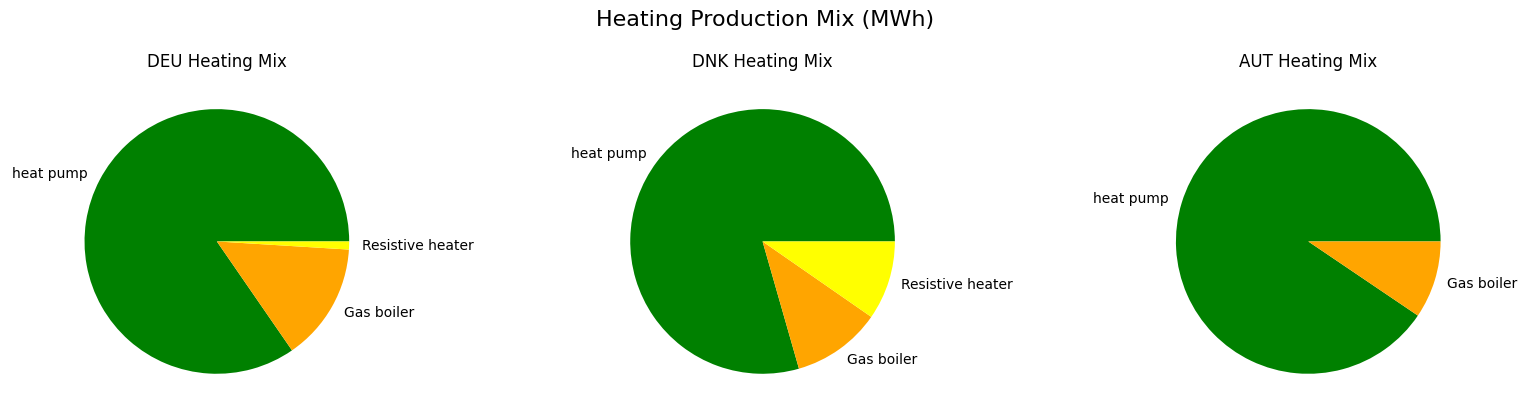

In [18]:
colors_heat = {
    'heat pump': 'green',
    'CHP (gas)': 'red',
    'H2 heater': 'pink',
    'Gas boiler': 'orange',
    'Resistive heater': 'yellow'
}

plt.figure(figsize=(16, 4))

for i, country in enumerate(countries):
    labels = []
    sizes = []

    # Heat pump output (electricity -> heat)
    hp = f'heat_pump_{country}'
    if hp in n.links.index:
        value = -n.links_t.p1[hp].sum()  # flip sign
        if value > 0.1:
            labels.append('heat pump')
            sizes.append(value)

    # CHP output (gas -> electricity + heat)
    chp = f'CHP_{country}'
    if chp in n.links.index:
        value = -n.links_t.p2[chp].sum()  # flip sign
        if value > 0.1:
            labels.append('CHP (gas)')
            sizes.append(value)

    # H2 heater output
    h2 = f'H2_heater_{country}'
    if h2 in n.links.index:
        value = -n.links_t.p1[h2].sum()  # flip sign
        if value > 0.1:
            labels.append('H2 heater')
            sizes.append(value)
    
    # Gas boiler output
    boiler = f'boiler_{country}'
    if boiler in n.links.index:
        value = -n.links_t.p1[boiler].sum()  # flip sign
        if value > 0.1:
            labels.append('Gas boiler')
            sizes.append(value)
    
    # Resistive heater output
    resistive = f'resistive_{country}'
    if resistive in n.links.index:
        value = -n.links_t.p1[resistive].sum()  # flip sign
        if value > 0.1:
            labels.append('Resistive heater')
            sizes.append(value)

    if sizes:
        colors = [colors_heat[label] for label in labels]
        plt.subplot(1, 3, i + 1)
        plt.pie(sizes, labels=labels, colors=colors, wedgeprops={'linewidth': 0})
        plt.axis('equal')
        plt.title(f"{country} Heating Mix", y=1.07)
    else:
        plt.subplot(1, 3, i + 1)
        plt.text(0.5, 0.5, 'No heating', ha='center', va='center')
        plt.axis('off')

plt.suptitle("Heating Production Mix (MWh)", fontsize=16)
plt.tight_layout()
plt.show()


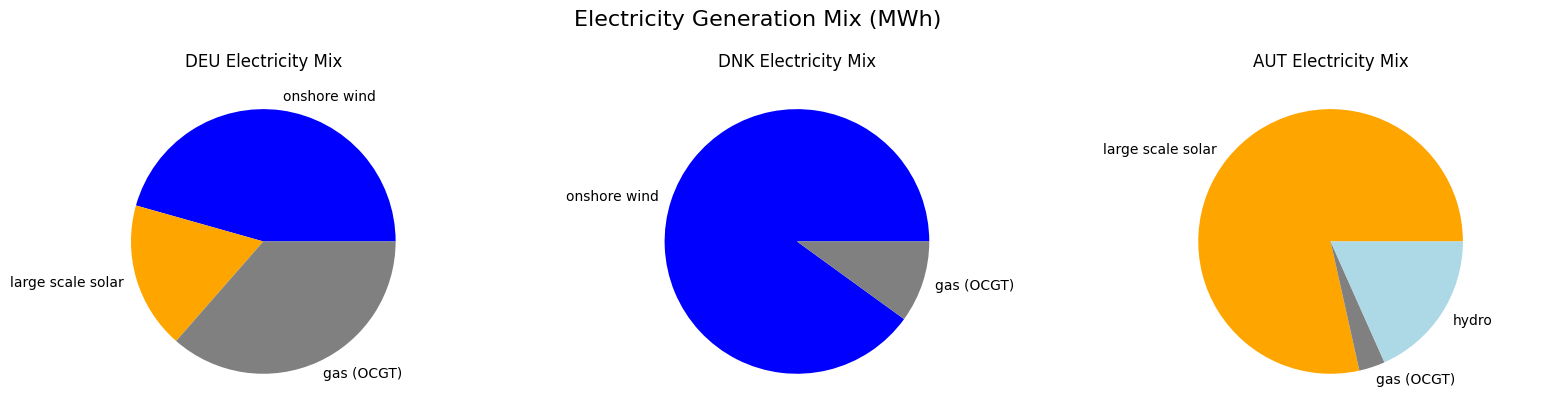

In [19]:
colors_gen = {
    'onshore wind': 'blue',
    'offshore wind': 'darkblue',
    'large scale solar': 'orange',
    'gas (OCGT)': 'grey',
    'coal': 'brown',
    'hydro': 'lightblue',
    'CHP (el)': 'red',
    'H2 fuel cell': 'pink'
}

plt.figure(figsize=(16, 4))

for i, country in enumerate(countries):
    labels = []
    sizes = []

    # Onshore wind
    if f'onshorewind{country}' in n.generators.index:
        value = n.generators_t.p[f'onshorewind{country}'].sum()
        if value > 0.1:
            labels.append('onshore wind')
            sizes.append(value)

    # Offshore wind
    if f'offshorewind{country}' in n.generators.index:
        value = n.generators_t.p[f'offshorewind{country}'].sum()
        if value > 0.1:
            labels.append('offshore wind')
            sizes.append(value)

    # PV
    if f'PV{country}' in n.generators.index:
        value = n.generators_t.p[f'PV{country}'].sum()
        if value > 0.1:
            labels.append('large scale solar')
            sizes.append(value)

    # OCGT
    if f'OCGT{country}' in n.generators.index:
        value = n.generators_t.p[f'OCGT{country}'].sum()
        if value > 0.1:
            labels.append('gas (OCGT)')
            sizes.append(value)

    # Coal
    if f'coal{country}' in n.generators.index:
        value = n.generators_t.p[f'coal{country}'].sum()
        if value > 0.1:
            labels.append('coal')
            sizes.append(value)

    # Hydro (storage unit dispatch)
    if f"hydro{country}" in n.storage_units.index:
        value = n.storage_units_t.p[f"hydro{country}"].sum()
        if value > 0.1:
            labels.append('hydro')
            sizes.append(value)
    
    # CHP output electricity
    chp = f'CHP_{country}'
    if chp in n.links.index:
        value = -n.links_t.p1[chp].sum()  # el output
        if value > 0.1:
            labels.append('CHP (el)')
            sizes.append(value)

    # H2 fuel cell output
    h2 = f'H2 Fuel Cell_{country}'
    if h2 in n.links.index:
        value = -n.links_t.p1[h2].sum()  # el output
        if value > 0.1:
            labels.append('H2 fuel cell')
            sizes.append(value)

    if sizes:
        colors = [colors_gen[label] for label in labels]
        plt.subplot(1, 3, i + 1)
        plt.pie(sizes, labels=labels, colors=colors, wedgeprops={'linewidth': 0})
        plt.axis('equal')
        plt.title(f"{country} Electricity Mix", y=1.07)
    else:
        plt.subplot(1, 3, i + 1)
        plt.text(0.5, 0.5, 'No generation', ha='center', va='center')
        plt.axis('off')

plt.suptitle("Electricity Generation Mix (MWh)", fontsize=16)
plt.tight_layout()
plt.show()


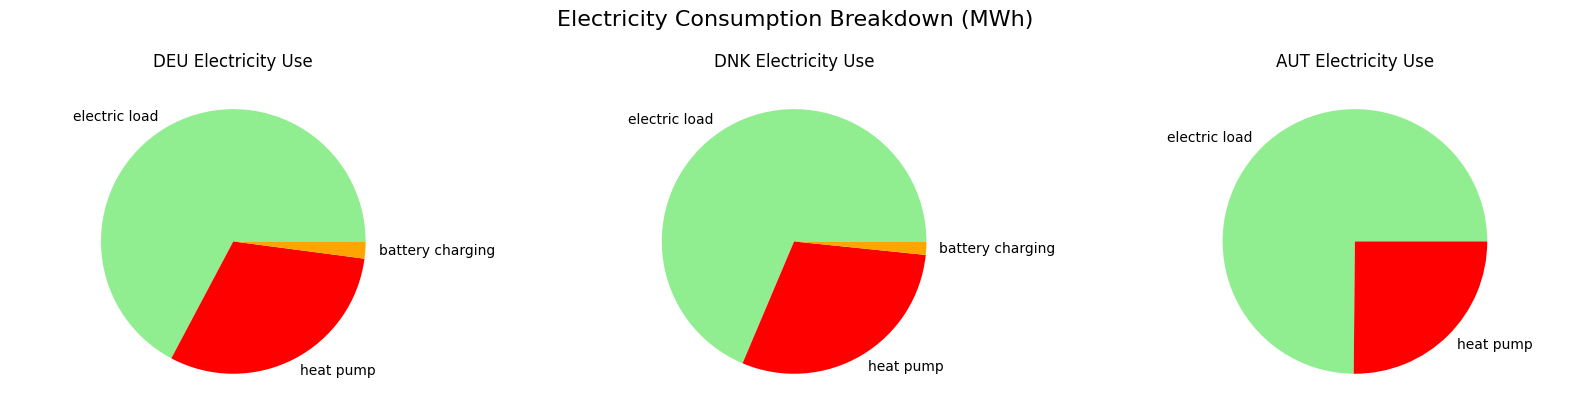

In [20]:
colors_con = {
    'electric load': 'lightgreen',
    'heat pump': 'red',
    'electrolyzer': 'blue',
    'battery charging': 'orange',
    'Resisitive heater': 'pink',
}

plt.figure(figsize=(16, 4))

for i, country in enumerate(countries):
    labels = []
    sizes = []

    # Load
    if f"load{country}" in n.loads_t.p.columns:
        val = n.loads_t.p[f"load{country}"].sum()
        if val > 0.1:
            labels.append("electric load")
            sizes.append(val)

    # Heat pump
    hp = f"heat_pump_{country}"
    if hp in n.links_t.p0.columns:
        val = n.links_t.p0[hp].sum()
        if val > 0.1:
            labels.append("heat pump")
            sizes.append(val)

    # Electrolyzer
    ely = f"electrolyzer_{country}"
    if ely in n.links_t.p0.columns:
        val = n.links_t.p0[ely].sum()
        if val > 0.1:
            labels.append("electrolyzer")
            sizes.append(val)

    # Battery charging
    bat = f"battery{country}"
    if bat in n.storage_units_t.p.columns:
        val = -n.storage_units_t.p[bat][n.storage_units_t.p[bat] < 0].sum()
        if val > 0.1:
            labels.append("battery charging")
            sizes.append(val)
    
    resistive = f'Resistive_{country}'
    if resistive in n.links_t.p0.columns:
        val = n.links_t.p0[resistive].sum()
        if val > 0.1:
            labels.append("Resistive heater")
            sizes.append(val)

    if sizes:
        colors = [colors_con[l] for l in labels]
        plt.subplot(1, 3, i + 1)
        plt.pie(sizes, labels=labels, colors=colors, wedgeprops={'linewidth': 0})
        plt.axis('equal')
        plt.title(f"{country} Electricity Use", y=1.07)
    else:
        plt.subplot(1, 3, i + 1)
        plt.text(0.5, 0.5, 'No data', ha='center', va='center')
        plt.axis('off')

plt.suptitle("Electricity Consumption Breakdown (MWh)", fontsize=16)
plt.tight_layout()
plt.show()


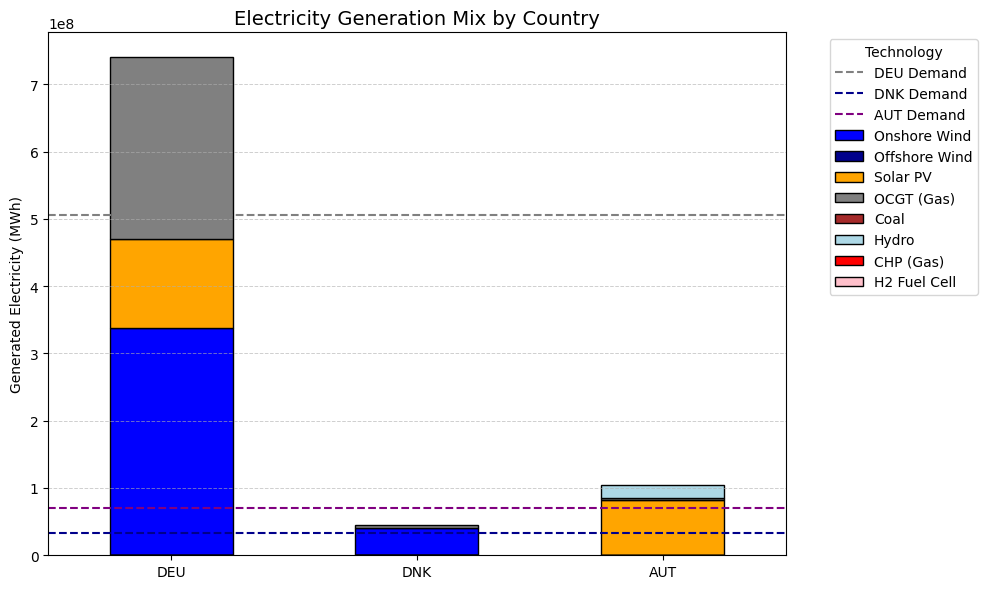

In [21]:
# Define the technologies and their labels/colors
tech_labels = {
    'onshorewind': 'Onshore Wind',
    'offshorewind': 'Offshore Wind',
    'PV': 'Solar PV',
    'OCGT': 'OCGT (Gas)',
    'coal': 'Coal',
    'hydro': 'Hydro',
    'CHP': 'CHP (Gas)',
    'H2 Fuel Cell': 'H2 Fuel Cell'
}

colors = {
    'Onshore Wind': 'blue',
    'Offshore Wind': 'darkblue',
    'Solar PV': 'orange',
    'OCGT (Gas)': 'grey',
    'Coal': 'brown',
    'Hydro': 'lightblue',
    'CHP (Gas)': 'red',
    'H2 Fuel Cell': 'pink'
}

# Initialize dataframe to collect generation by country and tech
df_gen = pd.DataFrame(0.0, index=tech_labels.values(), columns=countries)

for country in countries:
    for tech_key, tech_label in tech_labels.items():
        if tech_key == "hydro":
            unit_name = f"hydro{country}"
            if unit_name in n.storage_units.index:
                value = n.storage_units_t.p[unit_name].sum()
                df_gen.at[tech_label, country] = value

        elif tech_key == "CHP":
            unit_name = f"CHP_{country}"
            if unit_name in n.links.index:
                value = -n.links_t.p1[unit_name].sum()
                df_gen.at[tech_label, country] = value
        else:
            gen_name = f"{tech_key}{country}"
            if gen_name in n.generators.index:
                value = n.generators_t.p[gen_name].sum()
                df_gen.at[tech_label, country] = value

# Plot
ax = df_gen.T.plot(kind='bar', stacked=True, color=[colors[t] for t in df_gen.index],
                   figsize=(10, 6), edgecolor='black')

# Add a lineplot for electric demand 
el_demand = {"DEU":n.loads_t.p["loadDEU"].sum(),
            "DNK":n.loads_t.p["loadDNK"].sum(),
            "AUT":n.loads_t.p["loadAUT"].sum()}
#plt.plot(el_demand.keys(), el_demand.values(), color='black', label='Electricity Demand', linewidth=2, marker='o')

country_colors = {
    'DEU': 'grey',
    'DNK': 'darkblue',
    'AUT': 'purple'
}
for country, value in el_demand.items():
    # plot horizontal line for each country
    plt.axhline(y=value, linestyle='--', label=f'{country} Demand', color=country_colors[country])

plt.title("Electricity Generation Mix by Country", fontsize=14)
plt.ylabel("Generated Electricity (MWh)")
plt.xticks(rotation=0)
plt.legend(title="Technology", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)
plt.tight_layout()
plt.show()


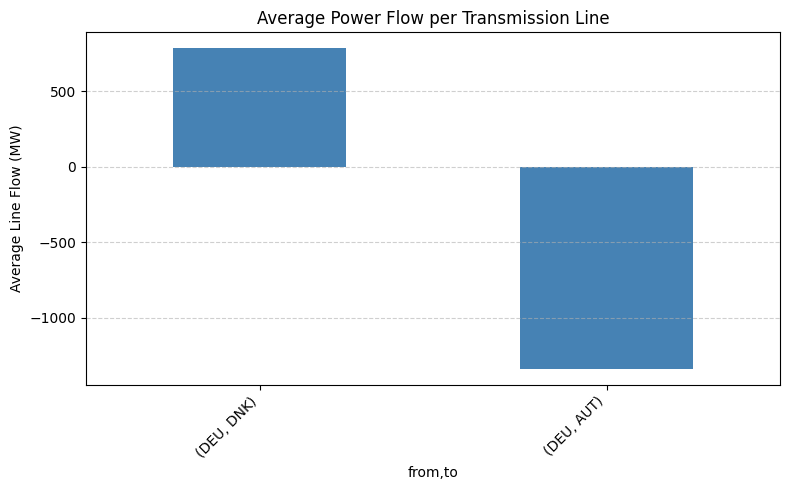

In [22]:
# Create a summary DataFrame
line_flows = pd.DataFrame(index=n.lines.index)
line_flows["from"] = n.lines.bus0
line_flows["to"] = n.lines.bus1
line_flows["average_flow_MW"] = n.lines_t.p0.mean()

# Plot as bar chart
plt.figure(figsize=(8, 5))
line_flows.set_index(["from", "to"])["average_flow_MW"].plot(kind='bar', color='steelblue')
plt.ylabel("Average Line Flow (MW)")
plt.title("Average Power Flow per Transmission Line")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

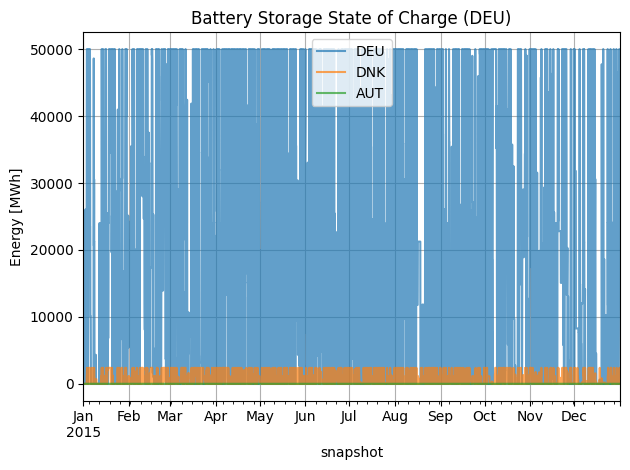

In [23]:
for country in countries:
    name = f"battery{country}"
    if name in n.storage_units_t.state_of_charge:
        n.storage_units_t.state_of_charge[name].plot(label=country, alpha=0.7)
plt.title("Battery Storage State of Charge (DEU)")
plt.ylabel("Energy [MWh]")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


Text(0, 0.5, 'Installed Capacity [MW]')

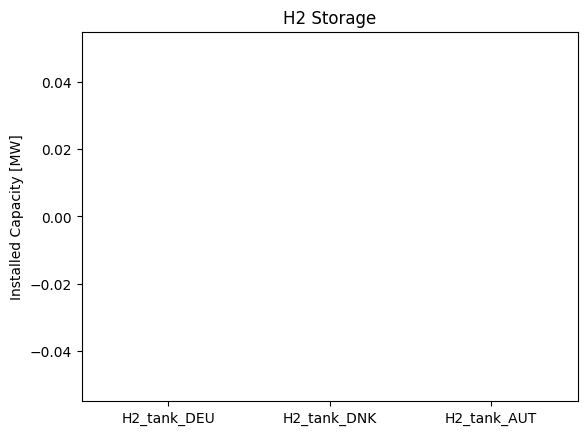

In [24]:
for country in countries:
    name = f"H2_tank_{country}"
    # bar plot of the state of charge
    plt.bar(name, 
            n.stores.e_nom_opt[name], label=country, alpha=0.7)
plt.title("H2 Storage")
plt.ylabel("Installed Capacity [MW]")


Text(0, 0.5, 'Consumption [MWh_el]')

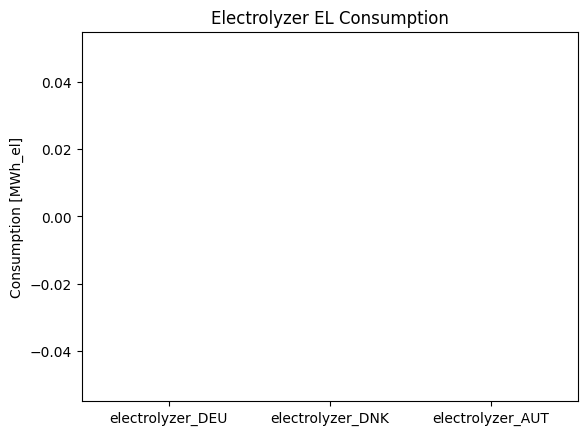

In [25]:
# Electrolyzer consumption in each country as a bar plot
for country in countries:
    name = f"electrolyzer_{country}"
    # bar plot of the state of charge
    plt.bar(name, 
            n.links_t.p0[name].sum(), label=country, alpha=0.7)
plt.title("Electrolyzer EL Consumption")
plt.ylabel("Consumption [MWh_el]")




__At which point does it become feasible for system to invest into hydrogen technologies?__

- Change in CO2 limit

In [26]:
co2_index = [163, 100, 50, 25, 10, 5, 0]  # in MtCO2
results = pd.DataFrame(index=co2_index)  # Initialize once

for co2 in co2_index:
    print(f"Optimizing for CO₂ limit: {co2} MtCO₂")

    # Set global CO₂ limit
    n.global_constraints.loc["CO2Limit", "constant"] = co2 * 1e6
    n.optimize(solver_name="gurobi")

    # System-level results
    results.loc[co2, "system_cost"] = n.objective / 1e6  # in million euros
    results.loc[co2, "co2_tax"] = -n.global_constraints.mu["CO2Limit"]

    for country in countries:
        # Electricity generation
        if country != 'AUT':
            results.loc[co2, f"onwind_{country}MWh"] = n.generators_t.p[f"onshorewind{country}"].sum()
            results.loc[co2, f"onwind_{country}MW"] = n.generators.p_nom_opt[f"onshorewind{country}"]

            results.loc[co2, f"offwind_{country}MWh"] = n.generators_t.p[f"offshorewind{country}"].sum()
            results.loc[co2, f"offwind_{country}MW"] = n.generators.p_nom_opt[f"offshorewind{country}"]

        results.loc[co2, f"pv_{country}MWh"] = n.generators_t.p[f"PV{country}"].sum()
        results.loc[co2, f"pv_{country}MW"] = n.generators.p_nom_opt[f"PV{country}"]

        if country == 'DEU':
            results.loc[co2, f"coal_{country}MWh"] = n.generators_t.p[f"coal{country}"].sum()
            results.loc[co2, f"coal_{country}MW"] = n.generators.p_nom_opt[f"coal{country}"]

        results.loc[co2, f"ocgt_{country}MWh"] = n.generators_t.p[f"OCGT{country}"].sum()
        results.loc[co2, f"ocgt_{country}MW"] = n.generators.p_nom_opt[f"OCGT{country}"]

        results.loc[co2, f"chp_el_{country}MWh"] = n.links_t.p1[f"CHP_{country}"].sum()
        results.loc[co2, f"chp_el_{country}MW"] = n.links.p_nom_opt[f"CHP_{country}"]

        results.loc[co2, f"h2_cell_{country}MWh"] = n.links_t.p1[f"H2 Fuel Cell_{country}"].sum()
        results.loc[co2, f"h2_cell_{country}MW"] = n.links.p_nom_opt[f"H2 Fuel Cell_{country}"]
        if country == 'AUT':
            results.loc[co2, f"hydro_{country}MWh"] = n.storage_units_t.p[f"hydro{country}"].sum()
            results.loc[co2, f"hydro_{country}MW"] = n.storage_units.p_nom_opt[f"hydro{country}"]

        # Heating generation
        results.loc[co2, f"heatpump_{country}MWh"] = -n.links_t.p1[f"heat_pump_{country}"].sum()
        results.loc[co2, f"heatpump_{country}MW"] = n.links.p_nom_opt[f"heat_pump_{country}"]

        results.loc[co2, f"chp_heat_{country}MWh"] = -n.links_t.p2[f"CHP_{country}"].sum()
        results.loc[co2, f"chp_heat_{country}MW"] = n.links.p_nom_opt[f"CHP_{country}"]

        results.loc[co2, f"boiler_{country}MWh"] = -n.links_t.p1[f"boiler_{country}"].sum()
        results.loc[co2, f"boiler_{country}MW"] = n.links.p_nom_opt[f"boiler_{country}"]

        results.loc[co2, f"resistive_{country}MWh"] = -n.links_t.p1[f"resistive_{country}"].sum()
        results.loc[co2, f"resistive_{country}MW"] = n.links.p_nom_opt[f"resistive_{country}"]

        results.loc[co2, f"h2_heater_{country}MWh"] = -n.links_t.p1[f"H2_heater_{country}"].sum()
        results.loc[co2, f"h2_heater_{country}MW"] = n.links.p_nom_opt[f"H2_heater_{country}"]

        # Electricity consumption
        results.loc[co2, f"electric_load_{country}MWh"] = n.loads_t.p[f"load{country}"].sum()

        bat = f"battery{country}"
        results.loc[co2, f"battery_{country}MWh"] = -n.storage_units_t.p[bat][n.storage_units_t.p[bat] < 0].sum()
        results.loc[co2, f"battery_{country}MW"] = n.storage_units.p_nom_opt[f"battery{country}"]

        results.loc[co2, f"electrolyzer_{country}MWh"] = n.links_t.p0[f"electrolyzer_{country}"].sum()
        results.loc[co2, f"electrolyzer_{country}MW"] = n.links.p_nom_opt[f"electrolyzer_{country}"]

        results.loc[co2, f"resistive_heater_{country}MWh"] = n.links_t.p0[f"resistive_{country}"].sum()
        results.loc[co2, f"resistive_heater_{country}MW"] = n.links.p_nom_opt[f"resistive_{country}"]

        # H2 storage
        results.loc[co2, f"h2_tank_{country}MWh"] = n.stores_t.e[f"H2_tank_{country}"].sum()
        results.loc[co2, f"h2_tank_{country}MW"] = n.stores.e_nom_opt[f"H2_tank_{country}"]

# Optional: save to CSV
results.to_csv("results_by_CO2_limit.csv")


Index(['0'], dtype='object', name='SubNetwork')
Index(['DEU-DNK', 'DEU-AUT'], dtype='object', name='Line')
Index(['heat_pump_DEU', 'CHP_DEU', 'boiler_DEU', 'resistive_DEU',
       'heat_pump_DNK', 'CHP_DNK', 'boiler_DNK', 'resistive_DNK',
       'heat_pump_AUT', 'CHP_AUT', 'boiler_AUT', 'resistive_AUT',
       'electrolyzer_DEU', 'H2_heater_DEU', 'electrolyzer_DNK',
       'H2_heater_DNK', 'electrolyzer_AUT', 'H2_heater_AUT'],
      dtype='object', name='Link')
Index(['DEU', 'DNK', 'AUT', 'DEU_heat', 'DNK_heat', 'AUT_heat'], dtype='object', name='Bus')


Optimizing for CO₂ limit: 163 MtCO₂


INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 13/13 [00:01<00:00, 11.60it/s]
INFO:linopy.io: Writing time: 8.22s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-94iy3t6x.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-94iy3t6x.lp


Reading time = 2.56 seconds


INFO:gurobipy:Reading time = 2.56 seconds


obj: 1051240 rows, 490599 columns, 2255944 nonzeros


INFO:gurobipy:obj: 1051240 rows, 490599 columns, 2255944 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 1051240 rows, 490599 columns and 2255944 nonzeros


INFO:gurobipy:Optimize a model with 1051240 rows, 490599 columns and 2255944 nonzeros


Model fingerprint: 0x33d96646


INFO:gurobipy:Model fingerprint: 0x33d96646


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+03]


INFO:gurobipy:  Matrix range     [1e-03, 2e+03]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [1e+03, 6e+03]


INFO:gurobipy:  Bounds range     [1e+03, 6e+03]


  RHS range        [1e+03, 1e+09]


INFO:gurobipy:  RHS range        [1e+03, 1e+09]


Presolve removed 529813 rows and 47974 columns


INFO:gurobipy:Presolve removed 529813 rows and 47974 columns


Presolve time: 1.57s


INFO:gurobipy:Presolve time: 1.57s


Presolved: 521427 rows, 442625 columns, 1678157 nonzeros


INFO:gurobipy:Presolved: 521427 rows, 442625 columns, 1678157 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.75s


INFO:gurobipy:Ordering time: 0.75s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 39


INFO:gurobipy: Dense cols : 39


 AA' NZ     : 1.490e+06


INFO:gurobipy: AA' NZ     : 1.490e+06


 Factor NZ  : 8.848e+06 (roughly 500 MB of memory)


INFO:gurobipy: Factor NZ  : 8.848e+06 (roughly 500 MB of memory)


 Factor Ops : 2.548e+08 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.548e+08 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.61289243e+13 -1.43984555e+15  7.41e+10 0.00e+00  2.38e+09     4s


INFO:gurobipy:   0   3.61289243e+13 -1.43984555e+15  7.41e+10 0.00e+00  2.38e+09     4s


   1   2.98110943e+13 -4.17245433e+14  1.69e+10 4.60e+01  6.85e+08     5s


INFO:gurobipy:   1   2.98110943e+13 -4.17245433e+14  1.69e+10 4.60e+01  6.85e+08     5s


   2   1.71036194e+13 -9.40820269e+13  4.05e+09 9.76e+00  1.62e+08     6s


INFO:gurobipy:   2   1.71036194e+13 -9.40820269e+13  4.05e+09 9.76e+00  1.62e+08     6s


   3   7.43350407e+12 -1.34912817e+13  7.24e+08 1.37e+00  2.75e+07     7s


INFO:gurobipy:   3   7.43350407e+12 -1.34912817e+13  7.24e+08 1.37e+00  2.75e+07     7s


   4   4.22093305e+12 -2.59514578e+12  3.50e+08 2.25e-01  8.50e+06     7s


INFO:gurobipy:   4   4.22093305e+12 -2.59514578e+12  3.50e+08 2.25e-01  8.50e+06     7s


   5   1.73585953e+12 -9.39058804e+11  1.28e+08 7.80e-02  3.11e+06     8s


INFO:gurobipy:   5   1.73585953e+12 -9.39058804e+11  1.28e+08 7.80e-02  3.11e+06     8s


   6   6.18389385e+11 -3.68366625e+11  3.85e+07 2.77e-02  1.07e+06     9s


INFO:gurobipy:   6   6.18389385e+11 -3.68366625e+11  3.85e+07 2.77e-02  1.07e+06     9s


   7   3.21247019e+11 -1.03653371e+11  1.68e+07 7.15e-03  4.42e+05     9s


INFO:gurobipy:   7   3.21247019e+11 -1.03653371e+11  1.68e+07 7.15e-03  4.42e+05     9s


   8   2.26337288e+11 -4.80383761e+10  1.05e+07 3.78e-03  2.80e+05    10s


INFO:gurobipy:   8   2.26337288e+11 -4.80383761e+10  1.05e+07 3.78e-03  2.80e+05    10s


   9   1.45386456e+11 -1.59609862e+10  5.21e+06 2.07e-03  1.62e+05    11s


INFO:gurobipy:   9   1.45386456e+11 -1.59609862e+10  5.21e+06 2.07e-03  1.62e+05    11s


  10   1.05847300e+11  9.00153702e+09  2.83e+06 9.60e-04  9.60e+04    12s


INFO:gurobipy:  10   1.05847300e+11  9.00153702e+09  2.83e+06 9.60e-04  9.60e+04    12s


  11   9.68861551e+10  3.07677479e+10  2.32e+06 2.10e-04  6.53e+04    13s


INFO:gurobipy:  11   9.68861551e+10  3.07677479e+10  2.32e+06 2.10e-04  6.53e+04    13s


  12   9.06642485e+10  3.44360111e+10  1.97e+06 8.21e-05  5.54e+04    13s


INFO:gurobipy:  12   9.06642485e+10  3.44360111e+10  1.97e+06 8.21e-05  5.54e+04    13s


  13   8.41939624e+10  3.73849419e+10  1.62e+06 1.64e-05  4.61e+04    14s


INFO:gurobipy:  13   8.41939624e+10  3.73849419e+10  1.62e+06 1.64e-05  4.61e+04    14s


  14   7.82038798e+10  4.03841918e+10  1.30e+06 2.04e-09  3.72e+04    15s


INFO:gurobipy:  14   7.82038798e+10  4.03841918e+10  1.30e+06 2.04e-09  3.72e+04    15s


  15   6.92159849e+10  4.46109774e+10  7.98e+05 2.74e-09  2.41e+04    16s


INFO:gurobipy:  15   6.92159849e+10  4.46109774e+10  7.98e+05 2.74e-09  2.41e+04    16s


  16   6.63841028e+10  4.75681380e+10  6.40e+05 1.73e-09  1.84e+04    17s


INFO:gurobipy:  16   6.63841028e+10  4.75681380e+10  6.40e+05 1.73e-09  1.84e+04    17s


  17   6.33960855e+10  4.91728694e+10  4.78e+05 8.37e-10  1.39e+04    18s


INFO:gurobipy:  17   6.33960855e+10  4.91728694e+10  4.78e+05 8.37e-10  1.39e+04    18s


  18   6.12269738e+10  5.08545163e+10  3.53e+05 2.16e-09  1.01e+04    19s


INFO:gurobipy:  18   6.12269738e+10  5.08545163e+10  3.53e+05 2.16e-09  1.01e+04    19s


  19   5.98621340e+10  5.19902522e+10  2.73e+05 6.56e-08  7.70e+03    20s


INFO:gurobipy:  19   5.98621340e+10  5.19902522e+10  2.73e+05 6.56e-08  7.70e+03    20s


  20   5.88506512e+10  5.30589063e+10  2.16e+05 1.60e-07  5.67e+03    21s


INFO:gurobipy:  20   5.88506512e+10  5.30589063e+10  2.16e+05 1.60e-07  5.67e+03    21s


  21   5.84066558e+10  5.33999068e+10  1.90e+05 2.32e-07  4.91e+03    22s


INFO:gurobipy:  21   5.84066558e+10  5.33999068e+10  1.90e+05 2.32e-07  4.91e+03    22s


  22   5.79735801e+10  5.35836545e+10  1.64e+05 2.87e-07  4.30e+03    23s


INFO:gurobipy:  22   5.79735801e+10  5.35836545e+10  1.64e+05 2.87e-07  4.30e+03    23s


  23   5.77943453e+10  5.38582285e+10  1.53e+05 3.40e-07  3.86e+03    24s


INFO:gurobipy:  23   5.77943453e+10  5.38582285e+10  1.53e+05 3.40e-07  3.86e+03    24s


  24   5.74930942e+10  5.39793795e+10  1.36e+05 3.77e-07  3.44e+03    25s


INFO:gurobipy:  24   5.74930942e+10  5.39793795e+10  1.36e+05 3.77e-07  3.44e+03    25s


  25   5.73383974e+10  5.40183060e+10  1.27e+05 3.90e-07  3.25e+03    26s


INFO:gurobipy:  25   5.73383974e+10  5.40183060e+10  1.27e+05 3.90e-07  3.25e+03    26s


  26   5.72400814e+10  5.40998611e+10  1.21e+05 4.30e-07  3.08e+03    26s


INFO:gurobipy:  26   5.72400814e+10  5.40998611e+10  1.21e+05 4.30e-07  3.08e+03    26s


  27   5.69569552e+10  5.42284527e+10  1.05e+05 4.72e-07  2.67e+03    27s


INFO:gurobipy:  27   5.69569552e+10  5.42284527e+10  1.05e+05 4.72e-07  2.67e+03    27s


  28   5.68801821e+10  5.42771136e+10  1.00e+05 4.52e-07  2.55e+03    28s


INFO:gurobipy:  28   5.68801821e+10  5.42771136e+10  1.00e+05 4.52e-07  2.55e+03    28s


  29   5.67702201e+10  5.43558798e+10  9.33e+04 4.68e-07  2.37e+03    29s


INFO:gurobipy:  29   5.67702201e+10  5.43558798e+10  9.33e+04 4.68e-07  2.37e+03    29s


  30   5.65688660e+10  5.44129400e+10  8.09e+04 4.52e-07  2.11e+03    30s


INFO:gurobipy:  30   5.65688660e+10  5.44129400e+10  8.09e+04 4.52e-07  2.11e+03    30s


  31   5.63718018e+10  5.45741202e+10  6.88e+04 3.94e-07  1.76e+03    31s


INFO:gurobipy:  31   5.63718018e+10  5.45741202e+10  6.88e+04 3.94e-07  1.76e+03    31s


  32   5.63149403e+10  5.46366660e+10  6.53e+04 3.88e-07  1.65e+03    32s


INFO:gurobipy:  32   5.63149403e+10  5.46366660e+10  6.53e+04 3.88e-07  1.65e+03    32s


  33   5.61704175e+10  5.47032084e+10  5.55e+04 3.32e-07  1.44e+03    33s


INFO:gurobipy:  33   5.61704175e+10  5.47032084e+10  5.55e+04 3.32e-07  1.44e+03    33s


  34   5.61517316e+10  5.48115025e+10  5.44e+04 3.11e-07  1.31e+03    34s


INFO:gurobipy:  34   5.61517316e+10  5.48115025e+10  5.44e+04 3.11e-07  1.31e+03    34s


  35   5.60110967e+10  5.48701051e+10  4.53e+04 3.17e-07  1.12e+03    35s


INFO:gurobipy:  35   5.60110967e+10  5.48701051e+10  4.53e+04 3.17e-07  1.12e+03    35s


  36   5.59333266e+10  5.49197430e+10  4.06e+04 3.14e-07  9.94e+02    36s


INFO:gurobipy:  36   5.59333266e+10  5.49197430e+10  4.06e+04 3.14e-07  9.94e+02    36s


  37   5.58877555e+10  5.49618593e+10  3.76e+04 3.06e-07  9.08e+02    37s


INFO:gurobipy:  37   5.58877555e+10  5.49618593e+10  3.76e+04 3.06e-07  9.08e+02    37s


  38   5.57923981e+10  5.50435307e+10  3.15e+04 2.61e-07  7.35e+02    38s


INFO:gurobipy:  38   5.57923981e+10  5.50435307e+10  3.15e+04 2.61e-07  7.35e+02    38s


  39   5.57027146e+10  5.51170540e+10  2.60e+04 2.67e-07  5.76e+02    40s


INFO:gurobipy:  39   5.57027146e+10  5.51170540e+10  2.60e+04 2.67e-07  5.76e+02    40s


  40   5.56174706e+10  5.51397819e+10  2.08e+04 2.56e-07  4.69e+02    41s


INFO:gurobipy:  40   5.56174706e+10  5.51397819e+10  2.08e+04 2.56e-07  4.69e+02    41s


  41   5.55644168e+10  5.51610855e+10  1.76e+04 2.38e-07  3.96e+02    42s


INFO:gurobipy:  41   5.55644168e+10  5.51610855e+10  1.76e+04 2.38e-07  3.96e+02    42s


  42   5.55403274e+10  5.51759720e+10  1.61e+04 2.33e-07  3.58e+02    43s


INFO:gurobipy:  42   5.55403274e+10  5.51759720e+10  1.61e+04 2.33e-07  3.58e+02    43s


  43   5.55339165e+10  5.51841031e+10  1.57e+04 2.22e-07  3.44e+02    44s


INFO:gurobipy:  43   5.55339165e+10  5.51841031e+10  1.57e+04 2.22e-07  3.44e+02    44s


  44   5.54839621e+10  5.52055054e+10  1.24e+04 1.87e-07  2.74e+02    45s


INFO:gurobipy:  44   5.54839621e+10  5.52055054e+10  1.24e+04 1.87e-07  2.74e+02    45s


  45   5.54564383e+10  5.52184080e+10  1.05e+04 1.68e-07  2.34e+02    46s


INFO:gurobipy:  45   5.54564383e+10  5.52184080e+10  1.05e+04 1.68e-07  2.34e+02    46s


  46   5.54385731e+10  5.52272248e+10  9.29e+03 1.54e-07  2.08e+02    47s


INFO:gurobipy:  46   5.54385731e+10  5.52272248e+10  9.29e+03 1.54e-07  2.08e+02    47s


  47   5.54128128e+10  5.52400676e+10  7.54e+03 1.29e-07  1.70e+02    48s


INFO:gurobipy:  47   5.54128128e+10  5.52400676e+10  7.54e+03 1.29e-07  1.70e+02    48s


  48   5.53963405e+10  5.52430054e+10  6.45e+03 1.21e-07  1.51e+02    49s


INFO:gurobipy:  48   5.53963405e+10  5.52430054e+10  6.45e+03 1.21e-07  1.51e+02    49s


  49   5.53868624e+10  5.52547499e+10  5.81e+03 1.04e-07  1.30e+02    49s


INFO:gurobipy:  49   5.53868624e+10  5.52547499e+10  5.81e+03 1.04e-07  1.30e+02    49s


  50   5.53737193e+10  5.52574033e+10  4.95e+03 1.24e-07  1.14e+02    50s


INFO:gurobipy:  50   5.53737193e+10  5.52574033e+10  4.95e+03 1.24e-07  1.14e+02    50s


  51   5.53687234e+10  5.52591143e+10  4.63e+03 1.25e-07  1.08e+02    51s


INFO:gurobipy:  51   5.53687234e+10  5.52591143e+10  4.63e+03 1.25e-07  1.08e+02    51s


  52   5.53590661e+10  5.52685351e+10  4.01e+03 2.41e-07  8.90e+01    52s


INFO:gurobipy:  52   5.53590661e+10  5.52685351e+10  4.01e+03 2.41e-07  8.90e+01    52s


  53   5.53514657e+10  5.52717645e+10  3.51e+03 2.59e-07  7.83e+01    53s


INFO:gurobipy:  53   5.53514657e+10  5.52717645e+10  3.51e+03 2.59e-07  7.83e+01    53s


  54   5.53400792e+10  5.52733069e+10  2.78e+03 2.56e-07  6.55e+01    54s


INFO:gurobipy:  54   5.53400792e+10  5.52733069e+10  2.78e+03 2.56e-07  6.55e+01    54s


  55   5.53372300e+10  5.52746882e+10  2.60e+03 2.77e-07  6.14e+01    55s


INFO:gurobipy:  55   5.53372300e+10  5.52746882e+10  2.60e+03 2.77e-07  6.14e+01    55s


  56   5.53369546e+10  5.52766885e+10  2.58e+03 2.74e-07  5.92e+01    56s


INFO:gurobipy:  56   5.53369546e+10  5.52766885e+10  2.58e+03 2.74e-07  5.92e+01    56s


  57   5.53303565e+10  5.52794094e+10  2.16e+03 2.81e-07  5.00e+01    56s


INFO:gurobipy:  57   5.53303565e+10  5.52794094e+10  2.16e+03 2.81e-07  5.00e+01    56s


  58   5.53252918e+10  5.52813178e+10  1.83e+03 2.58e-07  4.32e+01    57s


INFO:gurobipy:  58   5.53252918e+10  5.52813178e+10  1.83e+03 2.58e-07  4.32e+01    57s


  59   5.53205805e+10  5.52843323e+10  1.53e+03 1.88e-07  3.56e+01    58s


INFO:gurobipy:  59   5.53205805e+10  5.52843323e+10  1.53e+03 1.88e-07  3.56e+01    58s


  60   5.53175356e+10  5.52868151e+10  1.33e+03 1.44e-07  3.02e+01    59s


INFO:gurobipy:  60   5.53175356e+10  5.52868151e+10  1.33e+03 1.44e-07  3.02e+01    59s


  61   5.53142033e+10  5.52886201e+10  1.12e+03 1.05e-07  2.51e+01    60s


INFO:gurobipy:  61   5.53142033e+10  5.52886201e+10  1.12e+03 1.05e-07  2.51e+01    60s


  62   5.53126992e+10  5.52890465e+10  1.03e+03 9.96e-08  2.32e+01    61s


INFO:gurobipy:  62   5.53126992e+10  5.52890465e+10  1.03e+03 9.96e-08  2.32e+01    61s


  63   5.53089820e+10  5.52910497e+10  7.88e+02 7.12e-08  1.76e+01    62s


INFO:gurobipy:  63   5.53089820e+10  5.52910497e+10  7.88e+02 7.12e-08  1.76e+01    62s


  64   5.53081810e+10  5.52919686e+10  7.38e+02 2.53e-08  1.59e+01    63s


INFO:gurobipy:  64   5.53081810e+10  5.52919686e+10  7.38e+02 2.53e-08  1.59e+01    63s


  65   5.53044118e+10  5.52927922e+10  5.06e+02 2.05e-08  1.14e+01    64s


INFO:gurobipy:  65   5.53044118e+10  5.52927922e+10  5.06e+02 2.05e-08  1.14e+01    64s


  66   5.53028858e+10  5.52934695e+10  4.09e+02 2.48e-08  9.25e+00    65s


INFO:gurobipy:  66   5.53028858e+10  5.52934695e+10  4.09e+02 2.48e-08  9.25e+00    65s


  67   5.53023888e+10  5.52935852e+10  3.78e+02 1.65e-08  8.65e+00    66s


INFO:gurobipy:  67   5.53023888e+10  5.52935852e+10  3.78e+02 1.65e-08  8.65e+00    66s


  68   5.53015515e+10  5.52939614e+10  3.24e+02 1.41e-08  7.45e+00    67s


INFO:gurobipy:  68   5.53015515e+10  5.52939614e+10  3.24e+02 1.41e-08  7.45e+00    67s


  69   5.53006085e+10  5.52943603e+10  2.66e+02 1.19e-08  6.14e+00    68s


INFO:gurobipy:  69   5.53006085e+10  5.52943603e+10  2.66e+02 1.19e-08  6.14e+00    68s


  70   5.52991600e+10  5.52949551e+10  1.74e+02 8.48e-09  4.13e+00    69s


INFO:gurobipy:  70   5.52991600e+10  5.52949551e+10  1.74e+02 8.48e-09  4.13e+00    69s


  71   5.52986798e+10  5.52953742e+10  1.45e+02 3.72e-08  3.25e+00    70s


INFO:gurobipy:  71   5.52986798e+10  5.52953742e+10  1.45e+02 3.72e-08  3.25e+00    70s


  72   5.52983259e+10  5.52955182e+10  1.23e+02 4.52e-08  2.76e+00    71s


INFO:gurobipy:  72   5.52983259e+10  5.52955182e+10  1.23e+02 4.52e-08  2.76e+00    71s


  73   5.52977835e+10  5.52960649e+10  8.88e+01 6.50e-08  1.70e+00    72s


INFO:gurobipy:  73   5.52977835e+10  5.52960649e+10  8.88e+01 6.50e-08  1.70e+00    72s


  74   5.52973480e+10  5.52961332e+10  6.22e+01 5.48e-08  1.20e+00    73s


INFO:gurobipy:  74   5.52973480e+10  5.52961332e+10  6.22e+01 5.48e-08  1.20e+00    73s


  75   5.52972647e+10  5.52961535e+10  5.75e+01 5.12e-08  1.10e+00    73s


INFO:gurobipy:  75   5.52972647e+10  5.52961535e+10  5.75e+01 5.12e-08  1.10e+00    73s


  76   5.52971718e+10  5.52961743e+10  5.19e+01 4.67e-08  9.84e-01    74s


INFO:gurobipy:  76   5.52971718e+10  5.52961743e+10  5.19e+01 4.67e-08  9.84e-01    74s


  77   5.52969828e+10  5.52962086e+10  4.00e+01 3.92e-08  7.64e-01    75s


INFO:gurobipy:  77   5.52969828e+10  5.52962086e+10  4.00e+01 3.92e-08  7.64e-01    75s


  78   5.52966476e+10  5.52963063e+10  1.86e+01 1.83e-07  3.37e-01    75s


INFO:gurobipy:  78   5.52966476e+10  5.52963063e+10  1.86e+01 1.83e-07  3.37e-01    75s


  79   5.52964825e+10  5.52963112e+10  8.23e+00 1.56e-07  1.69e-01    76s


INFO:gurobipy:  79   5.52964825e+10  5.52963112e+10  8.23e+00 1.56e-07  1.69e-01    76s


  80   5.52964696e+10  5.52963160e+10  7.43e+00 1.45e-07  1.51e-01    77s


INFO:gurobipy:  80   5.52964696e+10  5.52963160e+10  7.43e+00 1.45e-07  1.51e-01    77s


  81   5.52963487e+10  5.52963405e+10  2.04e-01 4.77e-09  7.92e-03    77s


INFO:gurobipy:  81   5.52963487e+10  5.52963405e+10  2.04e-01 4.77e-09  7.92e-03    77s


  82   5.52963442e+10  5.52963435e+10  5.35e-03 1.04e-07  6.45e-04    78s


INFO:gurobipy:  82   5.52963442e+10  5.52963435e+10  5.35e-03 1.04e-07  6.45e-04    78s


  83   5.52963441e+10  5.52963441e+10  6.01e-04 2.06e-08  1.52e-05    78s


INFO:gurobipy:  83   5.52963441e+10  5.52963441e+10  6.01e-04 2.06e-08  1.52e-05    78s


  84   5.52963441e+10  5.52963441e+10  1.28e-04 2.75e-09  2.19e-06    79s


INFO:gurobipy:  84   5.52963441e+10  5.52963441e+10  1.28e-04 2.75e-09  2.19e-06    79s


  85   5.52963441e+10  5.52963441e+10  5.63e-08 3.24e-09  5.16e-09    80s


INFO:gurobipy:  85   5.52963441e+10  5.52963441e+10  5.63e-08 3.24e-09  5.16e-09    80s


INFO:gurobipy:


Barrier solved model in 85 iterations and 79.55 seconds (24.63 work units)


INFO:gurobipy:Barrier solved model in 85 iterations and 79.55 seconds (24.63 work units)


Optimal objective 5.52963441e+10


INFO:gurobipy:Optimal objective 5.52963441e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


  233982 DPushes remaining with DInf 0.0000000e+00                80s


INFO:gurobipy:  233982 DPushes remaining with DInf 0.0000000e+00                80s


       0 DPushes remaining with DInf 0.0000000e+00                82s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                82s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


   43013 PPushes remaining with PInf 0.0000000e+00                83s


INFO:gurobipy:   43013 PPushes remaining with PInf 0.0000000e+00                83s


   23404 PPushes remaining with PInf 0.0000000e+00                85s


INFO:gurobipy:   23404 PPushes remaining with PInf 0.0000000e+00                85s


   17465 PPushes remaining with PInf 0.0000000e+00                90s


INFO:gurobipy:   17465 PPushes remaining with PInf 0.0000000e+00                90s


   12965 PPushes remaining with PInf 0.0000000e+00                95s


INFO:gurobipy:   12965 PPushes remaining with PInf 0.0000000e+00                95s


    7823 PPushes remaining with PInf 0.0000000e+00               100s


INFO:gurobipy:    7823 PPushes remaining with PInf 0.0000000e+00               100s


    2638 PPushes remaining with PInf 0.0000000e+00               105s


INFO:gurobipy:    2638 PPushes remaining with PInf 0.0000000e+00               105s


       0 PPushes remaining with PInf 0.0000000e+00               108s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00               108s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 4.6760440e-09    108s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 4.6760440e-09    108s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 2


INFO:gurobipy:Extra simplex iterations after uncrush: 2


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  128241    5.5296344e+10   0.000000e+00   0.000000e+00    110s


INFO:gurobipy:  128241    5.5296344e+10   0.000000e+00   0.000000e+00    110s


INFO:gurobipy:


Solved in 128241 iterations and 109.76 seconds (56.25 work units)


INFO:gurobipy:Solved in 128241 iterations and 109.76 seconds (56.25 work units)


Optimal objective  5.529634409e+10


INFO:gurobipy:Optimal objective  5.529634409e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 490599 primals, 1051240 duals
Objective: 5.53e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Line-fix-s-lower, Line-fix-s-upper, Link-ext-p-lower, Link-ext-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
Index(['0'], dtype='object', name='SubNetwork')
Index(['DEU-DNK', 'DEU-AUT'], dtype='object', name='Line')
Index(['heat_pump_DEU', 'CHP_DEU', 'boiler_DEU', 

Optimizing for CO₂ limit: 100 MtCO₂


INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 13/13 [00:01<00:00, 11.55it/s]
INFO:linopy.io: Writing time: 8.26s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-q1x2b84p.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-q1x2b84p.lp


Reading time = 2.57 seconds


INFO:gurobipy:Reading time = 2.57 seconds


obj: 1051240 rows, 490599 columns, 2255944 nonzeros


INFO:gurobipy:obj: 1051240 rows, 490599 columns, 2255944 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 1051240 rows, 490599 columns and 2255944 nonzeros


INFO:gurobipy:Optimize a model with 1051240 rows, 490599 columns and 2255944 nonzeros


Model fingerprint: 0xc3ca009b


INFO:gurobipy:Model fingerprint: 0xc3ca009b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+03]


INFO:gurobipy:  Matrix range     [1e-03, 2e+03]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [1e+03, 6e+03]


INFO:gurobipy:  Bounds range     [1e+03, 6e+03]


  RHS range        [1e+03, 1e+09]


INFO:gurobipy:  RHS range        [1e+03, 1e+09]


Presolve removed 529813 rows and 47974 columns


INFO:gurobipy:Presolve removed 529813 rows and 47974 columns


Presolve time: 1.57s


INFO:gurobipy:Presolve time: 1.57s


Presolved: 521427 rows, 442625 columns, 1678157 nonzeros


INFO:gurobipy:Presolved: 521427 rows, 442625 columns, 1678157 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.71s


INFO:gurobipy:Ordering time: 0.71s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 39


INFO:gurobipy: Dense cols : 39


 AA' NZ     : 1.490e+06


INFO:gurobipy: AA' NZ     : 1.490e+06


 Factor NZ  : 8.848e+06 (roughly 500 MB of memory)


INFO:gurobipy: Factor NZ  : 8.848e+06 (roughly 500 MB of memory)


 Factor Ops : 2.548e+08 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.548e+08 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.19853313e+13 -1.61143809e+15  6.55e+10 0.00e+00  2.54e+09     4s


INFO:gurobipy:   0   3.19853313e+13 -1.61143809e+15  6.55e+10 0.00e+00  2.54e+09     4s


   1   2.75166145e+13 -5.21775525e+14  1.51e+10 5.78e+01  8.05e+08     4s


INFO:gurobipy:   1   2.75166145e+13 -5.21775525e+14  1.51e+10 5.78e+01  8.05e+08     4s


   2   1.64537952e+13 -1.14453068e+14  3.36e+09 1.23e+01  1.83e+08     5s


INFO:gurobipy:   2   1.64537952e+13 -1.14453068e+14  3.36e+09 1.23e+01  1.83e+08     5s


   3   7.56706303e+12 -1.75607971e+13  6.23e+08 1.81e+00  3.23e+07     6s


INFO:gurobipy:   3   7.56706303e+12 -1.75607971e+13  6.23e+08 1.81e+00  3.23e+07     6s


   4   4.02636495e+12 -5.81079802e+12  2.51e+08 5.77e-01  1.18e+07     7s


INFO:gurobipy:   4   4.02636495e+12 -5.81079802e+12  2.51e+08 5.77e-01  1.18e+07     7s


   5   2.59282834e+12 -1.87020813e+12  1.46e+08 1.57e-01  5.13e+06     8s


INFO:gurobipy:   5   2.59282834e+12 -1.87020813e+12  1.46e+08 1.57e-01  5.13e+06     8s


   6   1.34353278e+12 -7.28191128e+11  6.77e+07 4.62e-02  2.27e+06     8s


INFO:gurobipy:   6   1.34353278e+12 -7.28191128e+11  6.77e+07 4.62e-02  2.27e+06     8s


   7   4.41682237e+11 -2.24909335e+11  1.84e+07 1.59e-02  6.91e+05     9s


INFO:gurobipy:   7   4.41682237e+11 -2.24909335e+11  1.84e+07 1.59e-02  6.91e+05     9s


   8   3.18612885e+11 -1.32848054e+11  1.20e+07 1.04e-02  4.61e+05    10s


INFO:gurobipy:   8   3.18612885e+11 -1.32848054e+11  1.20e+07 1.04e-02  4.61e+05    10s


   9   2.03896406e+11 -5.44328338e+10  6.47e+06 5.18e-03  2.59e+05    10s


INFO:gurobipy:   9   2.03896406e+11 -5.44328338e+10  6.47e+06 5.18e-03  2.59e+05    10s


  10   1.49609531e+11 -8.63964713e+09  3.96e+06 2.63e-03  1.57e+05    11s


INFO:gurobipy:  10   1.49609531e+11 -8.63964713e+09  3.96e+06 2.63e-03  1.57e+05    11s


  11   1.12904364e+11  1.44486330e+10  2.32e+06 1.34e-03  9.69e+04    12s


INFO:gurobipy:  11   1.12904364e+11  1.44486330e+10  2.32e+06 1.34e-03  9.69e+04    12s


  12   1.06017692e+11  2.78675269e+10  2.03e+06 6.84e-04  7.68e+04    13s


INFO:gurobipy:  12   1.06017692e+11  2.78675269e+10  2.03e+06 6.84e-04  7.68e+04    13s


  13   9.13924838e+10  3.61382447e+10  1.38e+06 3.23e-04  5.42e+04    13s


INFO:gurobipy:  13   9.13924838e+10  3.61382447e+10  1.38e+06 3.23e-04  5.42e+04    13s


  14   8.71595752e+10  3.85971374e+10  1.19e+06 2.37e-04  4.76e+04    14s


INFO:gurobipy:  14   8.71595752e+10  3.85971374e+10  1.19e+06 2.37e-04  4.76e+04    14s


  15   8.02183955e+10  4.52502655e+10  8.80e+05 6.41e-05  3.42e+04    15s


INFO:gurobipy:  15   8.02183955e+10  4.52502655e+10  8.80e+05 6.41e-05  3.42e+04    15s


  16   7.30701804e+10  5.03721967e+10  5.63e+05 1.00e-09  2.22e+04    16s


INFO:gurobipy:  16   7.30701804e+10  5.03721967e+10  5.63e+05 1.00e-09  2.22e+04    16s


  17   7.04632980e+10  5.41279356e+10  4.44e+05 6.56e-10  1.60e+04    17s


INFO:gurobipy:  17   7.04632980e+10  5.41279356e+10  4.44e+05 6.56e-10  1.60e+04    17s


  18   6.71557367e+10  5.61368228e+10  2.96e+05 9.00e-10  1.08e+04    18s


INFO:gurobipy:  18   6.71557367e+10  5.61368228e+10  2.96e+05 9.00e-10  1.08e+04    18s


  19   6.57045375e+10  5.74587851e+10  2.27e+05 1.27e-07  8.06e+03    19s


INFO:gurobipy:  19   6.57045375e+10  5.74587851e+10  2.27e+05 1.27e-07  8.06e+03    19s


  20   6.55104327e+10  5.77042692e+10  2.17e+05 1.95e-07  7.63e+03    20s


INFO:gurobipy:  20   6.55104327e+10  5.77042692e+10  2.17e+05 1.95e-07  7.63e+03    20s


  21   6.46599665e+10  5.83829546e+10  1.76e+05 3.53e-07  6.14e+03    21s


INFO:gurobipy:  21   6.46599665e+10  5.83829546e+10  1.76e+05 3.53e-07  6.14e+03    21s


  22   6.40262525e+10  5.89114380e+10  1.45e+05 5.13e-07  5.00e+03    22s


INFO:gurobipy:  22   6.40262525e+10  5.89114380e+10  1.45e+05 5.13e-07  5.00e+03    22s


  23   6.37119861e+10  5.89694856e+10  1.29e+05 5.28e-07  4.63e+03    23s


INFO:gurobipy:  23   6.37119861e+10  5.89694856e+10  1.29e+05 5.28e-07  4.63e+03    23s


  24   6.35247912e+10  5.91597394e+10  1.20e+05 5.65e-07  4.27e+03    24s


INFO:gurobipy:  24   6.35247912e+10  5.91597394e+10  1.20e+05 5.65e-07  4.27e+03    24s


  25   6.31538521e+10  5.93260094e+10  1.02e+05 5.92e-07  3.74e+03    25s


INFO:gurobipy:  25   6.31538521e+10  5.93260094e+10  1.02e+05 5.92e-07  3.74e+03    25s


  26   6.29660392e+10  5.94665337e+10  9.26e+04 6.02e-07  3.42e+03    26s


INFO:gurobipy:  26   6.29660392e+10  5.94665337e+10  9.26e+04 6.02e-07  3.42e+03    26s


  27   6.25945646e+10  5.96172588e+10  7.30e+04 5.80e-07  2.90e+03    27s


INFO:gurobipy:  27   6.25945646e+10  5.96172588e+10  7.30e+04 5.80e-07  2.90e+03    27s


  28   6.23789930e+10  5.97293654e+10  6.16e+04 5.65e-07  2.58e+03    28s


INFO:gurobipy:  28   6.23789930e+10  5.97293654e+10  6.16e+04 5.65e-07  2.58e+03    28s


  29   6.22626285e+10  5.99074713e+10  5.58e+04 5.31e-07  2.30e+03    29s


INFO:gurobipy:  29   6.22626285e+10  5.99074713e+10  5.58e+04 5.31e-07  2.30e+03    29s


  30   6.21322507e+10  6.00801004e+10  4.88e+04 4.49e-07  2.00e+03    30s


INFO:gurobipy:  30   6.21322507e+10  6.00801004e+10  4.88e+04 4.49e-07  2.00e+03    30s


  31   6.19358004e+10  6.02671871e+10  3.83e+04 3.87e-07  1.63e+03    31s


INFO:gurobipy:  31   6.19358004e+10  6.02671871e+10  3.83e+04 3.87e-07  1.63e+03    31s


  32   6.18251847e+10  6.05051917e+10  3.26e+04 3.04e-07  1.29e+03    32s


INFO:gurobipy:  32   6.18251847e+10  6.05051917e+10  3.26e+04 3.04e-07  1.29e+03    32s


  33   6.16958801e+10  6.06029048e+10  2.62e+04 2.83e-07  1.07e+03    33s


INFO:gurobipy:  33   6.16958801e+10  6.06029048e+10  2.62e+04 2.83e-07  1.07e+03    33s


  34   6.16618701e+10  6.06779988e+10  2.45e+04 2.76e-07  9.60e+02    34s


INFO:gurobipy:  34   6.16618701e+10  6.06779988e+10  2.45e+04 2.76e-07  9.60e+02    34s


  35   6.15993922e+10  6.07631002e+10  2.13e+04 2.80e-07  8.16e+02    35s


INFO:gurobipy:  35   6.15993922e+10  6.07631002e+10  2.13e+04 2.80e-07  8.16e+02    35s


  36   6.15552281e+10  6.08039592e+10  1.91e+04 2.86e-07  7.33e+02    35s


INFO:gurobipy:  36   6.15552281e+10  6.08039592e+10  1.91e+04 2.86e-07  7.33e+02    35s


  37   6.14824729e+10  6.08410350e+10  1.54e+04 2.54e-07  6.26e+02    36s


INFO:gurobipy:  37   6.14824729e+10  6.08410350e+10  1.54e+04 2.54e-07  6.26e+02    36s


  38   6.14470688e+10  6.09160400e+10  1.36e+04 2.51e-07  5.18e+02    37s


INFO:gurobipy:  38   6.14470688e+10  6.09160400e+10  1.36e+04 2.51e-07  5.18e+02    37s


  39   6.14125557e+10  6.09342778e+10  1.19e+04 2.47e-07  4.67e+02    38s


INFO:gurobipy:  39   6.14125557e+10  6.09342778e+10  1.19e+04 2.47e-07  4.67e+02    38s


  40   6.13908587e+10  6.09748140e+10  1.09e+04 2.28e-07  4.06e+02    39s


INFO:gurobipy:  40   6.13908587e+10  6.09748140e+10  1.09e+04 2.28e-07  4.06e+02    39s


  41   6.13814771e+10  6.09997425e+10  1.04e+04 2.14e-07  3.73e+02    40s


INFO:gurobipy:  41   6.13814771e+10  6.09997425e+10  1.04e+04 2.14e-07  3.73e+02    40s


  42   6.13472707e+10  6.10214417e+10  8.55e+03 1.94e-07  3.18e+02    41s


INFO:gurobipy:  42   6.13472707e+10  6.10214417e+10  8.55e+03 1.94e-07  3.18e+02    41s


  43   6.13321407e+10  6.10368678e+10  7.74e+03 1.87e-07  2.88e+02    42s


INFO:gurobipy:  43   6.13321407e+10  6.10368678e+10  7.74e+03 1.87e-07  2.88e+02    42s


  44   6.13175635e+10  6.10666433e+10  6.99e+03 1.79e-07  2.45e+02    43s


INFO:gurobipy:  44   6.13175635e+10  6.10666433e+10  6.99e+03 1.79e-07  2.45e+02    43s


  45   6.13040917e+10  6.10731037e+10  6.30e+03 1.79e-07  2.26e+02    44s


INFO:gurobipy:  45   6.13040917e+10  6.10731037e+10  6.30e+03 1.79e-07  2.26e+02    44s


  46   6.12912150e+10  6.10891070e+10  5.65e+03 1.76e-07  1.98e+02    45s


INFO:gurobipy:  46   6.12912150e+10  6.10891070e+10  5.65e+03 1.76e-07  1.98e+02    45s


  47   6.12784811e+10  6.10980771e+10  5.00e+03 1.69e-07  1.76e+02    46s


INFO:gurobipy:  47   6.12784811e+10  6.10980771e+10  5.00e+03 1.69e-07  1.76e+02    46s


  48   6.12665660e+10  6.11072351e+10  4.43e+03 1.60e-07  1.56e+02    47s


INFO:gurobipy:  48   6.12665660e+10  6.11072351e+10  4.43e+03 1.60e-07  1.56e+02    47s


  49   6.12579470e+10  6.11123281e+10  4.00e+03 1.54e-07  1.42e+02    48s


INFO:gurobipy:  49   6.12579470e+10  6.11123281e+10  4.00e+03 1.54e-07  1.42e+02    48s


  50   6.12508497e+10  6.11171292e+10  3.64e+03 1.47e-07  1.31e+02    49s


INFO:gurobipy:  50   6.12508497e+10  6.11171292e+10  3.64e+03 1.47e-07  1.31e+02    49s


  51   6.12468562e+10  6.11201757e+10  3.43e+03 1.44e-07  1.24e+02    49s


INFO:gurobipy:  51   6.12468562e+10  6.11201757e+10  3.43e+03 1.44e-07  1.24e+02    49s


  52   6.12386699e+10  6.11245225e+10  3.02e+03 1.42e-07  1.11e+02    50s


INFO:gurobipy:  52   6.12386699e+10  6.11245225e+10  3.02e+03 1.42e-07  1.11e+02    50s


  53   6.12363852e+10  6.11270117e+10  2.90e+03 1.43e-07  1.07e+02    51s


INFO:gurobipy:  53   6.12363852e+10  6.11270117e+10  2.90e+03 1.43e-07  1.07e+02    51s


  54   6.12310578e+10  6.11342260e+10  2.63e+03 1.36e-07  9.46e+01    52s


INFO:gurobipy:  54   6.12310578e+10  6.11342260e+10  2.63e+03 1.36e-07  9.46e+01    52s


  55   6.12283493e+10  6.11388434e+10  2.50e+03 1.30e-07  8.75e+01    53s


INFO:gurobipy:  55   6.12283493e+10  6.11388434e+10  2.50e+03 1.30e-07  8.75e+01    53s


  56   6.12255532e+10  6.11416063e+10  2.35e+03 1.27e-07  8.21e+01    54s


INFO:gurobipy:  56   6.12255532e+10  6.11416063e+10  2.35e+03 1.27e-07  8.21e+01    54s


  57   6.12231184e+10  6.11482937e+10  2.22e+03 1.17e-07  7.32e+01    55s


INFO:gurobipy:  57   6.12231184e+10  6.11482937e+10  2.22e+03 1.17e-07  7.32e+01    55s


  58   6.12186868e+10  6.11507444e+10  1.99e+03 1.09e-07  6.65e+01    56s


INFO:gurobipy:  58   6.12186868e+10  6.11507444e+10  1.99e+03 1.09e-07  6.65e+01    56s


  59   6.12155805e+10  6.11521019e+10  1.84e+03 1.06e-07  6.21e+01    57s


INFO:gurobipy:  59   6.12155805e+10  6.11521019e+10  1.84e+03 1.06e-07  6.21e+01    57s


  60   6.12130443e+10  6.11533861e+10  1.72e+03 1.03e-07  5.84e+01    58s


INFO:gurobipy:  60   6.12130443e+10  6.11533861e+10  1.72e+03 1.03e-07  5.84e+01    58s


  61   6.12107723e+10  6.11549954e+10  1.61e+03 9.95e-08  5.46e+01    59s


INFO:gurobipy:  61   6.12107723e+10  6.11549954e+10  1.61e+03 9.95e-08  5.46e+01    59s


  62   6.12082829e+10  6.11565190e+10  1.49e+03 9.64e-08  5.06e+01    60s


INFO:gurobipy:  62   6.12082829e+10  6.11565190e+10  1.49e+03 9.64e-08  5.06e+01    60s


  63   6.12063794e+10  6.11582245e+10  1.40e+03 9.27e-08  4.71e+01    60s


INFO:gurobipy:  63   6.12063794e+10  6.11582245e+10  1.40e+03 9.27e-08  4.71e+01    60s


  64   6.12044932e+10  6.11596667e+10  1.30e+03 8.90e-08  4.39e+01    61s


INFO:gurobipy:  64   6.12044932e+10  6.11596667e+10  1.30e+03 8.90e-08  4.39e+01    61s


  65   6.12035499e+10  6.11602678e+10  1.25e+03 8.73e-08  4.23e+01    62s


INFO:gurobipy:  65   6.12035499e+10  6.11602678e+10  1.25e+03 8.73e-08  4.23e+01    62s


  66   6.12029140e+10  6.11608790e+10  1.22e+03 8.57e-08  4.11e+01    63s


INFO:gurobipy:  66   6.12029140e+10  6.11608790e+10  1.22e+03 8.57e-08  4.11e+01    63s


  67   6.12001784e+10  6.11626724e+10  1.08e+03 8.00e-08  3.67e+01    64s


INFO:gurobipy:  67   6.12001784e+10  6.11626724e+10  1.08e+03 8.00e-08  3.67e+01    64s


  68   6.11986343e+10  6.11633839e+10  9.99e+02 7.78e-08  3.45e+01    65s


INFO:gurobipy:  68   6.11986343e+10  6.11633839e+10  9.99e+02 7.78e-08  3.45e+01    65s


  69   6.11977585e+10  6.11641740e+10  9.56e+02 7.52e-08  3.28e+01    66s


INFO:gurobipy:  69   6.11977585e+10  6.11641740e+10  9.56e+02 7.52e-08  3.28e+01    66s


  70   6.11965646e+10  6.11650609e+10  8.97e+02 7.22e-08  3.08e+01    67s


INFO:gurobipy:  70   6.11965646e+10  6.11650609e+10  8.97e+02 7.22e-08  3.08e+01    67s


  71   6.11950265e+10  6.11662339e+10  8.19e+02 6.76e-08  2.82e+01    68s


INFO:gurobipy:  71   6.11950265e+10  6.11662339e+10  8.19e+02 6.76e-08  2.82e+01    68s


  72   6.11941008e+10  6.11666171e+10  7.74e+02 6.61e-08  2.69e+01    68s


INFO:gurobipy:  72   6.11941008e+10  6.11666171e+10  7.74e+02 6.61e-08  2.69e+01    68s


  73   6.11935783e+10  6.11673724e+10  7.47e+02 6.26e-08  2.56e+01    69s


INFO:gurobipy:  73   6.11935783e+10  6.11673724e+10  7.47e+02 6.26e-08  2.56e+01    69s


  74   6.11932038e+10  6.11674670e+10  7.28e+02 6.22e-08  2.52e+01    70s


INFO:gurobipy:  74   6.11932038e+10  6.11674670e+10  7.28e+02 6.22e-08  2.52e+01    70s


  75   6.11922882e+10  6.11679334e+10  6.83e+02 6.02e-08  2.38e+01    71s


INFO:gurobipy:  75   6.11922882e+10  6.11679334e+10  6.83e+02 6.02e-08  2.38e+01    71s


  76   6.11916551e+10  6.11683375e+10  6.52e+02 5.85e-08  2.28e+01    72s


INFO:gurobipy:  76   6.11916551e+10  6.11683375e+10  6.52e+02 5.85e-08  2.28e+01    72s


  77   6.11905940e+10  6.11690931e+10  5.99e+02 5.54e-08  2.10e+01    73s


INFO:gurobipy:  77   6.11905940e+10  6.11690931e+10  5.99e+02 5.54e-08  2.10e+01    73s


  78   6.11901253e+10  6.11694855e+10  5.75e+02 5.37e-08  2.02e+01    74s


INFO:gurobipy:  78   6.11901253e+10  6.11694855e+10  5.75e+02 5.37e-08  2.02e+01    74s


  79   6.11894653e+10  6.11701569e+10  5.43e+02 5.07e-08  1.89e+01    75s


INFO:gurobipy:  79   6.11894653e+10  6.11701569e+10  5.43e+02 5.07e-08  1.89e+01    75s


  80   6.11887311e+10  6.11706609e+10  5.06e+02 4.85e-08  1.77e+01    76s


INFO:gurobipy:  80   6.11887311e+10  6.11706609e+10  5.06e+02 4.85e-08  1.77e+01    76s


  81   6.11881060e+10  6.11711653e+10  4.74e+02 4.63e-08  1.66e+01    77s


INFO:gurobipy:  81   6.11881060e+10  6.11711653e+10  4.74e+02 4.63e-08  1.66e+01    77s


  82   6.11871609e+10  6.11714272e+10  4.26e+02 4.51e-08  1.54e+01    78s


INFO:gurobipy:  82   6.11871609e+10  6.11714272e+10  4.26e+02 4.51e-08  1.54e+01    78s


  83   6.11862658e+10  6.11721926e+10  3.81e+02 4.05e-08  1.38e+01    79s


INFO:gurobipy:  83   6.11862658e+10  6.11721926e+10  3.81e+02 4.05e-08  1.38e+01    79s


  84   6.11857104e+10  6.11724199e+10  3.52e+02 3.93e-08  1.30e+01    80s


INFO:gurobipy:  84   6.11857104e+10  6.11724199e+10  3.52e+02 3.93e-08  1.30e+01    80s


  85   6.11836962e+10  6.11739364e+10  2.50e+02 3.09e-08  9.53e+00    81s


INFO:gurobipy:  85   6.11836962e+10  6.11739364e+10  2.50e+02 3.09e-08  9.53e+00    81s


  86   6.11832477e+10  6.11743243e+10  2.28e+02 2.86e-08  8.71e+00    82s


INFO:gurobipy:  86   6.11832477e+10  6.11743243e+10  2.28e+02 2.86e-08  8.71e+00    82s


  87   6.11828063e+10  6.11748048e+10  2.07e+02 2.56e-08  7.81e+00    83s


INFO:gurobipy:  87   6.11828063e+10  6.11748048e+10  2.07e+02 2.56e-08  7.81e+00    83s


  88   6.11823737e+10  6.11755734e+10  1.85e+02 2.08e-08  6.64e+00    84s


INFO:gurobipy:  88   6.11823737e+10  6.11755734e+10  1.85e+02 2.08e-08  6.64e+00    84s


  89   6.11815222e+10  6.11758331e+10  1.44e+02 1.89e-08  5.55e+00    85s


INFO:gurobipy:  89   6.11815222e+10  6.11758331e+10  1.44e+02 1.89e-08  5.55e+00    85s


  90   6.11811640e+10  6.11764153e+10  1.26e+02 1.51e-08  4.64e+00    85s


INFO:gurobipy:  90   6.11811640e+10  6.11764153e+10  1.26e+02 1.51e-08  4.64e+00    85s


  91   6.11809175e+10  6.11764828e+10  1.14e+02 1.47e-08  4.33e+00    86s


INFO:gurobipy:  91   6.11809175e+10  6.11764828e+10  1.14e+02 1.47e-08  4.33e+00    86s


  92   6.11805692e+10  6.11767095e+10  9.77e+01 1.33e-08  3.77e+00    87s


INFO:gurobipy:  92   6.11805692e+10  6.11767095e+10  9.77e+01 1.33e-08  3.77e+00    87s


  93   6.11802791e+10  6.11769657e+10  8.39e+01 1.29e-08  3.23e+00    88s


INFO:gurobipy:  93   6.11802791e+10  6.11769657e+10  8.39e+01 1.29e-08  3.23e+00    88s


  94   6.11799440e+10  6.11771710e+10  6.74e+01 1.07e-08  2.70e+00    89s


INFO:gurobipy:  94   6.11799440e+10  6.11771710e+10  6.74e+01 1.07e-08  2.70e+00    89s


  95   6.11797628e+10  6.11773704e+10  5.82e+01 8.50e-09  2.33e+00    90s


INFO:gurobipy:  95   6.11797628e+10  6.11773704e+10  5.82e+01 8.50e-09  2.33e+00    90s


  96   6.11796451e+10  6.11775375e+10  5.24e+01 2.86e-08  2.06e+00    91s


INFO:gurobipy:  96   6.11796451e+10  6.11775375e+10  5.24e+01 2.86e-08  2.06e+00    91s


  97   6.11795272e+10  6.11777834e+10  4.67e+01 3.53e-08  1.70e+00    92s


INFO:gurobipy:  97   6.11795272e+10  6.11777834e+10  4.67e+01 3.53e-08  1.70e+00    92s


  98   6.11794312e+10  6.11779132e+10  4.22e+01 5.39e-09  1.48e+00    93s


INFO:gurobipy:  98   6.11794312e+10  6.11779132e+10  4.22e+01 5.39e-09  1.48e+00    93s


  99   6.11789518e+10  6.11780674e+10  1.92e+01 4.85e-09  8.61e-01    93s


INFO:gurobipy:  99   6.11789518e+10  6.11780674e+10  1.92e+01 4.85e-09  8.61e-01    93s


 100   6.11788691e+10  6.11781468e+10  1.53e+01 6.90e-08  7.03e-01    94s


INFO:gurobipy: 100   6.11788691e+10  6.11781468e+10  1.53e+01 6.90e-08  7.03e-01    94s


 101   6.11788163e+10  6.11782740e+10  1.28e+01 5.84e-08  5.29e-01    95s


INFO:gurobipy: 101   6.11788163e+10  6.11782740e+10  1.28e+01 5.84e-08  5.29e-01    95s


 102   6.11787263e+10  6.11782983e+10  8.64e+00 6.57e-08  4.16e-01    96s


INFO:gurobipy: 102   6.11787263e+10  6.11782983e+10  8.64e+00 6.57e-08  4.16e-01    96s


 103   6.11786223e+10  6.11783464e+10  3.82e+00 2.36e-07  2.67e-01    97s


INFO:gurobipy: 103   6.11786223e+10  6.11783464e+10  3.82e+00 2.36e-07  2.67e-01    97s


 104   6.11785778e+10  6.11784107e+10  1.82e+00 4.16e-07  1.62e-01    98s


INFO:gurobipy: 104   6.11785778e+10  6.11784107e+10  1.82e+00 4.16e-07  1.62e-01    98s


 105   6.11785507e+10  6.11785184e+10  6.56e-01 1.15e-07  3.14e-02    99s


INFO:gurobipy: 105   6.11785507e+10  6.11785184e+10  6.56e-01 1.15e-07  3.14e-02    99s


 106   6.11785388e+10  6.11785324e+10  2.05e-01 6.29e-08  6.29e-03    99s


INFO:gurobipy: 106   6.11785388e+10  6.11785324e+10  2.05e-01 6.29e-08  6.29e-03    99s


 107   6.11785351e+10  6.11785329e+10  7.08e-02 4.27e-08  2.11e-03   100s


INFO:gurobipy: 107   6.11785351e+10  6.11785329e+10  7.08e-02 4.27e-08  2.11e-03   100s


 108   6.11785331e+10  6.11785330e+10  2.63e-03 1.10e-08  7.60e-05   101s


INFO:gurobipy: 108   6.11785331e+10  6.11785330e+10  2.63e-03 1.10e-08  7.60e-05   101s


 109   6.11785330e+10  6.11785330e+10  3.17e-06 1.09e-08  1.98e-07   101s


INFO:gurobipy: 109   6.11785330e+10  6.11785330e+10  3.17e-06 1.09e-08  1.98e-07   101s


 110   6.11785330e+10  6.11785330e+10  3.84e-05 5.86e-09  1.96e-10   102s


INFO:gurobipy: 110   6.11785330e+10  6.11785330e+10  3.84e-05 5.86e-09  1.96e-10   102s


INFO:gurobipy:


Barrier solved model in 110 iterations and 101.88 seconds (32.41 work units)


INFO:gurobipy:Barrier solved model in 110 iterations and 101.88 seconds (32.41 work units)


Optimal objective 6.11785330e+10


INFO:gurobipy:Optimal objective 6.11785330e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


  211275 DPushes remaining with DInf 0.0000000e+00               102s


INFO:gurobipy:  211275 DPushes remaining with DInf 0.0000000e+00               102s


       0 DPushes remaining with DInf 0.0000000e+00               104s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00               104s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


   50672 PPushes remaining with PInf 0.0000000e+00               104s


INFO:gurobipy:   50672 PPushes remaining with PInf 0.0000000e+00               104s


   39295 PPushes remaining with PInf 0.0000000e+00               112s


INFO:gurobipy:   39295 PPushes remaining with PInf 0.0000000e+00               112s


   26883 PPushes remaining with PInf 0.0000000e+00               115s


INFO:gurobipy:   26883 PPushes remaining with PInf 0.0000000e+00               115s


   21862 PPushes remaining with PInf 0.0000000e+00               122s


INFO:gurobipy:   21862 PPushes remaining with PInf 0.0000000e+00               122s


   19636 PPushes remaining with PInf 0.0000000e+00               126s


INFO:gurobipy:   19636 PPushes remaining with PInf 0.0000000e+00               126s


   16168 PPushes remaining with PInf 0.0000000e+00               131s


INFO:gurobipy:   16168 PPushes remaining with PInf 0.0000000e+00               131s


   13543 PPushes remaining with PInf 0.0000000e+00               136s


INFO:gurobipy:   13543 PPushes remaining with PInf 0.0000000e+00               136s


   11293 PPushes remaining with PInf 0.0000000e+00               140s


INFO:gurobipy:   11293 PPushes remaining with PInf 0.0000000e+00               140s


    8257 PPushes remaining with PInf 0.0000000e+00               145s


INFO:gurobipy:    8257 PPushes remaining with PInf 0.0000000e+00               145s


    4648 PPushes remaining with PInf 0.0000000e+00               150s


INFO:gurobipy:    4648 PPushes remaining with PInf 0.0000000e+00               150s


     713 PPushes remaining with PInf 0.0000000e+00               155s


INFO:gurobipy:     713 PPushes remaining with PInf 0.0000000e+00               155s


       0 PPushes remaining with PInf 0.0000000e+00               156s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00               156s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 7.1698869e-09    156s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 7.1698869e-09    156s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 3


INFO:gurobipy:Extra simplex iterations after uncrush: 3


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  135534    6.1178533e+10   0.000000e+00   0.000000e+00    158s


INFO:gurobipy:  135534    6.1178533e+10   0.000000e+00   0.000000e+00    158s


INFO:gurobipy:


Solved in 135534 iterations and 157.75 seconds (70.58 work units)


INFO:gurobipy:Solved in 135534 iterations and 157.75 seconds (70.58 work units)


Optimal objective  6.117853300e+10


INFO:gurobipy:Optimal objective  6.117853300e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 490599 primals, 1051240 duals
Objective: 6.12e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Line-fix-s-lower, Line-fix-s-upper, Link-ext-p-lower, Link-ext-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
Index(['0'], dtype='object', name='SubNetwork')
Index(['DEU-DNK', 'DEU-AUT'], dtype='object', name='Line')
Index(['heat_pump_DEU', 'CHP_DEU', 'boiler_DEU', 

Optimizing for CO₂ limit: 50 MtCO₂


INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 13/13 [00:01<00:00, 11.25it/s]
INFO:linopy.io: Writing time: 8.26s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-jjp_amu9.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-jjp_amu9.lp


Reading time = 2.93 seconds


INFO:gurobipy:Reading time = 2.93 seconds


obj: 1051240 rows, 490599 columns, 2255944 nonzeros


INFO:gurobipy:obj: 1051240 rows, 490599 columns, 2255944 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 1051240 rows, 490599 columns and 2255944 nonzeros


INFO:gurobipy:Optimize a model with 1051240 rows, 490599 columns and 2255944 nonzeros


Model fingerprint: 0x03bb64c3


INFO:gurobipy:Model fingerprint: 0x03bb64c3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+03]


INFO:gurobipy:  Matrix range     [1e-03, 2e+03]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [1e+03, 6e+03]


INFO:gurobipy:  Bounds range     [1e+03, 6e+03]


  RHS range        [1e+03, 1e+09]


INFO:gurobipy:  RHS range        [1e+03, 1e+09]


Presolve removed 529813 rows and 47974 columns


INFO:gurobipy:Presolve removed 529813 rows and 47974 columns


Presolve time: 2.26s


INFO:gurobipy:Presolve time: 2.26s


Presolved: 521427 rows, 442625 columns, 1678157 nonzeros


INFO:gurobipy:Presolved: 521427 rows, 442625 columns, 1678157 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.90s


INFO:gurobipy:Ordering time: 0.90s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 39


INFO:gurobipy: Dense cols : 39


 AA' NZ     : 1.490e+06


INFO:gurobipy: AA' NZ     : 1.490e+06


 Factor NZ  : 8.848e+06 (roughly 500 MB of memory)


INFO:gurobipy: Factor NZ  : 8.848e+06 (roughly 500 MB of memory)


 Factor Ops : 2.548e+08 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.548e+08 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.45050637e+13 -1.73443704e+15  5.02e+10 0.00e+00  2.48e+09     5s


INFO:gurobipy:   0   2.45050637e+13 -1.73443704e+15  5.02e+10 0.00e+00  2.48e+09     5s


   1   2.18467225e+13 -5.95807738e+14  1.19e+10 6.61e+01  8.36e+08     5s


INFO:gurobipy:   1   2.18467225e+13 -5.95807738e+14  1.19e+10 6.61e+01  8.36e+08     5s


   2   1.36778480e+13 -1.30181481e+14  2.71e+09 1.42e+01  1.89e+08     6s


INFO:gurobipy:   2   1.36778480e+13 -1.30181481e+14  2.71e+09 1.42e+01  1.89e+08     6s


   3   6.39963634e+12 -1.94828253e+13  4.73e+08 2.02e+00  3.19e+07     7s


INFO:gurobipy:   3   6.39963634e+12 -1.94828253e+13  4.73e+08 2.02e+00  3.19e+07     7s


   4   3.50909635e+12 -6.80752213e+12  1.98e+08 6.89e-01  1.20e+07     8s


INFO:gurobipy:   4   3.50909635e+12 -6.80752213e+12  1.98e+08 6.89e-01  1.20e+07     8s


   5   2.24165484e+12 -2.43962057e+12  1.12e+08 2.09e-01  5.29e+06     9s


INFO:gurobipy:   5   2.24165484e+12 -2.43962057e+12  1.12e+08 2.09e-01  5.29e+06     9s


   6   1.35361496e+12 -1.02636505e+12  6.14e+07 7.60e-02  2.60e+06     9s


INFO:gurobipy:   6   1.35361496e+12 -1.02636505e+12  6.14e+07 7.60e-02  2.60e+06     9s


   7   4.87830187e+11 -3.53501250e+11  1.79e+07 2.69e-02  8.72e+05    10s


INFO:gurobipy:   7   4.87830187e+11 -3.53501250e+11  1.79e+07 2.69e-02  8.72e+05    10s


   8   3.48771969e+11 -2.00083499e+11  1.17e+07 1.60e-02  5.60e+05    11s


INFO:gurobipy:   8   3.48771969e+11 -2.00083499e+11  1.17e+07 1.60e-02  5.60e+05    11s


   9   2.76975948e+11 -1.11007816e+11  8.58e+06 9.85e-03  3.92e+05    12s


INFO:gurobipy:   9   2.76975948e+11 -1.11007816e+11  8.58e+06 9.85e-03  3.92e+05    12s


  10   1.95863714e+11 -5.35685611e+10  5.15e+06 6.10e-03  2.49e+05    13s


INFO:gurobipy:  10   1.95863714e+11 -5.35685611e+10  5.15e+06 6.10e-03  2.49e+05    13s


  11   1.63149451e+11 -5.10108760e+09  3.80e+06 3.16e-03  1.67e+05    14s


INFO:gurobipy:  11   1.63149451e+11 -5.10108760e+09  3.80e+06 3.16e-03  1.67e+05    14s


  12   1.38719253e+11  9.92323369e+09  2.86e+06 2.22e-03  1.27e+05    14s


INFO:gurobipy:  12   1.38719253e+11  9.92323369e+09  2.86e+06 2.22e-03  1.27e+05    14s


  13   1.20821914e+11  1.99352219e+10  2.16e+06 1.64e-03  9.95e+04    15s


INFO:gurobipy:  13   1.20821914e+11  1.99352219e+10  2.16e+06 1.64e-03  9.95e+04    15s


  14   1.11615177e+11  2.78755026e+10  1.79e+06 1.22e-03  8.25e+04    16s


INFO:gurobipy:  14   1.11615177e+11  2.78755026e+10  1.79e+06 1.22e-03  8.25e+04    16s


  15   1.03978349e+11  3.42599323e+10  1.47e+06 9.10e-04  6.86e+04    16s


INFO:gurobipy:  15   1.03978349e+11  3.42599323e+10  1.47e+06 9.10e-04  6.86e+04    16s


  16   9.59629611e+10  3.86042341e+10  1.14e+06 7.38e-04  5.63e+04    18s


INFO:gurobipy:  16   9.59629611e+10  3.86042341e+10  1.14e+06 7.38e-04  5.63e+04    18s


  17   9.19099839e+10  4.07036349e+10  9.68e+05 6.58e-04  5.02e+04    19s


INFO:gurobipy:  17   9.19099839e+10  4.07036349e+10  9.68e+05 6.58e-04  5.02e+04    19s


  18   8.89640338e+10  4.48849465e+10  8.50e+05 5.10e-04  4.32e+04    20s


INFO:gurobipy:  18   8.89640338e+10  4.48849465e+10  8.50e+05 5.10e-04  4.32e+04    20s


  19   8.64240384e+10  4.62932433e+10  7.40e+05 4.65e-04  3.93e+04    21s


INFO:gurobipy:  19   8.64240384e+10  4.62932433e+10  7.40e+05 4.65e-04  3.93e+04    21s


  20   8.53610134e+10  4.82440522e+10  6.97e+05 4.04e-04  3.63e+04    22s


INFO:gurobipy:  20   8.53610134e+10  4.82440522e+10  6.97e+05 4.04e-04  3.63e+04    22s


  21   8.37547633e+10  5.38899939e+10  6.21e+05 2.40e-04  2.93e+04    23s


INFO:gurobipy:  21   8.37547633e+10  5.38899939e+10  6.21e+05 2.40e-04  2.93e+04    23s


  22   7.92320307e+10  5.57221927e+10  4.32e+05 1.88e-04  2.30e+04    24s


INFO:gurobipy:  22   7.92320307e+10  5.57221927e+10  4.32e+05 1.88e-04  2.30e+04    24s


  23   7.79585883e+10  5.80804567e+10  3.73e+05 1.41e-04  1.94e+04    25s


INFO:gurobipy:  23   7.79585883e+10  5.80804567e+10  3.73e+05 1.41e-04  1.94e+04    25s


  24   7.58932776e+10  6.11006722e+10  2.79e+05 8.41e-05  1.45e+04    27s


INFO:gurobipy:  24   7.58932776e+10  6.11006722e+10  2.79e+05 8.41e-05  1.45e+04    27s


  25   7.52971799e+10  6.26933065e+10  2.52e+05 5.95e-05  1.23e+04    28s


INFO:gurobipy:  25   7.52971799e+10  6.26933065e+10  2.52e+05 5.95e-05  1.23e+04    28s


  26   7.43730848e+10  6.37216078e+10  2.10e+05 4.05e-05  1.04e+04    29s


INFO:gurobipy:  26   7.43730848e+10  6.37216078e+10  2.10e+05 4.05e-05  1.04e+04    29s


  27   7.35138394e+10  6.41889083e+10  1.72e+05 3.26e-05  9.10e+03    30s


INFO:gurobipy:  27   7.35138394e+10  6.41889083e+10  1.72e+05 3.26e-05  9.10e+03    30s


  28   7.28802576e+10  6.52463770e+10  1.41e+05 2.29e-05  7.45e+03    31s


INFO:gurobipy:  28   7.28802576e+10  6.52463770e+10  1.41e+05 2.29e-05  7.45e+03    31s


  29   7.24591254e+10  6.62534927e+10  1.21e+05 1.49e-05  6.06e+03    32s


INFO:gurobipy:  29   7.24591254e+10  6.62534927e+10  1.21e+05 1.49e-05  6.06e+03    32s


  30   7.22606082e+10  6.63579144e+10  1.11e+05 1.41e-05  5.76e+03    32s


INFO:gurobipy:  30   7.22606082e+10  6.63579144e+10  1.11e+05 1.41e-05  5.76e+03    32s


  31   7.19429445e+10  6.72946470e+10  9.54e+04 8.07e-06  4.55e+03    33s


INFO:gurobipy:  31   7.19429445e+10  6.72946470e+10  9.54e+04 8.07e-06  4.55e+03    33s


  32   7.17658580e+10  6.75545924e+10  8.74e+04 6.65e-06  4.12e+03    34s


INFO:gurobipy:  32   7.17658580e+10  6.75545924e+10  8.74e+04 6.65e-06  4.12e+03    34s


  33   7.16656805e+10  6.76182516e+10  8.27e+04 6.32e-06  3.96e+03    35s


INFO:gurobipy:  33   7.16656805e+10  6.76182516e+10  8.27e+04 6.32e-06  3.96e+03    35s


  34   7.14980267e+10  6.78141425e+10  7.51e+04 5.33e-06  3.60e+03    36s


INFO:gurobipy:  34   7.14980267e+10  6.78141425e+10  7.51e+04 5.33e-06  3.60e+03    36s


  35   7.13251819e+10  6.80557726e+10  6.70e+04 4.20e-06  3.20e+03    37s


INFO:gurobipy:  35   7.13251819e+10  6.80557726e+10  6.70e+04 4.20e-06  3.20e+03    37s


  36   7.10882697e+10  6.83371561e+10  5.56e+04 3.02e-06  2.69e+03    38s


INFO:gurobipy:  36   7.10882697e+10  6.83371561e+10  5.56e+04 3.02e-06  2.69e+03    38s


  37   7.09577166e+10  6.86388174e+10  4.94e+04 1.92e-06  2.27e+03    39s


INFO:gurobipy:  37   7.09577166e+10  6.86388174e+10  4.94e+04 1.92e-06  2.27e+03    39s


  38   7.07427209e+10  6.87445970e+10  3.95e+04 7.70e-07  1.95e+03    40s


INFO:gurobipy:  38   7.07427209e+10  6.87445970e+10  3.95e+04 7.70e-07  1.95e+03    40s


  39   7.06631792e+10  6.89416475e+10  3.58e+04 4.43e-07  1.68e+03    41s


INFO:gurobipy:  39   7.06631792e+10  6.89416475e+10  3.58e+04 4.43e-07  1.68e+03    41s


  40   7.06077323e+10  6.90948780e+10  3.33e+04 4.57e-07  1.48e+03    42s


INFO:gurobipy:  40   7.06077323e+10  6.90948780e+10  3.33e+04 4.57e-07  1.48e+03    42s


  41   7.04608811e+10  6.91276013e+10  2.66e+04 4.66e-07  1.30e+03    43s


INFO:gurobipy:  41   7.04608811e+10  6.91276013e+10  2.66e+04 4.66e-07  1.30e+03    43s


  42   7.03988269e+10  6.92505252e+10  2.36e+04 4.47e-07  1.12e+03    44s


INFO:gurobipy:  42   7.03988269e+10  6.92505252e+10  2.36e+04 4.47e-07  1.12e+03    44s


  43   7.03490274e+10  6.93621635e+10  2.13e+04 4.37e-07  9.66e+02    45s


INFO:gurobipy:  43   7.03490274e+10  6.93621635e+10  2.13e+04 4.37e-07  9.66e+02    45s


  44   7.03164665e+10  6.93845313e+10  1.98e+04 4.38e-07  9.12e+02    45s


INFO:gurobipy:  44   7.03164665e+10  6.93845313e+10  1.98e+04 4.38e-07  9.12e+02    45s


  45   7.02850999e+10  6.94708256e+10  1.84e+04 4.07e-07  7.98e+02    46s


INFO:gurobipy:  45   7.02850999e+10  6.94708256e+10  1.84e+04 4.07e-07  7.98e+02    46s


  46   7.02138662e+10  6.95389419e+10  1.51e+04 3.87e-07  6.61e+02    47s


INFO:gurobipy:  46   7.02138662e+10  6.95389419e+10  1.51e+04 3.87e-07  6.61e+02    47s


  47   7.02009462e+10  6.95655316e+10  1.45e+04 3.79e-07  6.23e+02    48s


INFO:gurobipy:  47   7.02009462e+10  6.95655316e+10  1.45e+04 3.79e-07  6.23e+02    48s


  48   7.01451851e+10  6.95994319e+10  1.20e+04 3.74e-07  5.34e+02    49s


INFO:gurobipy:  48   7.01451851e+10  6.95994319e+10  1.20e+04 3.74e-07  5.34e+02    49s


  49   7.00968424e+10  6.96303483e+10  9.83e+03 3.48e-07  4.56e+02    50s


INFO:gurobipy:  49   7.00968424e+10  6.96303483e+10  9.83e+03 3.48e-07  4.56e+02    50s


  50   7.00796301e+10  6.96433433e+10  9.02e+03 3.34e-07  4.27e+02    51s


INFO:gurobipy:  50   7.00796301e+10  6.96433433e+10  9.02e+03 3.34e-07  4.27e+02    51s


  51   7.00675000e+10  6.96703347e+10  8.48e+03 3.10e-07  3.89e+02    52s


INFO:gurobipy:  51   7.00675000e+10  6.96703347e+10  8.48e+03 3.10e-07  3.89e+02    52s


  52   7.00567418e+10  6.96767449e+10  7.93e+03 3.03e-07  3.72e+02    52s


INFO:gurobipy:  52   7.00567418e+10  6.96767449e+10  7.93e+03 3.03e-07  3.72e+02    52s


  53   7.00405819e+10  6.97121091e+10  7.17e+03 2.71e-07  3.22e+02    53s


INFO:gurobipy:  53   7.00405819e+10  6.97121091e+10  7.17e+03 2.71e-07  3.22e+02    53s


  54   7.00280252e+10  6.97290347e+10  6.60e+03 2.53e-07  2.93e+02    54s


INFO:gurobipy:  54   7.00280252e+10  6.97290347e+10  6.60e+03 2.53e-07  2.93e+02    54s


  55   7.00167776e+10  6.97389870e+10  6.06e+03 2.43e-07  2.72e+02    55s


INFO:gurobipy:  55   7.00167776e+10  6.97389870e+10  6.06e+03 2.43e-07  2.72e+02    55s


  56   7.00108488e+10  6.97514780e+10  5.78e+03 2.29e-07  2.54e+02    56s


INFO:gurobipy:  56   7.00108488e+10  6.97514780e+10  5.78e+03 2.29e-07  2.54e+02    56s


  57   7.00045252e+10  6.97608576e+10  5.48e+03 2.19e-07  2.39e+02    57s


INFO:gurobipy:  57   7.00045252e+10  6.97608576e+10  5.48e+03 2.19e-07  2.39e+02    57s


  58   6.99883728e+10  6.97690442e+10  4.71e+03 2.16e-07  2.15e+02    58s


INFO:gurobipy:  58   6.99883728e+10  6.97690442e+10  4.71e+03 2.16e-07  2.15e+02    58s


  59   6.99817822e+10  6.97758437e+10  4.38e+03 2.08e-07  2.01e+02    59s


INFO:gurobipy:  59   6.99817822e+10  6.97758437e+10  4.38e+03 2.08e-07  2.01e+02    59s


  60   6.99730146e+10  6.97953738e+10  3.94e+03 1.84e-07  1.74e+02    60s


INFO:gurobipy:  60   6.99730146e+10  6.97953738e+10  3.94e+03 1.84e-07  1.74e+02    60s


  61   6.99679386e+10  6.98056685e+10  3.71e+03 1.70e-07  1.59e+02    62s


INFO:gurobipy:  61   6.99679386e+10  6.98056685e+10  3.71e+03 1.70e-07  1.59e+02    62s


  62   6.99620502e+10  6.98204846e+10  3.42e+03 1.48e-07  1.39e+02    63s


INFO:gurobipy:  62   6.99620502e+10  6.98204846e+10  3.42e+03 1.48e-07  1.39e+02    63s


  63   6.99587612e+10  6.98290788e+10  3.27e+03 1.35e-07  1.27e+02    64s


INFO:gurobipy:  63   6.99587612e+10  6.98290788e+10  3.27e+03 1.35e-07  1.27e+02    64s


  64   6.99529984e+10  6.98344554e+10  3.00e+03 1.26e-07  1.16e+02    65s


INFO:gurobipy:  64   6.99529984e+10  6.98344554e+10  3.00e+03 1.26e-07  1.16e+02    65s


  65   6.99461598e+10  6.98385121e+10  2.67e+03 1.19e-07  1.06e+02    67s


INFO:gurobipy:  65   6.99461598e+10  6.98385121e+10  2.67e+03 1.19e-07  1.06e+02    67s


  66   6.99395766e+10  6.98444096e+10  2.37e+03 1.12e-07  9.34e+01    68s


INFO:gurobipy:  66   6.99395766e+10  6.98444096e+10  2.37e+03 1.12e-07  9.34e+01    68s


  67   6.99346763e+10  6.98480083e+10  2.14e+03 1.05e-07  8.50e+01    69s


INFO:gurobipy:  67   6.99346763e+10  6.98480083e+10  2.14e+03 1.05e-07  8.50e+01    69s


  68   6.99324476e+10  6.98501101e+10  2.01e+03 1.00e-07  8.08e+01    70s


INFO:gurobipy:  68   6.99324476e+10  6.98501101e+10  2.01e+03 1.00e-07  8.08e+01    70s


  69   6.99310298e+10  6.98521432e+10  1.95e+03 9.58e-08  7.74e+01    71s


INFO:gurobipy:  69   6.99310298e+10  6.98521432e+10  1.95e+03 9.58e-08  7.74e+01    71s


  70   6.99280818e+10  6.98580508e+10  1.80e+03 9.37e-08  6.88e+01    72s


INFO:gurobipy:  70   6.99280818e+10  6.98580508e+10  1.80e+03 9.37e-08  6.88e+01    72s


  71   6.99250302e+10  6.98598127e+10  1.66e+03 9.66e-08  6.40e+01    73s


INFO:gurobipy:  71   6.99250302e+10  6.98598127e+10  1.66e+03 9.66e-08  6.40e+01    73s


  72   6.99204799e+10  6.98622816e+10  1.45e+03 9.64e-08  5.71e+01    75s


INFO:gurobipy:  72   6.99204799e+10  6.98622816e+10  1.45e+03 9.64e-08  5.71e+01    75s


  73   6.99187052e+10  6.98636888e+10  1.36e+03 9.53e-08  5.40e+01    76s


INFO:gurobipy:  73   6.99187052e+10  6.98636888e+10  1.36e+03 9.53e-08  5.40e+01    76s


  74   6.99168427e+10  6.98669577e+10  1.28e+03 9.19e-08  4.90e+01    77s


INFO:gurobipy:  74   6.99168427e+10  6.98669577e+10  1.28e+03 9.19e-08  4.90e+01    77s


  75   6.99154825e+10  6.98680063e+10  1.21e+03 8.96e-08  4.66e+01    78s


INFO:gurobipy:  75   6.99154825e+10  6.98680063e+10  1.21e+03 8.96e-08  4.66e+01    78s


  76   6.99123432e+10  6.98700730e+10  1.07e+03 8.33e-08  4.15e+01    79s


INFO:gurobipy:  76   6.99123432e+10  6.98700730e+10  1.07e+03 8.33e-08  4.15e+01    79s


  77   6.99117672e+10  6.98727917e+10  1.03e+03 7.63e-08  3.83e+01    80s


INFO:gurobipy:  77   6.99117672e+10  6.98727917e+10  1.03e+03 7.63e-08  3.83e+01    80s


  78   6.99095845e+10  6.98737542e+10  9.30e+02 7.57e-08  3.52e+01    82s


INFO:gurobipy:  78   6.99095845e+10  6.98737542e+10  9.30e+02 7.57e-08  3.52e+01    82s


  79   6.99074501e+10  6.98750976e+10  8.28e+02 6.91e-08  3.18e+01    84s


INFO:gurobipy:  79   6.99074501e+10  6.98750976e+10  8.28e+02 6.91e-08  3.18e+01    84s


  80   6.99060050e+10  6.98763516e+10  7.58e+02 5.34e-08  2.91e+01    86s


INFO:gurobipy:  80   6.99060050e+10  6.98763516e+10  7.58e+02 5.34e-08  2.91e+01    86s


  81   6.99044251e+10  6.98768219e+10  6.84e+02 4.47e-08  2.71e+01    87s


INFO:gurobipy:  81   6.99044251e+10  6.98768219e+10  6.84e+02 4.47e-08  2.71e+01    87s


  82   6.99029535e+10  6.98778997e+10  6.15e+02 3.95e-08  2.46e+01    88s


INFO:gurobipy:  82   6.99029535e+10  6.98778997e+10  6.15e+02 3.95e-08  2.46e+01    88s


  83   6.99017221e+10  6.98789447e+10  5.58e+02 3.69e-08  2.23e+01    90s


INFO:gurobipy:  83   6.99017221e+10  6.98789447e+10  5.58e+02 3.69e-08  2.23e+01    90s


  84   6.99003121e+10  6.98797402e+10  4.92e+02 3.45e-08  2.02e+01    91s


INFO:gurobipy:  84   6.99003121e+10  6.98797402e+10  4.92e+02 3.45e-08  2.02e+01    91s


  85   6.99000229e+10  6.98801865e+10  4.78e+02 3.31e-08  1.95e+01    92s


INFO:gurobipy:  85   6.99000229e+10  6.98801865e+10  4.78e+02 3.31e-08  1.95e+01    92s


  86   6.98998429e+10  6.98804971e+10  4.69e+02 3.21e-08  1.90e+01    93s


INFO:gurobipy:  86   6.98998429e+10  6.98804971e+10  4.69e+02 3.21e-08  1.90e+01    93s


  87   6.98994458e+10  6.98807833e+10  4.49e+02 3.11e-08  1.83e+01    94s


INFO:gurobipy:  87   6.98994458e+10  6.98807833e+10  4.49e+02 3.11e-08  1.83e+01    94s


  88   6.98988310e+10  6.98814782e+10  4.20e+02 2.92e-08  1.70e+01    95s


INFO:gurobipy:  88   6.98988310e+10  6.98814782e+10  4.20e+02 2.92e-08  1.70e+01    95s


  89   6.98985675e+10  6.98822391e+10  4.08e+02 2.72e-08  1.60e+01    96s


INFO:gurobipy:  89   6.98985675e+10  6.98822391e+10  4.08e+02 2.72e-08  1.60e+01    96s


  90   6.98981839e+10  6.98826911e+10  3.90e+02 2.61e-08  1.52e+01    96s


INFO:gurobipy:  90   6.98981839e+10  6.98826911e+10  3.90e+02 2.61e-08  1.52e+01    96s


  91   6.98976448e+10  6.98829269e+10  3.64e+02 2.55e-08  1.44e+01    98s


INFO:gurobipy:  91   6.98976448e+10  6.98829269e+10  3.64e+02 2.55e-08  1.44e+01    98s


  92   6.98971866e+10  6.98833325e+10  3.43e+02 2.43e-08  1.36e+01    99s


INFO:gurobipy:  92   6.98971866e+10  6.98833325e+10  3.43e+02 2.43e-08  1.36e+01    99s


  93   6.98967735e+10  6.98835037e+10  3.23e+02 2.37e-08  1.30e+01   100s


INFO:gurobipy:  93   6.98967735e+10  6.98835037e+10  3.23e+02 2.37e-08  1.30e+01   100s


  94   6.98959147e+10  6.98842408e+10  2.81e+02 2.15e-08  1.15e+01   101s


INFO:gurobipy:  94   6.98959147e+10  6.98842408e+10  2.81e+02 2.15e-08  1.15e+01   101s


  95   6.98950857e+10  6.98846350e+10  2.41e+02 2.16e-08  1.02e+01   103s


INFO:gurobipy:  95   6.98950857e+10  6.98846350e+10  2.41e+02 2.16e-08  1.02e+01   103s


  96   6.98948011e+10  6.98853476e+10  2.28e+02 2.81e-08  9.27e+00   103s


INFO:gurobipy:  96   6.98948011e+10  6.98853476e+10  2.28e+02 2.81e-08  9.27e+00   103s


  97   6.98944601e+10  6.98856375e+10  2.12e+02 3.02e-08  8.65e+00   105s


INFO:gurobipy:  97   6.98944601e+10  6.98856375e+10  2.12e+02 3.02e-08  8.65e+00   105s


  98   6.98942286e+10  6.98857439e+10  2.00e+02 3.12e-08  8.32e+00   105s


INFO:gurobipy:  98   6.98942286e+10  6.98857439e+10  2.00e+02 3.12e-08  8.32e+00   105s


  99   6.98936562e+10  6.98860563e+10  1.73e+02 3.43e-08  7.45e+00   106s


INFO:gurobipy:  99   6.98936562e+10  6.98860563e+10  1.73e+02 3.43e-08  7.45e+00   106s


 100   6.98931220e+10  6.98863548e+10  1.48e+02 3.55e-08  6.63e+00   107s


INFO:gurobipy: 100   6.98931220e+10  6.98863548e+10  1.48e+02 3.55e-08  6.63e+00   107s


 101   6.98929959e+10  6.98866320e+10  1.41e+02 3.67e-08  6.23e+00   108s


INFO:gurobipy: 101   6.98929959e+10  6.98866320e+10  1.41e+02 3.67e-08  6.23e+00   108s


 102   6.98928075e+10  6.98870689e+10  1.32e+02 3.79e-08  5.62e+00   109s


INFO:gurobipy: 102   6.98928075e+10  6.98870689e+10  1.32e+02 3.79e-08  5.62e+00   109s


 103   6.98925109e+10  6.98871979e+10  1.19e+02 3.93e-08  5.20e+00   110s


INFO:gurobipy: 103   6.98925109e+10  6.98871979e+10  1.19e+02 3.93e-08  5.20e+00   110s


 104   6.98923847e+10  6.98874980e+10  1.13e+02 4.06e-08  4.79e+00   111s


INFO:gurobipy: 104   6.98923847e+10  6.98874980e+10  1.13e+02 4.06e-08  4.79e+00   111s


 105   6.98916636e+10  6.98877220e+10  7.90e+01 4.09e-08  3.85e+00   112s


INFO:gurobipy: 105   6.98916636e+10  6.98877220e+10  7.90e+01 4.09e-08  3.85e+00   112s


 106   6.98910682e+10  6.98880388e+10  5.13e+01 4.06e-08  2.95e+00   112s


INFO:gurobipy: 106   6.98910682e+10  6.98880388e+10  5.13e+01 4.06e-08  2.95e+00   112s


 107   6.98908758e+10  6.98881929e+10  4.21e+01 4.03e-08  2.61e+00   113s


INFO:gurobipy: 107   6.98908758e+10  6.98881929e+10  4.21e+01 4.03e-08  2.61e+00   113s


 108   6.98907031e+10  6.98884185e+10  3.42e+01 3.96e-08  2.22e+00   114s


INFO:gurobipy: 108   6.98907031e+10  6.98884185e+10  3.42e+01 3.96e-08  2.22e+00   114s


 109   6.98905021e+10  6.98886509e+10  2.46e+01 3.86e-08  1.80e+00   115s


INFO:gurobipy: 109   6.98905021e+10  6.98886509e+10  2.46e+01 3.86e-08  1.80e+00   115s


 110   6.98903794e+10  6.98889853e+10  1.88e+01 3.59e-08  1.36e+00   116s


INFO:gurobipy: 110   6.98903794e+10  6.98889853e+10  1.88e+01 3.59e-08  1.36e+00   116s


 111   6.98903202e+10  6.98890856e+10  1.61e+01 3.41e-08  1.20e+00   117s


INFO:gurobipy: 111   6.98903202e+10  6.98890856e+10  1.61e+01 3.41e-08  1.20e+00   117s


 112   6.98901438e+10  6.98892660e+10  7.58e+00 8.18e-08  8.50e-01   118s


INFO:gurobipy: 112   6.98901438e+10  6.98892660e+10  7.58e+00 8.18e-08  8.50e-01   118s


 113   6.98900451e+10  6.98897102e+10  3.08e+00 2.66e-08  3.24e-01   119s


INFO:gurobipy: 113   6.98900451e+10  6.98897102e+10  3.08e+00 2.66e-08  3.24e-01   119s


 114   6.98899817e+10  6.98897760e+10  8.82e-01 7.92e-09  1.99e-01   120s


INFO:gurobipy: 114   6.98899817e+10  6.98897760e+10  8.82e-01 7.92e-09  1.99e-01   120s


 115   6.98899600e+10  6.98899417e+10  8.42e-02 2.75e-08  1.77e-02   120s


INFO:gurobipy: 115   6.98899600e+10  6.98899417e+10  8.42e-02 2.75e-08  1.77e-02   120s


 116   6.98899584e+10  6.98899523e+10  4.63e-02 9.72e-09  5.86e-03   121s


INFO:gurobipy: 116   6.98899584e+10  6.98899523e+10  4.63e-02 9.72e-09  5.86e-03   121s


 117   6.98899561e+10  6.98899559e+10  8.73e-04 6.06e-08  2.04e-04   121s


INFO:gurobipy: 117   6.98899561e+10  6.98899559e+10  8.73e-04 6.06e-08  2.04e-04   121s


 118   6.98899560e+10  6.98899560e+10  9.51e-06 1.24e-08  2.80e-07   122s


INFO:gurobipy: 118   6.98899560e+10  6.98899560e+10  9.51e-06 1.24e-08  2.80e-07   122s


 119   6.98899560e+10  6.98899560e+10  1.52e-06 1.28e-08  3.03e-11   123s


INFO:gurobipy: 119   6.98899560e+10  6.98899560e+10  1.52e-06 1.28e-08  3.03e-11   123s


INFO:gurobipy:


Barrier solved model in 119 iterations and 122.53 seconds (34.90 work units)


INFO:gurobipy:Barrier solved model in 119 iterations and 122.53 seconds (34.90 work units)


Optimal objective 6.98899560e+10


INFO:gurobipy:Optimal objective 6.98899560e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


  202026 DPushes remaining with DInf 0.0000000e+00               123s


INFO:gurobipy:  202026 DPushes remaining with DInf 0.0000000e+00               123s


       0 DPushes remaining with DInf 0.0000000e+00               125s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00               125s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


   78220 PPushes remaining with PInf 0.0000000e+00               125s


INFO:gurobipy:   78220 PPushes remaining with PInf 0.0000000e+00               125s


   49307 PPushes remaining with PInf 0.0000000e+00               201s


INFO:gurobipy:   49307 PPushes remaining with PInf 0.0000000e+00               201s


   28032 PPushes remaining with PInf 0.0000000e+00               249s


INFO:gurobipy:   28032 PPushes remaining with PInf 0.0000000e+00               249s


   21896 PPushes remaining with PInf 0.0000000e+00               270s


INFO:gurobipy:   21896 PPushes remaining with PInf 0.0000000e+00               270s


   19638 PPushes remaining with PInf 0.0000000e+00               281s


INFO:gurobipy:   19638 PPushes remaining with PInf 0.0000000e+00               281s


   18832 PPushes remaining with PInf 0.0000000e+00               285s


INFO:gurobipy:   18832 PPushes remaining with PInf 0.0000000e+00               285s


   15300 PPushes remaining with PInf 0.0000000e+00               290s


INFO:gurobipy:   15300 PPushes remaining with PInf 0.0000000e+00               290s


    9675 PPushes remaining with PInf 0.0000000e+00               295s


INFO:gurobipy:    9675 PPushes remaining with PInf 0.0000000e+00               295s


    2500 PPushes remaining with PInf 0.0000000e+00               300s


INFO:gurobipy:    2500 PPushes remaining with PInf 0.0000000e+00               300s


       0 PPushes remaining with PInf 0.0000000e+00               302s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00               302s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 5.0937166e-09    302s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 5.0937166e-09    302s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 1


INFO:gurobipy:Extra simplex iterations after uncrush: 1


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  163914    6.9889956e+10   0.000000e+00   0.000000e+00    303s


INFO:gurobipy:  163914    6.9889956e+10   0.000000e+00   0.000000e+00    303s


INFO:gurobipy:


Solved in 163914 iterations and 303.40 seconds (96.64 work units)


INFO:gurobipy:Solved in 163914 iterations and 303.40 seconds (96.64 work units)


Optimal objective  6.988995602e+10


INFO:gurobipy:Optimal objective  6.988995602e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 490599 primals, 1051240 duals
Objective: 6.99e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Line-fix-s-lower, Line-fix-s-upper, Link-ext-p-lower, Link-ext-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
Index(['0'], dtype='object', name='SubNetwork')
Index(['DEU-DNK', 'DEU-AUT'], dtype='object', name='Line')
Index(['heat_pump_DEU', 'CHP_DEU', 'boiler_DEU', 

Optimizing for CO₂ limit: 25 MtCO₂


INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 13/13 [00:01<00:00, 11.74it/s]
INFO:linopy.io: Writing time: 8.17s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-2_d8c1it.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-2_d8c1it.lp


Reading time = 2.55 seconds


INFO:gurobipy:Reading time = 2.55 seconds


obj: 1051240 rows, 490599 columns, 2255944 nonzeros


INFO:gurobipy:obj: 1051240 rows, 490599 columns, 2255944 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 1051240 rows, 490599 columns and 2255944 nonzeros


INFO:gurobipy:Optimize a model with 1051240 rows, 490599 columns and 2255944 nonzeros


Model fingerprint: 0xc138e242


INFO:gurobipy:Model fingerprint: 0xc138e242


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+03]


INFO:gurobipy:  Matrix range     [1e-03, 2e+03]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [1e+03, 6e+03]


INFO:gurobipy:  Bounds range     [1e+03, 6e+03]


  RHS range        [1e+03, 1e+09]


INFO:gurobipy:  RHS range        [1e+03, 1e+09]


Presolve removed 529813 rows and 47974 columns


INFO:gurobipy:Presolve removed 529813 rows and 47974 columns


Presolve time: 1.57s


INFO:gurobipy:Presolve time: 1.57s


Presolved: 521427 rows, 442625 columns, 1678157 nonzeros


INFO:gurobipy:Presolved: 521427 rows, 442625 columns, 1678157 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.99s


INFO:gurobipy:Ordering time: 0.99s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 39


INFO:gurobipy: Dense cols : 39


 AA' NZ     : 1.490e+06


INFO:gurobipy: AA' NZ     : 1.490e+06


 Factor NZ  : 8.848e+06 (roughly 500 MB of memory)


INFO:gurobipy: Factor NZ  : 8.848e+06 (roughly 500 MB of memory)


 Factor Ops : 2.548e+08 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.548e+08 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.79748387e+13 -1.79240900e+15  3.68e+10 0.00e+00  2.33e+09     4s


INFO:gurobipy:   0   1.79748387e+13 -1.79240900e+15  3.68e+10 0.00e+00  2.33e+09     4s


   1   1.64923599e+13 -6.33402679e+14  9.05e+09 7.02e+01  8.18e+08     5s


INFO:gurobipy:   1   1.64923599e+13 -6.33402679e+14  9.05e+09 7.02e+01  8.18e+08     5s


   2   1.06516600e+13 -1.41102016e+14  2.11e+09 1.54e+01  1.88e+08     6s


INFO:gurobipy:   2   1.06516600e+13 -1.41102016e+14  2.11e+09 1.54e+01  1.88e+08     6s


   3   5.17256232e+12 -1.96545010e+13  3.86e+08 2.05e+00  2.95e+07     7s


INFO:gurobipy:   3   5.17256232e+12 -1.96545010e+13  3.86e+08 2.05e+00  2.95e+07     7s


   4   2.94979572e+12 -6.69451531e+12  1.72e+08 6.51e-01  1.11e+07     8s


INFO:gurobipy:   4   2.94979572e+12 -6.69451531e+12  1.72e+08 6.51e-01  1.11e+07     8s


   5   1.89836611e+12 -2.51312748e+12  9.83e+07 2.17e-01  4.96e+06     8s


INFO:gurobipy:   5   1.89836611e+12 -2.51312748e+12  9.83e+07 2.17e-01  4.96e+06     8s


   6   1.15810425e+12 -9.91071881e+11  5.45e+07 7.69e-02  2.36e+06     9s


INFO:gurobipy:   6   1.15810425e+12 -9.91071881e+11  5.45e+07 7.69e-02  2.36e+06     9s


   7   5.21058781e+11 -3.97601275e+11  2.06e+07 3.61e-02  9.66e+05    10s


INFO:gurobipy:   7   5.21058781e+11 -3.97601275e+11  2.06e+07 3.61e-02  9.66e+05    10s


   8   3.72801897e+11 -2.60366891e+11  1.35e+07 2.42e-02  6.55e+05    10s


INFO:gurobipy:   8   3.72801897e+11 -2.60366891e+11  1.35e+07 2.42e-02  6.55e+05    10s


   9   2.99629063e+11 -1.58482424e+11  1.00e+07 1.60e-02  4.69e+05    11s


INFO:gurobipy:   9   2.99629063e+11 -1.58482424e+11  1.00e+07 1.60e-02  4.69e+05    11s


  10   2.16890920e+11 -1.10937170e+11  6.27e+06 1.22e-02  3.32e+05    12s


INFO:gurobipy:  10   2.16890920e+11 -1.10937170e+11  6.27e+06 1.22e-02  3.32e+05    12s


  11   1.92579869e+11 -4.40008144e+10  5.13e+06 7.50e-03  2.39e+05    13s


INFO:gurobipy:  11   1.92579869e+11 -4.40008144e+10  5.13e+06 7.50e-03  2.39e+05    13s


  12   1.61205857e+11 -1.03285526e+10  3.72e+06 5.08e-03  1.72e+05    13s


INFO:gurobipy:  12   1.61205857e+11 -1.03285526e+10  3.72e+06 5.08e-03  1.72e+05    13s


  13   1.35894772e+11  1.58003224e+10  2.59e+06 3.30e-03  1.20e+05    14s


INFO:gurobipy:  13   1.35894772e+11  1.58003224e+10  2.59e+06 3.30e-03  1.20e+05    14s


  14   1.21998062e+11  3.39952092e+10  1.96e+06 2.14e-03  8.78e+04    15s


INFO:gurobipy:  14   1.21998062e+11  3.39952092e+10  1.96e+06 2.14e-03  8.78e+04    15s


  15   1.12505560e+11  4.39336236e+10  1.54e+06 1.54e-03  6.84e+04    16s


INFO:gurobipy:  15   1.12505560e+11  4.39336236e+10  1.54e+06 1.54e-03  6.84e+04    16s


  16   1.05706729e+11  4.87111501e+10  1.24e+06 1.27e-03  5.67e+04    17s


INFO:gurobipy:  16   1.05706729e+11  4.87111501e+10  1.24e+06 1.27e-03  5.67e+04    17s


  17   1.01070273e+11  5.64885557e+10  1.03e+06 8.99e-04  4.44e+04    18s


INFO:gurobipy:  17   1.01070273e+11  5.64885557e+10  1.03e+06 8.99e-04  4.44e+04    18s


  18   9.80419105e+10  5.98149023e+10  8.91e+05 7.43e-04  3.81e+04    19s


INFO:gurobipy:  18   9.80419105e+10  5.98149023e+10  8.91e+05 7.43e-04  3.81e+04    19s


  19   9.56704249e+10  6.19309036e+10  7.72e+05 6.41e-04  3.36e+04    20s


INFO:gurobipy:  19   9.56704249e+10  6.19309036e+10  7.72e+05 6.41e-04  3.36e+04    20s


  20   9.36350116e+10  6.44846569e+10  6.69e+05 5.26e-04  2.90e+04    21s


INFO:gurobipy:  20   9.36350116e+10  6.44846569e+10  6.69e+05 5.26e-04  2.90e+04    21s


  21   9.13183369e+10  6.56442144e+10  5.55e+05 4.78e-04  2.55e+04    21s


INFO:gurobipy:  21   9.13183369e+10  6.56442144e+10  5.55e+05 4.78e-04  2.55e+04    21s


  22   9.02641970e+10  6.90834807e+10  4.99e+05 3.51e-04  2.11e+04    22s


INFO:gurobipy:  22   9.02641970e+10  6.90834807e+10  4.99e+05 3.51e-04  2.11e+04    22s


  23   8.92666957e+10  7.02296006e+10  4.49e+05 3.11e-04  1.90e+04    23s


INFO:gurobipy:  23   8.92666957e+10  7.02296006e+10  4.49e+05 3.11e-04  1.90e+04    23s


  24   8.83691410e+10  7.17795164e+10  4.00e+05 2.59e-04  1.65e+04    24s


INFO:gurobipy:  24   8.83691410e+10  7.17795164e+10  4.00e+05 2.59e-04  1.65e+04    24s


  25   8.71221415e+10  7.26582043e+10  3.31e+05 2.27e-04  1.44e+04    25s


INFO:gurobipy:  25   8.71221415e+10  7.26582043e+10  3.31e+05 2.27e-04  1.44e+04    25s


  26   8.62189216e+10  7.35533275e+10  2.81e+05 1.95e-04  1.26e+04    26s


INFO:gurobipy:  26   8.62189216e+10  7.35533275e+10  2.81e+05 1.95e-04  1.26e+04    26s


  27   8.53513951e+10  7.45022885e+10  2.34e+05 1.67e-04  1.08e+04    27s


INFO:gurobipy:  27   8.53513951e+10  7.45022885e+10  2.34e+05 1.67e-04  1.08e+04    27s


  28   8.48749219e+10  7.59250300e+10  2.07e+05 1.27e-04  8.91e+03    27s


INFO:gurobipy:  28   8.48749219e+10  7.59250300e+10  2.07e+05 1.27e-04  8.91e+03    27s


  29   8.45469169e+10  7.64034299e+10  1.89e+05 1.12e-04  8.11e+03    28s


INFO:gurobipy:  29   8.45469169e+10  7.64034299e+10  1.89e+05 1.12e-04  8.11e+03    28s


  30   8.39650344e+10  7.68793978e+10  1.58e+05 9.76e-05  7.05e+03    29s


INFO:gurobipy:  30   8.39650344e+10  7.68793978e+10  1.58e+05 9.76e-05  7.05e+03    29s


  31   8.36595773e+10  7.74177801e+10  1.40e+05 8.45e-05  6.21e+03    30s


INFO:gurobipy:  31   8.36595773e+10  7.74177801e+10  1.40e+05 8.45e-05  6.21e+03    30s


  32   8.33259708e+10  7.77717973e+10  1.20e+05 7.37e-05  5.52e+03    31s


INFO:gurobipy:  32   8.33259708e+10  7.77717973e+10  1.20e+05 7.37e-05  5.52e+03    31s


  33   8.31424755e+10  7.85390827e+10  1.09e+05 5.61e-05  4.59e+03    32s


INFO:gurobipy:  33   8.31424755e+10  7.85390827e+10  1.09e+05 5.61e-05  4.59e+03    32s


  34   8.29672029e+10  7.86594785e+10  9.93e+04 5.25e-05  4.29e+03    33s


INFO:gurobipy:  34   8.29672029e+10  7.86594785e+10  9.93e+04 5.25e-05  4.29e+03    33s


  35   8.27687611e+10  7.88051595e+10  8.84e+04 4.93e-05  3.94e+03    34s


INFO:gurobipy:  35   8.27687611e+10  7.88051595e+10  8.84e+04 4.93e-05  3.94e+03    34s


  36   8.26706633e+10  7.91220952e+10  8.28e+04 4.25e-05  3.54e+03    35s


INFO:gurobipy:  36   8.26706633e+10  7.91220952e+10  8.28e+04 4.25e-05  3.54e+03    35s


  37   8.25535301e+10  7.92741981e+10  7.62e+04 3.93e-05  3.27e+03    35s


INFO:gurobipy:  37   8.25535301e+10  7.92741981e+10  7.62e+04 3.93e-05  3.27e+03    35s


  38   8.24530315e+10  7.93427811e+10  7.03e+04 3.78e-05  3.10e+03    36s


INFO:gurobipy:  38   8.24530315e+10  7.93427811e+10  7.03e+04 3.78e-05  3.10e+03    36s


  39   8.23314199e+10  7.95671505e+10  6.31e+04 3.33e-05  2.75e+03    37s


INFO:gurobipy:  39   8.23314199e+10  7.95671505e+10  6.31e+04 3.33e-05  2.75e+03    37s


  40   8.22156702e+10  7.97736760e+10  5.60e+04 2.91e-05  2.43e+03    38s


INFO:gurobipy:  40   8.22156702e+10  7.97736760e+10  5.60e+04 2.91e-05  2.43e+03    38s


  41   8.21286216e+10  7.98911455e+10  5.08e+04 2.67e-05  2.23e+03    39s


INFO:gurobipy:  41   8.21286216e+10  7.98911455e+10  5.08e+04 2.67e-05  2.23e+03    39s


  42   8.21105523e+10  7.99705880e+10  4.97e+04 2.52e-05  2.13e+03    40s


INFO:gurobipy:  42   8.21105523e+10  7.99705880e+10  4.97e+04 2.52e-05  2.13e+03    40s


  43   8.20538603e+10  8.00293540e+10  4.63e+04 2.40e-05  2.02e+03    40s


INFO:gurobipy:  43   8.20538603e+10  8.00293540e+10  4.63e+04 2.40e-05  2.02e+03    40s


  44   8.20073620e+10  8.01058823e+10  4.35e+04 2.25e-05  1.89e+03    41s


INFO:gurobipy:  44   8.20073620e+10  8.01058823e+10  4.35e+04 2.25e-05  1.89e+03    41s


  45   8.19567907e+10  8.01656591e+10  4.05e+04 2.14e-05  1.78e+03    42s


INFO:gurobipy:  45   8.19567907e+10  8.01656591e+10  4.05e+04 2.14e-05  1.78e+03    42s


  46   8.19010605e+10  8.02568410e+10  3.72e+04 1.96e-05  1.64e+03    43s


INFO:gurobipy:  46   8.19010605e+10  8.02568410e+10  3.72e+04 1.96e-05  1.64e+03    43s


  47   8.18842099e+10  8.02920054e+10  3.62e+04 1.89e-05  1.59e+03    44s


INFO:gurobipy:  47   8.18842099e+10  8.02920054e+10  3.62e+04 1.89e-05  1.59e+03    44s


  48   8.17781777e+10  8.03711063e+10  2.96e+04 1.68e-05  1.40e+03    44s


INFO:gurobipy:  48   8.17781777e+10  8.03711063e+10  2.96e+04 1.68e-05  1.40e+03    44s


  49   8.17245517e+10  8.04960218e+10  2.64e+04 1.45e-05  1.22e+03    45s


INFO:gurobipy:  49   8.17245517e+10  8.04960218e+10  2.64e+04 1.45e-05  1.22e+03    45s


  50   8.16769817e+10  8.06262595e+10  2.36e+04 1.20e-05  1.05e+03    46s


INFO:gurobipy:  50   8.16769817e+10  8.06262595e+10  2.36e+04 1.20e-05  1.05e+03    46s


  51   8.16375294e+10  8.06863485e+10  2.13e+04 1.09e-05  9.47e+02    47s


INFO:gurobipy:  51   8.16375294e+10  8.06863485e+10  2.13e+04 1.09e-05  9.47e+02    47s


  52   8.15999385e+10  8.07132073e+10  1.91e+04 1.04e-05  8.82e+02    48s


INFO:gurobipy:  52   8.15999385e+10  8.07132073e+10  1.91e+04 1.04e-05  8.82e+02    48s


  53   8.15704474e+10  8.07476261e+10  1.74e+04 9.76e-06  8.18e+02    49s


INFO:gurobipy:  53   8.15704474e+10  8.07476261e+10  1.74e+04 9.76e-06  8.18e+02    49s


  54   8.15520274e+10  8.08177845e+10  1.64e+04 8.41e-06  7.31e+02    50s


INFO:gurobipy:  54   8.15520274e+10  8.08177845e+10  1.64e+04 8.41e-06  7.31e+02    50s


  55   8.15199359e+10  8.08448378e+10  1.45e+04 7.89e-06  6.71e+02    50s


INFO:gurobipy:  55   8.15199359e+10  8.08448378e+10  1.45e+04 7.89e-06  6.71e+02    50s


  56   8.15030305e+10  8.09166100e+10  1.35e+04 6.50e-06  5.84e+02    51s


INFO:gurobipy:  56   8.15030305e+10  8.09166100e+10  1.35e+04 6.50e-06  5.84e+02    51s


  57   8.14804289e+10  8.09443573e+10  1.23e+04 5.97e-06  5.34e+02    52s


INFO:gurobipy:  57   8.14804289e+10  8.09443573e+10  1.23e+04 5.97e-06  5.34e+02    52s


  58   8.14562997e+10  8.09671276e+10  1.09e+04 5.53e-06  4.87e+02    53s


INFO:gurobipy:  58   8.14562997e+10  8.09671276e+10  1.09e+04 5.53e-06  4.87e+02    53s


  59   8.14443756e+10  8.09874860e+10  1.03e+04 5.15e-06  4.55e+02    54s


INFO:gurobipy:  59   8.14443756e+10  8.09874860e+10  1.03e+04 5.15e-06  4.55e+02    54s


  60   8.14402735e+10  8.10043743e+10  1.00e+04 4.83e-06  4.34e+02    55s


INFO:gurobipy:  60   8.14402735e+10  8.10043743e+10  1.00e+04 4.83e-06  4.34e+02    55s


  61   8.14310871e+10  8.10345169e+10  9.56e+03 4.24e-06  3.96e+02    56s


INFO:gurobipy:  61   8.14310871e+10  8.10345169e+10  9.56e+03 4.24e-06  3.96e+02    56s


  62   8.14155373e+10  8.10548572e+10  8.71e+03 3.87e-06  3.60e+02    57s


INFO:gurobipy:  62   8.14155373e+10  8.10548572e+10  8.71e+03 3.87e-06  3.60e+02    57s


  63   8.14099474e+10  8.10642062e+10  8.39e+03 3.69e-06  3.45e+02    58s


INFO:gurobipy:  63   8.14099474e+10  8.10642062e+10  8.39e+03 3.69e-06  3.45e+02    58s


  64   8.14039554e+10  8.10755048e+10  8.02e+03 3.49e-06  3.28e+02    59s


INFO:gurobipy:  64   8.14039554e+10  8.10755048e+10  8.02e+03 3.49e-06  3.28e+02    59s


  65   8.13900360e+10  8.10866296e+10  7.09e+03 3.29e-06  3.03e+02    60s


INFO:gurobipy:  65   8.13900360e+10  8.10866296e+10  7.09e+03 3.29e-06  3.03e+02    60s


  66   8.13868270e+10  8.11218951e+10  6.87e+03 2.66e-06  2.65e+02    61s


INFO:gurobipy:  66   8.13868270e+10  8.11218951e+10  6.87e+03 2.66e-06  2.65e+02    61s


  67   8.13807087e+10  8.11426054e+10  6.48e+03 2.29e-06  2.39e+02    62s


INFO:gurobipy:  67   8.13807087e+10  8.11426054e+10  6.48e+03 2.29e-06  2.39e+02    62s


  68   8.13675421e+10  8.11509964e+10  5.71e+03 2.14e-06  2.17e+02    62s


INFO:gurobipy:  68   8.13675421e+10  8.11509964e+10  5.71e+03 2.14e-06  2.17e+02    62s


  69   8.13592393e+10  8.11663807e+10  5.20e+03 1.87e-06  1.93e+02    63s


INFO:gurobipy:  69   8.13592393e+10  8.11663807e+10  5.20e+03 1.87e-06  1.93e+02    63s


  70   8.13508851e+10  8.11780517e+10  4.71e+03 1.67e-06  1.73e+02    64s


INFO:gurobipy:  70   8.13508851e+10  8.11780517e+10  4.71e+03 1.67e-06  1.73e+02    64s


  71   8.13397992e+10  8.11848934e+10  4.02e+03 1.56e-06  1.55e+02    65s


INFO:gurobipy:  71   8.13397992e+10  8.11848934e+10  4.02e+03 1.56e-06  1.55e+02    65s


  72   8.13344461e+10  8.11916094e+10  3.69e+03 1.44e-06  1.43e+02    66s


INFO:gurobipy:  72   8.13344461e+10  8.11916094e+10  3.69e+03 1.44e-06  1.43e+02    66s


  73   8.13306796e+10  8.11941045e+10  3.45e+03 1.40e-06  1.37e+02    67s


INFO:gurobipy:  73   8.13306796e+10  8.11941045e+10  3.45e+03 1.40e-06  1.37e+02    67s


  74   8.13293647e+10  8.12048833e+10  3.37e+03 1.21e-06  1.25e+02    67s


INFO:gurobipy:  74   8.13293647e+10  8.12048833e+10  3.37e+03 1.21e-06  1.25e+02    67s


  75   8.13241025e+10  8.12068715e+10  3.05e+03 1.18e-06  1.17e+02    68s


INFO:gurobipy:  75   8.13241025e+10  8.12068715e+10  3.05e+03 1.18e-06  1.17e+02    68s


  76   8.13199311e+10  8.12119316e+10  2.81e+03 1.09e-06  1.08e+02    69s


INFO:gurobipy:  76   8.13199311e+10  8.12119316e+10  2.81e+03 1.09e-06  1.08e+02    69s


  77   8.13184520e+10  8.12162797e+10  2.72e+03 1.01e-06  1.02e+02    70s


INFO:gurobipy:  77   8.13184520e+10  8.12162797e+10  2.72e+03 1.01e-06  1.02e+02    70s


  78   8.13140605e+10  8.12184821e+10  2.45e+03 9.62e-07  9.57e+01    71s


INFO:gurobipy:  78   8.13140605e+10  8.12184821e+10  2.45e+03 9.62e-07  9.57e+01    71s


  79   8.13100715e+10  8.12199087e+10  2.20e+03 9.25e-07  9.01e+01    72s


INFO:gurobipy:  79   8.13100715e+10  8.12199087e+10  2.20e+03 9.25e-07  9.01e+01    72s


  80   8.13078766e+10  8.12275788e+10  2.07e+03 7.93e-07  8.04e+01    73s


INFO:gurobipy:  80   8.13078766e+10  8.12275788e+10  2.07e+03 7.93e-07  8.04e+01    73s


  81   8.13044299e+10  8.12303832e+10  1.86e+03 7.24e-07  7.41e+01    74s


INFO:gurobipy:  81   8.13044299e+10  8.12303832e+10  1.86e+03 7.24e-07  7.41e+01    74s


  82   8.13023510e+10  8.12361997e+10  1.75e+03 5.80e-07  6.63e+01    74s


INFO:gurobipy:  82   8.13023510e+10  8.12361997e+10  1.75e+03 5.80e-07  6.63e+01    74s


  83   8.12993044e+10  8.12400122e+10  1.59e+03 4.88e-07  5.95e+01    75s


INFO:gurobipy:  83   8.12993044e+10  8.12400122e+10  1.59e+03 4.88e-07  5.95e+01    75s


  84   8.12980439e+10  8.12413317e+10  1.52e+03 4.67e-07  5.69e+01    76s


INFO:gurobipy:  84   8.12980439e+10  8.12413317e+10  1.52e+03 4.67e-07  5.69e+01    76s


  85   8.12956726e+10  8.12428660e+10  1.39e+03 4.33e-07  5.29e+01    77s


INFO:gurobipy:  85   8.12956726e+10  8.12428660e+10  1.39e+03 4.33e-07  5.29e+01    77s


  86   8.12937863e+10  8.12440242e+10  1.28e+03 4.08e-07  4.98e+01    78s


INFO:gurobipy:  86   8.12937863e+10  8.12440242e+10  1.28e+03 4.08e-07  4.98e+01    78s


  87   8.12922027e+10  8.12473183e+10  1.19e+03 3.59e-07  4.50e+01    79s


INFO:gurobipy:  87   8.12922027e+10  8.12473183e+10  1.19e+03 3.59e-07  4.50e+01    79s


  88   8.12905354e+10  8.12508374e+10  1.10e+03 3.21e-07  3.99e+01    79s


INFO:gurobipy:  88   8.12905354e+10  8.12508374e+10  1.10e+03 3.21e-07  3.99e+01    79s


  89   8.12891861e+10  8.12532114e+10  1.02e+03 3.09e-07  3.62e+01    80s


INFO:gurobipy:  89   8.12891861e+10  8.12532114e+10  1.02e+03 3.09e-07  3.62e+01    80s


  90   8.12876150e+10  8.12545433e+10  9.37e+02 3.00e-07  3.32e+01    81s


INFO:gurobipy:  90   8.12876150e+10  8.12545433e+10  9.37e+02 3.00e-07  3.32e+01    81s


  91   8.12840441e+10  8.12573220e+10  7.46e+02 2.78e-07  2.68e+01    82s


INFO:gurobipy:  91   8.12840441e+10  8.12573220e+10  7.46e+02 2.78e-07  2.68e+01    82s


  92   8.12829406e+10  8.12592737e+10  6.87e+02 2.56e-07  2.38e+01    83s


INFO:gurobipy:  92   8.12829406e+10  8.12592737e+10  6.87e+02 2.56e-07  2.38e+01    83s


  93   8.12821553e+10  8.12597153e+10  6.46e+02 2.50e-07  2.26e+01    83s


INFO:gurobipy:  93   8.12821553e+10  8.12597153e+10  6.46e+02 2.50e-07  2.26e+01    83s


  94   8.12787900e+10  8.12614228e+10  4.56e+02 2.26e-07  1.74e+01    84s


INFO:gurobipy:  94   8.12787900e+10  8.12614228e+10  4.56e+02 2.26e-07  1.74e+01    84s


  95   8.12779742e+10  8.12622643e+10  4.10e+02 2.11e-07  1.57e+01    85s


INFO:gurobipy:  95   8.12779742e+10  8.12622643e+10  4.10e+02 2.11e-07  1.57e+01    85s


  96   8.12776104e+10  8.12630097e+10  3.91e+02 1.97e-07  1.46e+01    85s


INFO:gurobipy:  96   8.12776104e+10  8.12630097e+10  3.91e+02 1.97e-07  1.46e+01    85s


  97   8.12772409e+10  8.12632542e+10  3.70e+02 1.93e-07  1.40e+01    86s


INFO:gurobipy:  97   8.12772409e+10  8.12632542e+10  3.70e+02 1.93e-07  1.40e+01    86s


  98   8.12766486e+10  8.12634451e+10  3.37e+02 1.90e-07  1.32e+01    87s


INFO:gurobipy:  98   8.12766486e+10  8.12634451e+10  3.37e+02 1.90e-07  1.32e+01    87s


  99   8.12756621e+10  8.12645420e+10  2.83e+02 1.69e-07  1.11e+01    88s


INFO:gurobipy:  99   8.12756621e+10  8.12645420e+10  2.83e+02 1.69e-07  1.11e+01    88s


 100   8.12751808e+10  8.12654269e+10  2.57e+02 1.50e-07  9.78e+00    88s


INFO:gurobipy: 100   8.12751808e+10  8.12654269e+10  2.57e+02 1.50e-07  9.78e+00    88s


 101   8.12746805e+10  8.12662520e+10  2.31e+02 1.30e-07  8.46e+00    89s


INFO:gurobipy: 101   8.12746805e+10  8.12662520e+10  2.31e+02 1.30e-07  8.46e+00    89s


 102   8.12738714e+10  8.12666989e+10  1.85e+02 1.20e-07  7.18e+00    90s


INFO:gurobipy: 102   8.12738714e+10  8.12666989e+10  1.85e+02 1.20e-07  7.18e+00    90s


 103   8.12735799e+10  8.12672488e+10  1.70e+02 1.07e-07  6.35e+00    91s


INFO:gurobipy: 103   8.12735799e+10  8.12672488e+10  1.70e+02 1.07e-07  6.35e+00    91s


 104   8.12728249e+10  8.12686528e+10  1.29e+02 7.35e-08  4.21e+00    92s


INFO:gurobipy: 104   8.12728249e+10  8.12686528e+10  1.29e+02 7.35e-08  4.21e+00    92s


 105   8.12720919e+10  8.12687928e+10  8.88e+01 7.13e-08  3.31e+00    92s


INFO:gurobipy: 105   8.12720919e+10  8.12687928e+10  8.88e+01 7.13e-08  3.31e+00    92s


 106   8.12717615e+10  8.12690230e+10  7.00e+01 6.52e-08  2.74e+00    93s


INFO:gurobipy: 106   8.12717615e+10  8.12690230e+10  7.00e+01 6.52e-08  2.74e+00    93s


 107   8.12716998e+10  8.12691237e+10  6.65e+01 6.19e-08  2.58e+00    94s


INFO:gurobipy: 107   8.12716998e+10  8.12691237e+10  6.65e+01 6.19e-08  2.58e+00    94s


 108   8.12715802e+10  8.12692318e+10  6.00e+01 5.86e-08  2.35e+00    95s


INFO:gurobipy: 108   8.12715802e+10  8.12692318e+10  6.00e+01 5.86e-08  2.35e+00    95s


 109   8.12710599e+10  8.12696148e+10  3.06e+01 4.52e-08  1.44e+00    95s


INFO:gurobipy: 109   8.12710599e+10  8.12696148e+10  3.06e+01 4.52e-08  1.44e+00    95s


 110   8.12709734e+10  8.12698816e+10  2.59e+01 1.09e-07  1.09e+00    96s


INFO:gurobipy: 110   8.12709734e+10  8.12698816e+10  2.59e+01 1.09e-07  1.09e+00    96s


 111   8.12707002e+10  8.12699926e+10  1.10e+01 1.01e-07  6.98e-01    97s


INFO:gurobipy: 111   8.12707002e+10  8.12699926e+10  1.10e+01 1.01e-07  6.98e-01    97s


 112   8.12706585e+10  8.12701449e+10  8.85e+00 1.60e-07  5.08e-01    98s


INFO:gurobipy: 112   8.12706585e+10  8.12701449e+10  8.85e+00 1.60e-07  5.08e-01    98s


 113   8.12706278e+10  8.12702176e+10  7.32e+00 3.39e-08  4.06e-01    99s


INFO:gurobipy: 113   8.12706278e+10  8.12702176e+10  7.32e+00 3.39e-08  4.06e-01    99s


 114   8.12706204e+10  8.12702731e+10  6.93e+00 3.29e-07  3.45e-01    99s


INFO:gurobipy: 114   8.12706204e+10  8.12702731e+10  6.93e+00 3.29e-07  3.45e-01    99s


 115   8.12705010e+10  8.12703198e+10  3.20e-01 5.66e-07  1.75e-01   100s


INFO:gurobipy: 115   8.12705010e+10  8.12703198e+10  3.20e-01 5.66e-07  1.75e-01   100s


 116   8.12704945e+10  8.12703485e+10  1.89e-01 3.96e-06  1.41e-01   101s


INFO:gurobipy: 116   8.12704945e+10  8.12703485e+10  1.89e-01 3.96e-06  1.41e-01   101s


 117   8.12704858e+10  8.12704848e+10  6.10e-06 1.39e-06  1.03e-03   101s


INFO:gurobipy: 117   8.12704858e+10  8.12704848e+10  6.10e-06 1.39e-06  1.03e-03   101s


 118   8.12704857e+10  8.12704855e+10  3.89e-05 1.64e-07  1.91e-04   102s


INFO:gurobipy: 118   8.12704857e+10  8.12704855e+10  3.89e-05 1.64e-07  1.91e-04   102s


 119   8.12704855e+10  8.12704855e+10  2.35e-05 1.31e-08  2.45e-05   103s


INFO:gurobipy: 119   8.12704855e+10  8.12704855e+10  2.35e-05 1.31e-08  2.45e-05   103s


 120   8.12704855e+10  8.12704855e+10  2.76e-06 1.54e-08  1.59e-06   103s


INFO:gurobipy: 120   8.12704855e+10  8.12704855e+10  2.76e-06 1.54e-08  1.59e-06   103s


 121   8.12704855e+10  8.12704855e+10  1.23e-07 1.27e-08  6.95e-10   104s


INFO:gurobipy: 121   8.12704855e+10  8.12704855e+10  1.23e-07 1.27e-08  6.95e-10   104s


INFO:gurobipy:


Barrier solved model in 121 iterations and 103.99 seconds (35.94 work units)


INFO:gurobipy:Barrier solved model in 121 iterations and 103.99 seconds (35.94 work units)


Optimal objective 8.12704855e+10


INFO:gurobipy:Optimal objective 8.12704855e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


  210477 DPushes remaining with DInf 0.0000000e+00               104s


INFO:gurobipy:  210477 DPushes remaining with DInf 0.0000000e+00               104s


    5721 DPushes remaining with DInf 0.0000000e+00               105s


INFO:gurobipy:    5721 DPushes remaining with DInf 0.0000000e+00               105s


       0 DPushes remaining with DInf 0.0000000e+00               106s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00               106s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


   95690 PPushes remaining with PInf 0.0000000e+00               106s


INFO:gurobipy:   95690 PPushes remaining with PInf 0.0000000e+00               106s


   56946 PPushes remaining with PInf 0.0000000e+00               125s


INFO:gurobipy:   56946 PPushes remaining with PInf 0.0000000e+00               125s


   31627 PPushes remaining with PInf 0.0000000e+00               139s


INFO:gurobipy:   31627 PPushes remaining with PInf 0.0000000e+00               139s


   22075 PPushes remaining with PInf 0.0000000e+00               152s


INFO:gurobipy:   22075 PPushes remaining with PInf 0.0000000e+00               152s


   18030 PPushes remaining with PInf 0.0000000e+00               158s


INFO:gurobipy:   18030 PPushes remaining with PInf 0.0000000e+00               158s


   16207 PPushes remaining with PInf 0.0000000e+00               161s


INFO:gurobipy:   16207 PPushes remaining with PInf 0.0000000e+00               161s


   12757 PPushes remaining with PInf 0.0000000e+00               165s


INFO:gurobipy:   12757 PPushes remaining with PInf 0.0000000e+00               165s


       0 PPushes remaining with PInf 0.0000000e+00               169s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00               169s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.1743327e-09    170s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.1743327e-09    170s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  181433    8.1270485e+10   0.000000e+00   3.000000e-06    171s


INFO:gurobipy:  181433    8.1270485e+10   0.000000e+00   3.000000e-06    171s


Extra simplex iterations after uncrush: 2


INFO:gurobipy:Extra simplex iterations after uncrush: 2


  181435    8.1270485e+10   0.000000e+00   0.000000e+00    171s


INFO:gurobipy:  181435    8.1270485e+10   0.000000e+00   0.000000e+00    171s


INFO:gurobipy:


Solved in 181435 iterations and 170.90 seconds (63.35 work units)


INFO:gurobipy:Solved in 181435 iterations and 170.90 seconds (63.35 work units)


Optimal objective  8.127048549e+10


INFO:gurobipy:Optimal objective  8.127048549e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 490599 primals, 1051240 duals
Objective: 8.13e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Line-fix-s-lower, Line-fix-s-upper, Link-ext-p-lower, Link-ext-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
Index(['0'], dtype='object', name='SubNetwork')
Index(['DEU-DNK', 'DEU-AUT'], dtype='object', name='Line')
Index(['heat_pump_DEU', 'CHP_DEU', 'boiler_DEU', 

Optimizing for CO₂ limit: 10 MtCO₂


INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 13/13 [00:01<00:00, 11.28it/s]
INFO:linopy.io: Writing time: 8.42s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-o0xdiqga.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-o0xdiqga.lp


Reading time = 2.63 seconds


INFO:gurobipy:Reading time = 2.63 seconds


obj: 1051240 rows, 490599 columns, 2255944 nonzeros


INFO:gurobipy:obj: 1051240 rows, 490599 columns, 2255944 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 1051240 rows, 490599 columns and 2255944 nonzeros


INFO:gurobipy:Optimize a model with 1051240 rows, 490599 columns and 2255944 nonzeros


Model fingerprint: 0x778ae8d4


INFO:gurobipy:Model fingerprint: 0x778ae8d4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+03]


INFO:gurobipy:  Matrix range     [1e-03, 2e+03]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [1e+03, 6e+03]


INFO:gurobipy:  Bounds range     [1e+03, 6e+03]


  RHS range        [1e+03, 1e+09]


INFO:gurobipy:  RHS range        [1e+03, 1e+09]


Presolve removed 529813 rows and 47974 columns


INFO:gurobipy:Presolve removed 529813 rows and 47974 columns


Presolve time: 1.65s


INFO:gurobipy:Presolve time: 1.65s


Presolved: 521427 rows, 442625 columns, 1678157 nonzeros


INFO:gurobipy:Presolved: 521427 rows, 442625 columns, 1678157 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.94s


INFO:gurobipy:Ordering time: 0.94s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 39


INFO:gurobipy: Dense cols : 39


 AA' NZ     : 1.490e+06


INFO:gurobipy: AA' NZ     : 1.490e+06


 Factor NZ  : 8.848e+06 (roughly 500 MB of memory)


INFO:gurobipy: Factor NZ  : 8.848e+06 (roughly 500 MB of memory)


 Factor Ops : 2.548e+08 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.548e+08 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.16291687e+13 -1.82619509e+15  2.37e+10 0.00e+00  2.14e+09     4s


INFO:gurobipy:   0   1.16291687e+13 -1.82619509e+15  2.37e+10 0.00e+00  2.14e+09     4s


   1   1.11095506e+13 -6.62769256e+14  6.28e+09 7.30e+01  7.77e+08     5s


INFO:gurobipy:   1   1.11095506e+13 -6.62769256e+14  6.28e+09 7.30e+01  7.77e+08     5s


   2   7.45687280e+12 -1.54806199e+14  1.49e+09 1.69e+01  1.86e+08     6s


INFO:gurobipy:   2   7.45687280e+12 -1.54806199e+14  1.49e+09 1.69e+01  1.86e+08     6s


   3   3.85295594e+12 -2.30438116e+13  3.08e+08 2.42e+00  3.03e+07     7s


INFO:gurobipy:   3   3.85295594e+12 -2.30438116e+13  3.08e+08 2.42e+00  3.03e+07     7s


   4   2.34648341e+12 -8.10582959e+12  1.52e+08 8.27e-01  1.16e+07     8s


INFO:gurobipy:   4   2.34648341e+12 -8.10582959e+12  1.52e+08 8.27e-01  1.16e+07     8s


   5   1.45406448e+12 -2.75931215e+12  7.96e+07 2.55e-01  4.63e+06     8s


INFO:gurobipy:   5   1.45406448e+12 -2.75931215e+12  7.96e+07 2.55e-01  4.63e+06     8s


   6   8.15792723e+11 -9.96971365e+11  3.86e+07 9.85e-02  1.95e+06     9s


INFO:gurobipy:   6   8.15792723e+11 -9.96971365e+11  3.86e+07 9.85e-02  1.95e+06     9s


   7   4.82467961e+11 -5.21551244e+11  1.97e+07 4.64e-02  1.05e+06    10s


INFO:gurobipy:   7   4.82467961e+11 -5.21551244e+11  1.97e+07 4.64e-02  1.05e+06    10s


   8   3.72745519e+11 -3.24580873e+11  1.41e+07 3.23e-02  7.25e+05    10s


INFO:gurobipy:   8   3.72745519e+11 -3.24580873e+11  1.41e+07 3.23e-02  7.25e+05    10s


   9   3.03959860e+11 -1.41626401e+11  1.06e+07 1.79e-02  4.63e+05    11s


INFO:gurobipy:   9   3.03959860e+11 -1.41626401e+11  1.06e+07 1.79e-02  4.63e+05    11s


  10   2.55142815e+11 -8.02734150e+10  8.12e+06 1.26e-02  3.47e+05    12s


INFO:gurobipy:  10   2.55142815e+11 -8.02734150e+10  8.12e+06 1.26e-02  3.47e+05    12s


  11   2.28052564e+11 -6.99360864e+10  6.83e+06 1.18e-02  3.07e+05    13s


INFO:gurobipy:  11   2.28052564e+11 -6.99360864e+10  6.83e+06 1.18e-02  3.07e+05    13s


  12   1.94019836e+11 -1.51197239e+10  5.13e+06 7.50e-03  2.15e+05    14s


INFO:gurobipy:  12   1.94019836e+11 -1.51197239e+10  5.13e+06 7.50e-03  2.15e+05    14s


  13   1.70302894e+11  1.27692633e+10  3.93e+06 5.49e-03  1.62e+05    15s


INFO:gurobipy:  13   1.70302894e+11  1.27692633e+10  3.93e+06 5.49e-03  1.62e+05    15s


  14   1.52701646e+11  3.93568719e+10  3.03e+06 3.50e-03  1.17e+05    16s


INFO:gurobipy:  14   1.52701646e+11  3.93568719e+10  3.03e+06 3.50e-03  1.17e+05    16s


  15   1.37333277e+11  4.91447722e+10  2.26e+06 2.77e-03  9.10e+04    17s


INFO:gurobipy:  15   1.37333277e+11  4.91447722e+10  2.26e+06 2.77e-03  9.10e+04    17s


  16   1.28944905e+11  5.97757433e+10  1.78e+06 2.07e-03  7.15e+04    18s


INFO:gurobipy:  16   1.28944905e+11  5.97757433e+10  1.78e+06 2.07e-03  7.15e+04    18s


  17   1.26712840e+11  6.38770860e+10  1.66e+06 1.83e-03  6.51e+04    19s


INFO:gurobipy:  17   1.26712840e+11  6.38770860e+10  1.66e+06 1.83e-03  6.51e+04    19s


  18   1.22403363e+11  7.44003161e+10  1.41e+06 1.22e-03  5.03e+04    20s


INFO:gurobipy:  18   1.22403363e+11  7.44003161e+10  1.41e+06 1.22e-03  5.03e+04    20s


  19   1.20431257e+11  7.93483066e+10  1.30e+06 9.11e-04  4.35e+04    21s


INFO:gurobipy:  19   1.20431257e+11  7.93483066e+10  1.30e+06 9.11e-04  4.35e+04    21s


  20   1.17867402e+11  8.26339479e+10  1.15e+06 7.33e-04  3.75e+04    22s


INFO:gurobipy:  20   1.17867402e+11  8.26339479e+10  1.15e+06 7.33e-04  3.75e+04    22s


  21   1.16913604e+11  8.40728477e+10  1.10e+06 6.54e-04  3.50e+04    22s


INFO:gurobipy:  21   1.16913604e+11  8.40728477e+10  1.10e+06 6.54e-04  3.50e+04    22s


  22   1.13552109e+11  8.49407887e+10  8.96e+05 6.09e-04  3.03e+04    23s


INFO:gurobipy:  22   1.13552109e+11  8.49407887e+10  8.96e+05 6.09e-04  3.03e+04    23s


  23   1.11810137e+11  8.91478346e+10  7.73e+05 4.26e-04  2.43e+04    24s


INFO:gurobipy:  23   1.11810137e+11  8.91478346e+10  7.73e+05 4.26e-04  2.43e+04    24s


  24   1.10714114e+11  9.05763250e+10  6.99e+05 3.61e-04  2.16e+04    25s


INFO:gurobipy:  24   1.10714114e+11  9.05763250e+10  6.99e+05 3.61e-04  2.16e+04    25s


  25   1.08521888e+11  9.13918244e+10  5.55e+05 3.26e-04  1.83e+04    26s


INFO:gurobipy:  25   1.08521888e+11  9.13918244e+10  5.55e+05 3.26e-04  1.83e+04    26s


  26   1.07620958e+11  9.28866756e+10  4.97e+05 2.71e-04  1.58e+04    27s


INFO:gurobipy:  26   1.07620958e+11  9.28866756e+10  4.97e+05 2.71e-04  1.58e+04    27s


  27   1.06505880e+11  9.38502290e+10  4.11e+05 2.32e-04  1.35e+04    28s


INFO:gurobipy:  27   1.06505880e+11  9.38502290e+10  4.11e+05 2.32e-04  1.35e+04    28s


  28   1.05825435e+11  9.48025859e+10  3.58e+05 1.94e-04  1.18e+04    29s


INFO:gurobipy:  28   1.05825435e+11  9.48025859e+10  3.58e+05 1.94e-04  1.18e+04    29s


  29   1.05454832e+11  9.54329316e+10  3.31e+05 1.74e-04  1.08e+04    30s


INFO:gurobipy:  29   1.05454832e+11  9.54329316e+10  3.31e+05 1.74e-04  1.08e+04    30s


  30   1.05024675e+11  9.61334594e+10  3.00e+05 1.53e-04  9.58e+03    31s


INFO:gurobipy:  30   1.05024675e+11  9.61334594e+10  3.00e+05 1.53e-04  9.58e+03    31s


  31   1.04644687e+11  9.72645638e+10  2.70e+05 1.17e-04  8.05e+03    32s


INFO:gurobipy:  31   1.04644687e+11  9.72645638e+10  2.70e+05 1.17e-04  8.05e+03    32s


  32   1.04307134e+11  9.76220785e+10  2.44e+05 1.05e-04  7.29e+03    32s


INFO:gurobipy:  32   1.04307134e+11  9.76220785e+10  2.44e+05 1.05e-04  7.29e+03    32s


  33   1.03989253e+11  9.80242450e+10  2.17e+05 9.24e-05  6.50e+03    33s


INFO:gurobipy:  33   1.03989253e+11  9.80242450e+10  2.17e+05 9.24e-05  6.50e+03    33s


  34   1.03900908e+11  9.81382671e+10  2.10e+05 8.88e-05  6.29e+03    34s


INFO:gurobipy:  34   1.03900908e+11  9.81382671e+10  2.10e+05 8.88e-05  6.29e+03    34s


  35   1.03753869e+11  9.82850400e+10  2.00e+05 8.32e-05  5.97e+03    35s


INFO:gurobipy:  35   1.03753869e+11  9.82850400e+10  2.00e+05 8.32e-05  5.97e+03    35s


  36   1.03520857e+11  9.88037881e+10  1.83e+05 6.73e-05  5.19e+03    36s


INFO:gurobipy:  36   1.03520857e+11  9.88037881e+10  1.83e+05 6.73e-05  5.19e+03    36s


  37   1.03212199e+11  9.89602435e+10  1.60e+05 6.06e-05  4.66e+03    37s


INFO:gurobipy:  37   1.03212199e+11  9.89602435e+10  1.60e+05 6.06e-05  4.66e+03    37s


  38   1.03014364e+11  9.91032775e+10  1.46e+05 5.48e-05  4.29e+03    38s


INFO:gurobipy:  38   1.03014364e+11  9.91032775e+10  1.46e+05 5.48e-05  4.29e+03    38s


  39   1.02769868e+11  9.93807138e+10  1.29e+05 4.65e-05  3.73e+03    39s


INFO:gurobipy:  39   1.02769868e+11  9.93807138e+10  1.29e+05 4.65e-05  3.73e+03    39s


  40   1.02647754e+11  9.95894912e+10  1.21e+05 4.05e-05  3.38e+03    40s


INFO:gurobipy:  40   1.02647754e+11  9.95894912e+10  1.21e+05 4.05e-05  3.38e+03    40s


  41   1.02559668e+11  9.96338050e+10  1.14e+05 3.93e-05  3.23e+03    41s


INFO:gurobipy:  41   1.02559668e+11  9.96338050e+10  1.14e+05 3.93e-05  3.23e+03    41s


  42   1.02451935e+11  9.98987618e+10  1.06e+05 3.22e-05  2.84e+03    42s


INFO:gurobipy:  42   1.02451935e+11  9.98987618e+10  1.06e+05 3.22e-05  2.84e+03    42s


  43   1.02232800e+11  9.99428295e+10  8.81e+04 3.07e-05  2.52e+03    42s


INFO:gurobipy:  43   1.02232800e+11  9.99428295e+10  8.81e+04 3.07e-05  2.52e+03    42s


  44   1.02215185e+11  1.00104032e+11  8.65e+04 2.66e-05  2.35e+03    43s


INFO:gurobipy:  44   1.02215185e+11  1.00104032e+11  8.65e+04 2.66e-05  2.35e+03    43s


  45   1.02150496e+11  1.00198453e+11  8.12e+04 2.43e-05  2.18e+03    44s


INFO:gurobipy:  45   1.02150496e+11  1.00198453e+11  8.12e+04 2.43e-05  2.18e+03    44s


  46   1.02079580e+11  1.00315399e+11  7.55e+04 2.14e-05  1.98e+03    45s


INFO:gurobipy:  46   1.02079580e+11  1.00315399e+11  7.55e+04 2.14e-05  1.98e+03    45s


  47   1.02022577e+11  1.00388407e+11  7.10e+04 1.96e-05  1.83e+03    46s


INFO:gurobipy:  47   1.02022577e+11  1.00388407e+11  7.10e+04 1.96e-05  1.83e+03    46s


  48   1.01875131e+11  1.00425389e+11  5.84e+04 1.85e-05  1.61e+03    47s


INFO:gurobipy:  48   1.01875131e+11  1.00425389e+11  5.84e+04 1.85e-05  1.61e+03    47s


  49   1.01804524e+11  1.00508049e+11  5.23e+04 1.60e-05  1.44e+03    48s


INFO:gurobipy:  49   1.01804524e+11  1.00508049e+11  5.23e+04 1.60e-05  1.44e+03    48s


  50   1.01732272e+11  1.00564077e+11  4.64e+04 1.48e-05  1.29e+03    49s


INFO:gurobipy:  50   1.01732272e+11  1.00564077e+11  4.64e+04 1.48e-05  1.29e+03    49s


  51   1.01698005e+11  1.00651580e+11  4.33e+04 1.28e-05  1.17e+03    50s


INFO:gurobipy:  51   1.01698005e+11  1.00651580e+11  4.33e+04 1.28e-05  1.17e+03    50s


  52   1.01622007e+11  1.00677216e+11  3.69e+04 1.18e-05  1.04e+03    51s


INFO:gurobipy:  52   1.01622007e+11  1.00677216e+11  3.69e+04 1.18e-05  1.04e+03    51s


  53   1.01590910e+11  1.00774972e+11  3.44e+04 9.46e-06  9.12e+02    52s


INFO:gurobipy:  53   1.01590910e+11  1.00774972e+11  3.44e+04 9.46e-06  9.12e+02    52s


  54   1.01538987e+11  1.00805354e+11  3.05e+04 8.42e-06  8.18e+02    53s


INFO:gurobipy:  54   1.01538987e+11  1.00805354e+11  3.05e+04 8.42e-06  8.18e+02    53s


  55   1.01487200e+11  1.00840622e+11  2.66e+04 7.59e-06  7.20e+02    53s


INFO:gurobipy:  55   1.01487200e+11  1.00840622e+11  2.66e+04 7.59e-06  7.20e+02    53s


  56   1.01457564e+11  1.00872374e+11  2.42e+04 6.56e-06  6.52e+02    54s


INFO:gurobipy:  56   1.01457564e+11  1.00872374e+11  2.42e+04 6.56e-06  6.52e+02    54s


  57   1.01438628e+11  1.00913506e+11  2.27e+04 5.62e-06  5.89e+02    55s


INFO:gurobipy:  57   1.01438628e+11  1.00913506e+11  2.27e+04 5.62e-06  5.89e+02    55s


  58   1.01421228e+11  1.00920301e+11  2.13e+04 5.46e-06  5.60e+02    56s


INFO:gurobipy:  58   1.01421228e+11  1.00920301e+11  2.13e+04 5.46e-06  5.60e+02    56s


  59   1.01413490e+11  1.00947386e+11  2.07e+04 4.81e-06  5.25e+02    57s


INFO:gurobipy:  59   1.01413490e+11  1.00947386e+11  2.07e+04 4.81e-06  5.25e+02    57s


  60   1.01382069e+11  1.00960760e+11  1.83e+04 4.52e-06  4.73e+02    58s


INFO:gurobipy:  60   1.01382069e+11  1.00960760e+11  1.83e+04 4.52e-06  4.73e+02    58s


  61   1.01357200e+11  1.00976869e+11  1.62e+04 4.04e-06  4.26e+02    59s


INFO:gurobipy:  61   1.01357200e+11  1.00976869e+11  1.62e+04 4.04e-06  4.26e+02    59s


  62   1.01348021e+11  1.00982373e+11  1.54e+04 3.92e-06  4.09e+02    60s


INFO:gurobipy:  62   1.01348021e+11  1.00982373e+11  1.54e+04 3.92e-06  4.09e+02    60s


  63   1.01332120e+11  1.01002824e+11  1.42e+04 3.47e-06  3.69e+02    61s


INFO:gurobipy:  63   1.01332120e+11  1.01002824e+11  1.42e+04 3.47e-06  3.69e+02    61s


  64   1.01308668e+11  1.01011514e+11  1.23e+04 3.28e-06  3.31e+02    61s


INFO:gurobipy:  64   1.01308668e+11  1.01011514e+11  1.23e+04 3.28e-06  3.31e+02    61s


  65   1.01289897e+11  1.01030675e+11  1.07e+04 2.88e-06  2.89e+02    62s


INFO:gurobipy:  65   1.01289897e+11  1.01030675e+11  1.07e+04 2.88e-06  2.89e+02    62s


  66   1.01277807e+11  1.01037988e+11  9.69e+03 2.66e-06  2.66e+02    63s


INFO:gurobipy:  66   1.01277807e+11  1.01037988e+11  9.69e+03 2.66e-06  2.66e+02    63s


  67   1.01267166e+11  1.01046680e+11  8.85e+03 2.47e-06  2.45e+02    64s


INFO:gurobipy:  67   1.01267166e+11  1.01046680e+11  8.85e+03 2.47e-06  2.45e+02    64s


  68   1.01256736e+11  1.01054705e+11  8.01e+03 2.30e-06  2.24e+02    65s


INFO:gurobipy:  68   1.01256736e+11  1.01054705e+11  8.01e+03 2.30e-06  2.24e+02    65s


  69   1.01253614e+11  1.01059932e+11  7.75e+03 2.19e-06  2.15e+02    66s


INFO:gurobipy:  69   1.01253614e+11  1.01059932e+11  7.75e+03 2.19e-06  2.15e+02    66s


  70   1.01248780e+11  1.01063932e+11  7.35e+03 2.10e-06  2.05e+02    67s


INFO:gurobipy:  70   1.01248780e+11  1.01063932e+11  7.35e+03 2.10e-06  2.05e+02    67s


  71   1.01241898e+11  1.01066886e+11  6.81e+03 2.03e-06  1.93e+02    67s


INFO:gurobipy:  71   1.01241898e+11  1.01066886e+11  6.81e+03 2.03e-06  1.93e+02    67s


  72   1.01240843e+11  1.01082434e+11  6.72e+03 1.71e-06  1.77e+02    68s


INFO:gurobipy:  72   1.01240843e+11  1.01082434e+11  6.72e+03 1.71e-06  1.77e+02    68s


  73   1.01231461e+11  1.01105470e+11  5.74e+03 1.28e-06  1.42e+02    69s


INFO:gurobipy:  73   1.01231461e+11  1.01105470e+11  5.74e+03 1.28e-06  1.42e+02    69s


  74   1.01228187e+11  1.01108914e+11  5.44e+03 1.21e-06  1.35e+02    70s


INFO:gurobipy:  74   1.01228187e+11  1.01108914e+11  5.44e+03 1.21e-06  1.35e+02    70s


  75   1.01224842e+11  1.01111025e+11  5.14e+03 1.17e-06  1.28e+02    71s


INFO:gurobipy:  75   1.01224842e+11  1.01111025e+11  5.14e+03 1.17e-06  1.28e+02    71s


  76   1.01218840e+11  1.01119162e+11  4.59e+03 1.01e-06  1.13e+02    72s


INFO:gurobipy:  76   1.01218840e+11  1.01119162e+11  4.59e+03 1.01e-06  1.13e+02    72s


  77   1.01214518e+11  1.01124966e+11  4.18e+03 9.02e-07  1.02e+02    73s


INFO:gurobipy:  77   1.01214518e+11  1.01124966e+11  4.18e+03 9.02e-07  1.02e+02    73s


  78   1.01213451e+11  1.01129860e+11  4.09e+03 8.08e-07  9.56e+01    74s


INFO:gurobipy:  78   1.01213451e+11  1.01129860e+11  4.09e+03 8.08e-07  9.56e+01    74s


  79   1.01212254e+11  1.01130365e+11  3.97e+03 7.98e-07  9.35e+01    74s


INFO:gurobipy:  79   1.01212254e+11  1.01130365e+11  3.97e+03 7.98e-07  9.35e+01    74s


  80   1.01211688e+11  1.01131543e+11  3.92e+03 7.75e-07  9.16e+01    75s


INFO:gurobipy:  80   1.01211688e+11  1.01131543e+11  3.92e+03 7.75e-07  9.16e+01    75s


  81   1.01208659e+11  1.01132388e+11  3.64e+03 7.59e-07  8.68e+01    76s


INFO:gurobipy:  81   1.01208659e+11  1.01132388e+11  3.64e+03 7.59e-07  8.68e+01    76s


  82   1.01205923e+11  1.01135021e+11  3.38e+03 7.10e-07  8.07e+01    77s


INFO:gurobipy:  82   1.01205923e+11  1.01135021e+11  3.38e+03 7.10e-07  8.07e+01    77s


  83   1.01203329e+11  1.01139395e+11  3.14e+03 6.26e-07  7.31e+01    78s


INFO:gurobipy:  83   1.01203329e+11  1.01139395e+11  3.14e+03 6.26e-07  7.31e+01    78s


  84   1.01202677e+11  1.01139676e+11  3.07e+03 6.20e-07  7.20e+01    79s


INFO:gurobipy:  84   1.01202677e+11  1.01139676e+11  3.07e+03 6.20e-07  7.20e+01    79s


  85   1.01200709e+11  1.01141710e+11  2.88e+03 5.81e-07  6.74e+01    80s


INFO:gurobipy:  85   1.01200709e+11  1.01141710e+11  2.88e+03 5.81e-07  6.74e+01    80s


  86   1.01198614e+11  1.01142431e+11  2.69e+03 5.66e-07  6.40e+01    80s


INFO:gurobipy:  86   1.01198614e+11  1.01142431e+11  2.69e+03 5.66e-07  6.40e+01    80s


  87   1.01196591e+11  1.01145220e+11  2.51e+03 5.11e-07  5.87e+01    81s


INFO:gurobipy:  87   1.01196591e+11  1.01145220e+11  2.51e+03 5.11e-07  5.87e+01    81s


  88   1.01196260e+11  1.01148301e+11  2.47e+03 4.49e-07  5.53e+01    82s


INFO:gurobipy:  88   1.01196260e+11  1.01148301e+11  2.47e+03 4.49e-07  5.53e+01    82s


  89   1.01193667e+11  1.01149494e+11  2.23e+03 4.25e-07  5.08e+01    83s


INFO:gurobipy:  89   1.01193667e+11  1.01149494e+11  2.23e+03 4.25e-07  5.08e+01    83s


  90   1.01191457e+11  1.01152188e+11  2.04e+03 3.73e-07  4.54e+01    84s


INFO:gurobipy:  90   1.01191457e+11  1.01152188e+11  2.04e+03 3.73e-07  4.54e+01    84s


  91   1.01189866e+11  1.01152595e+11  1.88e+03 3.65e-07  4.28e+01    84s


INFO:gurobipy:  91   1.01189866e+11  1.01152595e+11  1.88e+03 3.65e-07  4.28e+01    84s


  92   1.01187708e+11  1.01158039e+11  1.66e+03 2.48e-07  3.47e+01    85s


INFO:gurobipy:  92   1.01187708e+11  1.01158039e+11  1.66e+03 2.48e-07  3.47e+01    85s


  93   1.01185657e+11  1.01159355e+11  1.47e+03 2.22e-07  3.08e+01    86s


INFO:gurobipy:  93   1.01185657e+11  1.01159355e+11  1.47e+03 2.22e-07  3.08e+01    86s


  94   1.01183892e+11  1.01160419e+11  1.31e+03 2.01e-07  2.74e+01    87s


INFO:gurobipy:  94   1.01183892e+11  1.01160419e+11  1.31e+03 2.01e-07  2.74e+01    87s


  95   1.01180878e+11  1.01161606e+11  1.02e+03 1.77e-07  2.23e+01    88s


INFO:gurobipy:  95   1.01180878e+11  1.01161606e+11  1.02e+03 1.77e-07  2.23e+01    88s


  96   1.01177801e+11  1.01164954e+11  7.13e+02 1.05e-07  1.50e+01    89s


INFO:gurobipy:  96   1.01177801e+11  1.01164954e+11  7.13e+02 1.05e-07  1.50e+01    89s


  97   1.01177691e+11  1.01165539e+11  7.01e+02 9.45e-08  1.43e+01    90s


INFO:gurobipy:  97   1.01177691e+11  1.01165539e+11  7.01e+02 9.45e-08  1.43e+01    90s


  98   1.01176655e+11  1.01166004e+11  6.17e+02 8.54e-08  1.26e+01    90s


INFO:gurobipy:  98   1.01176655e+11  1.01166004e+11  6.17e+02 8.54e-08  1.26e+01    90s


  99   1.01174414e+11  1.01167837e+11  4.20e+02 1.37e-07  7.90e+00    91s


INFO:gurobipy:  99   1.01174414e+11  1.01167837e+11  4.20e+02 1.37e-07  7.90e+00    91s


 100   1.01174195e+11  1.01168263e+11  4.00e+02 1.33e-07  7.21e+00    92s


INFO:gurobipy: 100   1.01174195e+11  1.01168263e+11  4.00e+02 1.33e-07  7.21e+00    92s


 101   1.01173211e+11  1.01168373e+11  3.13e+02 1.30e-07  5.83e+00    93s


INFO:gurobipy: 101   1.01173211e+11  1.01168373e+11  3.13e+02 1.30e-07  5.83e+00    93s


 102   1.01173149e+11  1.01168477e+11  3.08e+02 1.25e-07  5.65e+00    94s


INFO:gurobipy: 102   1.01173149e+11  1.01168477e+11  3.08e+02 1.25e-07  5.65e+00    94s


 103   1.01172892e+11  1.01168716e+11  2.86e+02 1.13e-07  5.09e+00    95s


INFO:gurobipy: 103   1.01172892e+11  1.01168716e+11  2.86e+02 1.13e-07  5.09e+00    95s


 104   1.01172087e+11  1.01168899e+11  2.14e+02 1.01e-07  3.87e+00    96s


INFO:gurobipy: 104   1.01172087e+11  1.01168899e+11  2.14e+02 1.01e-07  3.87e+00    96s


 105   1.01171756e+11  1.01169101e+11  1.87e+02 8.60e-08  3.26e+00    96s


INFO:gurobipy: 105   1.01171756e+11  1.01169101e+11  1.87e+02 8.60e-08  3.26e+00    96s


 106   1.01170614e+11  1.01169341e+11  7.59e+01 6.50e-08  1.51e+00    97s


INFO:gurobipy: 106   1.01170614e+11  1.01169341e+11  7.59e+01 6.50e-08  1.51e+00    97s


 107   1.01170415e+11  1.01169484e+11  5.68e+01 1.25e-07  1.11e+00    98s


INFO:gurobipy: 107   1.01170415e+11  1.01169484e+11  5.68e+01 1.25e-07  1.11e+00    98s


 108   1.01170314e+11  1.01169591e+11  4.75e+01 3.25e-08  8.74e-01    99s


INFO:gurobipy: 108   1.01170314e+11  1.01169591e+11  4.75e+01 3.25e-08  8.74e-01    99s


 109   1.01169896e+11  1.01169736e+11  8.71e+00 1.08e-06  1.87e-01   100s


INFO:gurobipy: 109   1.01169896e+11  1.01169736e+11  8.71e+00 1.08e-06  1.87e-01   100s


 110   1.01169886e+11  1.01169758e+11  7.84e+00 8.63e-07  1.53e-01   100s


INFO:gurobipy: 110   1.01169886e+11  1.01169758e+11  7.84e+00 8.63e-07  1.53e-01   100s


 111   1.01169882e+11  1.01169759e+11  7.57e+00 1.86e-06  1.47e-01   101s


INFO:gurobipy: 111   1.01169882e+11  1.01169759e+11  7.57e+00 1.86e-06  1.47e-01   101s


 112   1.01169874e+11  1.01169760e+11  6.90e+00 1.83e-06  1.36e-01   101s


INFO:gurobipy: 112   1.01169874e+11  1.01169760e+11  6.90e+00 1.83e-06  1.36e-01   101s


 113   1.01169854e+11  1.01169763e+11  5.25e+00 1.64e-06  1.07e-01   102s


INFO:gurobipy: 113   1.01169854e+11  1.01169763e+11  5.25e+00 1.64e-06  1.07e-01   102s


 114   1.01169812e+11  1.01169771e+11  1.85e+00 1.24e-06  4.64e-02   103s


INFO:gurobipy: 114   1.01169812e+11  1.01169771e+11  1.85e+00 1.24e-06  4.64e-02   103s


 115   1.01169790e+11  1.01169785e+11  1.18e-01 2.58e-06  5.12e-03   103s


INFO:gurobipy: 115   1.01169790e+11  1.01169785e+11  1.18e-01 2.58e-06  5.12e-03   103s


 116   1.01169789e+11  1.01169788e+11  8.05e-02 1.61e-07  1.42e-03   104s


INFO:gurobipy: 116   1.01169789e+11  1.01169788e+11  8.05e-02 1.61e-07  1.42e-03   104s


 117   1.01169788e+11  1.01169788e+11  3.28e-03 1.08e-08  8.46e-05   104s


INFO:gurobipy: 117   1.01169788e+11  1.01169788e+11  3.28e-03 1.08e-08  8.46e-05   104s


 118   1.01169788e+11  1.01169788e+11  5.87e-07 1.65e-08  9.01e-09   105s


INFO:gurobipy: 118   1.01169788e+11  1.01169788e+11  5.87e-07 1.65e-08  9.01e-09   105s


INFO:gurobipy:


Barrier solved model in 118 iterations and 105.18 seconds (34.60 work units)


INFO:gurobipy:Barrier solved model in 118 iterations and 105.18 seconds (34.60 work units)


Optimal objective 1.01169788e+11


INFO:gurobipy:Optimal objective 1.01169788e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


  236617 DPushes remaining with DInf 0.0000000e+00               106s


INFO:gurobipy:  236617 DPushes remaining with DInf 0.0000000e+00               106s


   22406 DPushes remaining with DInf 0.0000000e+00               110s


INFO:gurobipy:   22406 DPushes remaining with DInf 0.0000000e+00               110s


       0 DPushes remaining with DInf 0.0000000e+00               113s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00               113s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.25


INFO:gurobipy:


   98817 PPushes remaining with PInf 1.0241719e-04               113s


INFO:gurobipy:   98817 PPushes remaining with PInf 1.0241719e-04               113s


   11252 PPushes remaining with PInf 4.3501058e-06               115s


INFO:gurobipy:   11252 PPushes remaining with PInf 4.3501058e-06               115s


       0 PPushes remaining with PInf 0.0000000e+00               118s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00               118s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 9.8425446e-10    118s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 9.8425446e-10    118s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  185932    1.0116979e+11   0.000000e+00   0.000000e+00    119s


INFO:gurobipy:  185932    1.0116979e+11   0.000000e+00   0.000000e+00    119s


INFO:gurobipy:


Solved in 185932 iterations and 118.93 seconds (41.64 work units)


INFO:gurobipy:Solved in 185932 iterations and 118.93 seconds (41.64 work units)


Optimal objective  1.011697880e+11


INFO:gurobipy:Optimal objective  1.011697880e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 490599 primals, 1051240 duals
Objective: 1.01e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Line-fix-s-lower, Line-fix-s-upper, Link-ext-p-lower, Link-ext-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
Index(['0'], dtype='object', name='SubNetwork')


Optimizing for CO₂ limit: 5 MtCO₂


Index(['DEU-DNK', 'DEU-AUT'], dtype='object', name='Line')
Index(['heat_pump_DEU', 'CHP_DEU', 'boiler_DEU', 'resistive_DEU',
       'heat_pump_DNK', 'CHP_DNK', 'boiler_DNK', 'resistive_DNK',
       'heat_pump_AUT', 'CHP_AUT', 'boiler_AUT', 'resistive_AUT',
       'electrolyzer_DEU', 'H2_heater_DEU', 'electrolyzer_DNK',
       'H2_heater_DNK', 'electrolyzer_AUT', 'H2_heater_AUT'],
      dtype='object', name='Link')
Index(['DEU', 'DNK', 'AUT', 'DEU_heat', 'DNK_heat', 'AUT_heat'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 13/13 [00:01<00:00, 10.23it/s]
INFO:linopy.io: Writing time: 9.21s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-a5ixo7b5.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-a5ixo7b5.lp


Reading time = 2.85 seconds


INFO:gurobipy:Reading time = 2.85 seconds


obj: 1051240 rows, 490599 columns, 2255944 nonzeros


INFO:gurobipy:obj: 1051240 rows, 490599 columns, 2255944 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 1051240 rows, 490599 columns and 2255944 nonzeros


INFO:gurobipy:Optimize a model with 1051240 rows, 490599 columns and 2255944 nonzeros


Model fingerprint: 0x290afee3


INFO:gurobipy:Model fingerprint: 0x290afee3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+03]


INFO:gurobipy:  Matrix range     [1e-03, 2e+03]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [1e+03, 6e+03]


INFO:gurobipy:  Bounds range     [1e+03, 6e+03]


  RHS range        [1e+03, 1e+09]


INFO:gurobipy:  RHS range        [1e+03, 1e+09]


Presolve removed 529813 rows and 47974 columns


INFO:gurobipy:Presolve removed 529813 rows and 47974 columns


Presolve time: 1.84s


INFO:gurobipy:Presolve time: 1.84s


Presolved: 521427 rows, 442625 columns, 1678157 nonzeros


INFO:gurobipy:Presolved: 521427 rows, 442625 columns, 1678157 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 1.04s


INFO:gurobipy:Ordering time: 1.04s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 39


INFO:gurobipy: Dense cols : 39


 AA' NZ     : 1.490e+06


INFO:gurobipy: AA' NZ     : 1.490e+06


 Factor NZ  : 8.848e+06 (roughly 500 MB of memory)


INFO:gurobipy: Factor NZ  : 8.848e+06 (roughly 500 MB of memory)


 Factor Ops : 2.548e+08 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.548e+08 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.30137236e+12 -1.83730024e+15  1.69e+10 0.00e+00  2.03e+09     5s


INFO:gurobipy:   0   8.30137236e+12 -1.83730024e+15  1.69e+10 0.00e+00  2.03e+09     5s


   1   8.24233682e+12 -6.81588751e+14  4.81e+09 7.45e+01  7.61e+08     6s


INFO:gurobipy:   1   8.24233682e+12 -6.81588751e+14  4.81e+09 7.45e+01  7.61e+08     6s


   2   5.76097758e+12 -1.65581929e+14  1.20e+09 1.67e+01  1.88e+08     7s


INFO:gurobipy:   2   5.76097758e+12 -1.65581929e+14  1.20e+09 1.67e+01  1.88e+08     7s


   3   3.08778210e+12 -2.51503246e+13  2.73e+08 2.66e+00  3.09e+07     8s


INFO:gurobipy:   3   3.08778210e+12 -2.51503246e+13  2.73e+08 2.66e+00  3.09e+07     8s


   4   1.99061283e+12 -9.18450275e+12  1.43e+08 9.05e-01  1.22e+07     8s


INFO:gurobipy:   4   1.99061283e+12 -9.18450275e+12  1.43e+08 9.05e-01  1.22e+07     8s


   5   1.25663305e+12 -2.95183697e+12  7.52e+07 2.95e-01  4.62e+06     9s


INFO:gurobipy:   5   1.25663305e+12 -2.95183697e+12  7.52e+07 2.95e-01  4.62e+06     9s


   6   7.54123992e+11 -1.09153598e+12  3.96e+07 1.08e-01  2.01e+06    10s


INFO:gurobipy:   6   7.54123992e+11 -1.09153598e+12  3.96e+07 1.08e-01  2.01e+06    10s


   7   4.58533673e+11 -4.72599216e+11  2.08e+07 4.98e-02  9.96e+05    10s


INFO:gurobipy:   7   4.58533673e+11 -4.72599216e+11  2.08e+07 4.98e-02  9.96e+05    10s


   8   3.56245617e+11 -3.19394917e+11  1.48e+07 3.65e-02  7.16e+05    11s


INFO:gurobipy:   8   3.56245617e+11 -3.19394917e+11  1.48e+07 3.65e-02  7.16e+05    11s


   9   3.29017852e+11 -2.60607866e+11  1.32e+07 3.11e-02  6.24e+05    12s


INFO:gurobipy:   9   3.29017852e+11 -2.60607866e+11  1.32e+07 3.11e-02  6.24e+05    12s


  10   2.95333586e+11 -1.42682472e+11  1.14e+07 2.02e-02  4.67e+05    13s


INFO:gurobipy:  10   2.95333586e+11 -1.42682472e+11  1.14e+07 2.02e-02  4.67e+05    13s


  11   2.83278600e+11 -1.24986027e+11  1.06e+07 1.87e-02  4.35e+05    13s


INFO:gurobipy:  11   2.83278600e+11 -1.24986027e+11  1.06e+07 1.87e-02  4.35e+05    13s


  12   2.17861303e+11 -6.50604804e+10  6.73e+06 1.32e-02  2.98e+05    14s


INFO:gurobipy:  12   2.17861303e+11 -6.50604804e+10  6.73e+06 1.32e-02  2.98e+05    14s


  13   1.88232894e+11 -2.19182811e+10  4.99e+06 9.48e-03  2.22e+05    15s


INFO:gurobipy:  13   1.88232894e+11 -2.19182811e+10  4.99e+06 9.48e-03  2.22e+05    15s


  14   1.68499794e+11  2.98800565e+10  3.82e+06 5.49e-03  1.49e+05    16s


INFO:gurobipy:  14   1.68499794e+11  2.98800565e+10  3.82e+06 5.49e-03  1.49e+05    16s


  15   1.60503090e+11  4.12853135e+10  3.33e+06 4.59e-03  1.29e+05    17s


INFO:gurobipy:  15   1.60503090e+11  4.12853135e+10  3.33e+06 4.59e-03  1.29e+05    17s


  16   1.53430428e+11  5.34515970e+10  2.88e+06 3.67e-03  1.09e+05    18s


INFO:gurobipy:  16   1.53430428e+11  5.34515970e+10  2.88e+06 3.67e-03  1.09e+05    18s


  17   1.45098673e+11  6.31277628e+10  2.37e+06 3.02e-03  9.00e+04    19s


INFO:gurobipy:  17   1.45098673e+11  6.31277628e+10  2.37e+06 3.02e-03  9.00e+04    19s


  18   1.41732074e+11  7.30273045e+10  2.13e+06 2.34e-03  7.65e+04    20s


INFO:gurobipy:  18   1.41732074e+11  7.30273045e+10  2.13e+06 2.34e-03  7.65e+04    20s


  19   1.35047178e+11  7.93372454e+10  1.66e+06 1.92e-03  6.19e+04    21s


INFO:gurobipy:  19   1.35047178e+11  7.93372454e+10  1.66e+06 1.92e-03  6.19e+04    21s


  20   1.32781003e+11  8.40591468e+10  1.50e+06 1.65e-03  5.45e+04    22s


INFO:gurobipy:  20   1.32781003e+11  8.40591468e+10  1.50e+06 1.65e-03  5.45e+04    22s


  21   1.30724678e+11  8.64721921e+10  1.34e+06 1.49e-03  4.95e+04    23s


INFO:gurobipy:  21   1.30724678e+11  8.64721921e+10  1.34e+06 1.49e-03  4.95e+04    23s


  22   1.28919357e+11  9.15455489e+10  1.19e+06 1.21e-03  4.22e+04    24s


INFO:gurobipy:  22   1.28919357e+11  9.15455489e+10  1.19e+06 1.21e-03  4.22e+04    24s


  23   1.27895648e+11  9.31899635e+10  1.10e+06 1.11e-03  3.92e+04    25s


INFO:gurobipy:  23   1.27895648e+11  9.31899635e+10  1.10e+06 1.11e-03  3.92e+04    25s


  24   1.27048024e+11  9.54034910e+10  1.03e+06 9.76e-04  3.60e+04    26s


INFO:gurobipy:  24   1.27048024e+11  9.54034910e+10  1.03e+06 9.76e-04  3.60e+04    26s


  25   1.25139462e+11  9.74991232e+10  8.37e+05 8.65e-04  3.12e+04    27s


INFO:gurobipy:  25   1.25139462e+11  9.74991232e+10  8.37e+05 8.65e-04  3.12e+04    27s


  26   1.24084218e+11  1.00023517e+11  7.40e+05 7.48e-04  2.72e+04    28s


INFO:gurobipy:  26   1.24084218e+11  1.00023517e+11  7.40e+05 7.48e-04  2.72e+04    28s


  27   1.23506588e+11  1.00878103e+11  6.87e+05 7.10e-04  2.56e+04    29s


INFO:gurobipy:  27   1.23506588e+11  1.00878103e+11  6.87e+05 7.10e-04  2.56e+04    29s


  28   1.22894305e+11  1.02717874e+11  6.30e+05 6.27e-04  2.29e+04    30s


INFO:gurobipy:  28   1.22894305e+11  1.02717874e+11  6.30e+05 6.27e-04  2.29e+04    30s


  29   1.22451860e+11  1.04203528e+11  5.88e+05 5.64e-04  2.09e+04    31s


INFO:gurobipy:  29   1.22451860e+11  1.04203528e+11  5.88e+05 5.64e-04  2.09e+04    31s


  30   1.22024394e+11  1.06090600e+11  5.41e+05 4.78e-04  1.85e+04    32s


INFO:gurobipy:  30   1.22024394e+11  1.06090600e+11  5.41e+05 4.78e-04  1.85e+04    32s


  31   1.21404835e+11  1.07128942e+11  4.74e+05 4.25e-04  1.65e+04    33s


INFO:gurobipy:  31   1.21404835e+11  1.07128942e+11  4.74e+05 4.25e-04  1.65e+04    33s


  32   1.20823713e+11  1.07612631e+11  4.10e+05 3.99e-04  1.51e+04    34s


INFO:gurobipy:  32   1.20823713e+11  1.07612631e+11  4.10e+05 3.99e-04  1.51e+04    34s


  33   1.20454730e+11  1.08730089e+11  3.67e+05 3.43e-04  1.35e+04    35s


INFO:gurobipy:  33   1.20454730e+11  1.08730089e+11  3.67e+05 3.43e-04  1.35e+04    35s


  34   1.20010001e+11  1.09693134e+11  3.12e+05 2.98e-04  1.18e+04    36s


INFO:gurobipy:  34   1.20010001e+11  1.09693134e+11  3.12e+05 2.98e-04  1.18e+04    36s


  35   1.19731308e+11  1.10591505e+11  2.80e+05 2.63e-04  1.05e+04    37s


INFO:gurobipy:  35   1.19731308e+11  1.10591505e+11  2.80e+05 2.63e-04  1.05e+04    37s


  36   1.19612310e+11  1.10921236e+11  2.65e+05 2.48e-04  9.99e+03    37s


INFO:gurobipy:  36   1.19612310e+11  1.10921236e+11  2.65e+05 2.48e-04  9.99e+03    37s


  37   1.19390891e+11  1.11440723e+11  2.30e+05 2.25e-04  9.07e+03    38s


INFO:gurobipy:  37   1.19390891e+11  1.11440723e+11  2.30e+05 2.25e-04  9.07e+03    38s


  38   1.19246017e+11  1.12394538e+11  2.13e+05 1.89e-04  7.92e+03    39s


INFO:gurobipy:  38   1.19246017e+11  1.12394538e+11  2.13e+05 1.89e-04  7.92e+03    39s


  39   1.19163249e+11  1.12637427e+11  2.03e+05 1.78e-04  7.55e+03    40s


INFO:gurobipy:  39   1.19163249e+11  1.12637427e+11  2.03e+05 1.78e-04  7.55e+03    40s


  40   1.19045858e+11  1.13489880e+11  1.88e+05 1.45e-04  6.53e+03    41s


INFO:gurobipy:  40   1.19045858e+11  1.13489880e+11  1.88e+05 1.45e-04  6.53e+03    41s


  41   1.18900792e+11  1.13665915e+11  1.71e+05 1.37e-04  6.11e+03    42s


INFO:gurobipy:  41   1.18900792e+11  1.13665915e+11  1.71e+05 1.37e-04  6.11e+03    42s


  42   1.18848091e+11  1.14055471e+11  1.61e+05 1.22e-04  5.64e+03    43s


INFO:gurobipy:  42   1.18848091e+11  1.14055471e+11  1.61e+05 1.22e-04  5.64e+03    43s


  43   1.18803701e+11  1.14420428e+11  1.57e+05 1.08e-04  5.22e+03    44s


INFO:gurobipy:  43   1.18803701e+11  1.14420428e+11  1.57e+05 1.08e-04  5.22e+03    44s


  44   1.18582006e+11  1.14596359e+11  1.33e+05 1.00e-04  4.68e+03    45s


INFO:gurobipy:  44   1.18582006e+11  1.14596359e+11  1.33e+05 1.00e-04  4.68e+03    45s


  45   1.18511147e+11  1.14862079e+11  1.25e+05 9.02e-05  4.32e+03    46s


INFO:gurobipy:  45   1.18511147e+11  1.14862079e+11  1.25e+05 9.02e-05  4.32e+03    46s


  46   1.18449240e+11  1.15139257e+11  1.18e+05 8.02e-05  3.95e+03    46s


INFO:gurobipy:  46   1.18449240e+11  1.15139257e+11  1.18e+05 8.02e-05  3.95e+03    46s


  47   1.18419756e+11  1.15248500e+11  1.14e+05 7.55e-05  3.79e+03    47s


INFO:gurobipy:  47   1.18419756e+11  1.15248500e+11  1.14e+05 7.55e-05  3.79e+03    47s


  48   1.18413763e+11  1.15418851e+11  1.14e+05 6.99e-05  3.62e+03    48s


INFO:gurobipy:  48   1.18413763e+11  1.15418851e+11  1.14e+05 6.99e-05  3.62e+03    48s


  49   1.18375737e+11  1.15537472e+11  1.09e+05 6.53e-05  3.44e+03    49s


INFO:gurobipy:  49   1.18375737e+11  1.15537472e+11  1.09e+05 6.53e-05  3.44e+03    49s


  50   1.18334401e+11  1.15637575e+11  1.03e+05 6.14e-05  3.26e+03    50s


INFO:gurobipy:  50   1.18334401e+11  1.15637575e+11  1.03e+05 6.14e-05  3.26e+03    50s


  51   1.18243073e+11  1.15726375e+11  8.85e+04 5.80e-05  3.00e+03    51s


INFO:gurobipy:  51   1.18243073e+11  1.15726375e+11  8.85e+04 5.80e-05  3.00e+03    51s


  52   1.18168442e+11  1.15896249e+11  7.70e+04 5.30e-05  2.69e+03    52s


INFO:gurobipy:  52   1.18168442e+11  1.15896249e+11  7.70e+04 5.30e-05  2.69e+03    52s


  53   1.18109159e+11  1.16093750e+11  6.87e+04 4.69e-05  2.39e+03    53s


INFO:gurobipy:  53   1.18109159e+11  1.16093750e+11  6.87e+04 4.69e-05  2.39e+03    53s


  54   1.18086707e+11  1.16170315e+11  6.54e+04 4.46e-05  2.27e+03    54s


INFO:gurobipy:  54   1.18086707e+11  1.16170315e+11  6.54e+04 4.46e-05  2.27e+03    54s


  55   1.18053935e+11  1.16279297e+11  6.08e+04 4.11e-05  2.10e+03    54s


INFO:gurobipy:  55   1.18053935e+11  1.16279297e+11  6.08e+04 4.11e-05  2.10e+03    54s


  56   1.18008217e+11  1.16338400e+11  5.48e+04 3.88e-05  1.96e+03    55s


INFO:gurobipy:  56   1.18008217e+11  1.16338400e+11  5.48e+04 3.88e-05  1.96e+03    55s


  57   1.17978265e+11  1.16464753e+11  4.99e+04 3.49e-05  1.78e+03    56s


INFO:gurobipy:  57   1.17978265e+11  1.16464753e+11  4.99e+04 3.49e-05  1.78e+03    56s


  58   1.17975922e+11  1.16483249e+11  4.96e+04 3.43e-05  1.76e+03    57s


INFO:gurobipy:  58   1.17975922e+11  1.16483249e+11  4.96e+04 3.43e-05  1.76e+03    57s


  59   1.17950694e+11  1.16605374e+11  4.61e+04 3.07e-05  1.60e+03    58s


INFO:gurobipy:  59   1.17950694e+11  1.16605374e+11  4.61e+04 3.07e-05  1.60e+03    58s


  60   1.17932631e+11  1.16666775e+11  4.35e+04 2.88e-05  1.50e+03    59s


INFO:gurobipy:  60   1.17932631e+11  1.16666775e+11  4.35e+04 2.88e-05  1.50e+03    59s


  61   1.17912009e+11  1.16745359e+11  3.99e+04 2.65e-05  1.38e+03    60s


INFO:gurobipy:  61   1.17912009e+11  1.16745359e+11  3.99e+04 2.65e-05  1.38e+03    60s


  62   1.17886536e+11  1.16831315e+11  3.55e+04 2.41e-05  1.25e+03    61s


INFO:gurobipy:  62   1.17886536e+11  1.16831315e+11  3.55e+04 2.41e-05  1.25e+03    61s


  63   1.17867780e+11  1.16886869e+11  3.24e+04 2.25e-05  1.16e+03    62s


INFO:gurobipy:  63   1.17867780e+11  1.16886869e+11  3.24e+04 2.25e-05  1.16e+03    62s


  64   1.17839581e+11  1.16980523e+11  2.83e+04 1.97e-05  1.01e+03    63s


INFO:gurobipy:  64   1.17839581e+11  1.16980523e+11  2.83e+04 1.97e-05  1.01e+03    63s


  65   1.17824661e+11  1.17066879e+11  2.63e+04 1.71e-05  9.01e+02    64s


INFO:gurobipy:  65   1.17824661e+11  1.17066879e+11  2.63e+04 1.71e-05  9.01e+02    64s


  66   1.17809764e+11  1.17124844e+11  2.41e+04 1.53e-05  8.18e+02    64s


INFO:gurobipy:  66   1.17809764e+11  1.17124844e+11  2.41e+04 1.53e-05  8.18e+02    64s


  67   1.17801272e+11  1.17161795e+11  2.30e+04 1.42e-05  7.67e+02    65s


INFO:gurobipy:  67   1.17801272e+11  1.17161795e+11  2.30e+04 1.42e-05  7.67e+02    65s


  68   1.17790815e+11  1.17185347e+11  2.18e+04 1.35e-05  7.26e+02    66s


INFO:gurobipy:  68   1.17790815e+11  1.17185347e+11  2.18e+04 1.35e-05  7.26e+02    66s


  69   1.17777702e+11  1.17215959e+11  2.04e+04 1.25e-05  6.75e+02    67s


INFO:gurobipy:  69   1.17777702e+11  1.17215959e+11  2.04e+04 1.25e-05  6.75e+02    67s


  70   1.17764268e+11  1.17233031e+11  1.88e+04 1.19e-05  6.35e+02    68s


INFO:gurobipy:  70   1.17764268e+11  1.17233031e+11  1.88e+04 1.19e-05  6.35e+02    68s


  71   1.17756264e+11  1.17243790e+11  1.77e+04 1.16e-05  6.09e+02    68s


INFO:gurobipy:  71   1.17756264e+11  1.17243790e+11  1.77e+04 1.16e-05  6.09e+02    68s


  72   1.17749983e+11  1.17282779e+11  1.69e+04 1.04e-05  5.61e+02    69s


INFO:gurobipy:  72   1.17749983e+11  1.17282779e+11  1.69e+04 1.04e-05  5.61e+02    69s


  73   1.17737423e+11  1.17290412e+11  1.52e+04 9.96e-06  5.30e+02    70s


INFO:gurobipy:  73   1.17737423e+11  1.17290412e+11  1.52e+04 9.96e-06  5.30e+02    70s


  74   1.17732835e+11  1.17313780e+11  1.46e+04 9.06e-06  4.99e+02    71s


INFO:gurobipy:  74   1.17732835e+11  1.17313780e+11  1.46e+04 9.06e-06  4.99e+02    71s


  75   1.17719581e+11  1.17346616e+11  1.26e+04 8.14e-06  4.42e+02    72s


INFO:gurobipy:  75   1.17719581e+11  1.17346616e+11  1.26e+04 8.14e-06  4.42e+02    72s


  76   1.17704261e+11  1.17376507e+11  1.07e+04 7.04e-06  3.86e+02    73s


INFO:gurobipy:  76   1.17704261e+11  1.17376507e+11  1.07e+04 7.04e-06  3.86e+02    73s


  77   1.17693824e+11  1.17390171e+11  9.31e+03 6.57e-06  3.53e+02    74s


INFO:gurobipy:  77   1.17693824e+11  1.17390171e+11  9.31e+03 6.57e-06  3.53e+02    74s


  78   1.17685941e+11  1.17403331e+11  8.31e+03 6.19e-06  3.26e+02    75s


INFO:gurobipy:  78   1.17685941e+11  1.17403331e+11  8.31e+03 6.19e-06  3.26e+02    75s


  79   1.17682082e+11  1.17415098e+11  7.79e+03 5.85e-06  3.08e+02    76s


INFO:gurobipy:  79   1.17682082e+11  1.17415098e+11  7.79e+03 5.85e-06  3.08e+02    76s


  80   1.17677497e+11  1.17460006e+11  7.19e+03 4.56e-06  2.57e+02    76s


INFO:gurobipy:  80   1.17677497e+11  1.17460006e+11  7.19e+03 4.56e-06  2.57e+02    76s


  81   1.17671592e+11  1.17474399e+11  6.46e+03 4.17e-06  2.32e+02    77s


INFO:gurobipy:  81   1.17671592e+11  1.17474399e+11  6.46e+03 4.17e-06  2.32e+02    77s


  82   1.17663376e+11  1.17478908e+11  5.52e+03 4.04e-06  2.14e+02    78s


INFO:gurobipy:  82   1.17663376e+11  1.17478908e+11  5.52e+03 4.04e-06  2.14e+02    78s


  83   1.17662128e+11  1.17504079e+11  5.37e+03 3.31e-06  1.87e+02    79s


INFO:gurobipy:  83   1.17662128e+11  1.17504079e+11  5.37e+03 3.31e-06  1.87e+02    79s


  84   1.17659607e+11  1.17511352e+11  4.93e+03 3.12e-06  1.75e+02    80s


INFO:gurobipy:  84   1.17659607e+11  1.17511352e+11  4.93e+03 3.12e-06  1.75e+02    80s


  85   1.17657743e+11  1.17537488e+11  4.60e+03 2.43e-06  1.46e+02    81s


INFO:gurobipy:  85   1.17657743e+11  1.17537488e+11  4.60e+03 2.43e-06  1.46e+02    81s


  86   1.17652853e+11  1.17547800e+11  3.91e+03 2.15e-06  1.27e+02    82s


INFO:gurobipy:  86   1.17652853e+11  1.17547800e+11  3.91e+03 2.15e-06  1.27e+02    82s


  87   1.17650023e+11  1.17555767e+11  3.51e+03 1.93e-06  1.14e+02    82s


INFO:gurobipy:  87   1.17650023e+11  1.17555767e+11  3.51e+03 1.93e-06  1.14e+02    82s


  88   1.17649096e+11  1.17559950e+11  3.37e+03 1.82e-06  1.08e+02    83s


INFO:gurobipy:  88   1.17649096e+11  1.17559950e+11  3.37e+03 1.82e-06  1.08e+02    83s


  89   1.17647708e+11  1.17574040e+11  3.16e+03 1.44e-06  9.19e+01    84s


INFO:gurobipy:  89   1.17647708e+11  1.17574040e+11  3.16e+03 1.44e-06  9.19e+01    84s


  90   1.17646744e+11  1.17575663e+11  3.01e+03 1.40e-06  8.84e+01    85s


INFO:gurobipy:  90   1.17646744e+11  1.17575663e+11  3.01e+03 1.40e-06  8.84e+01    85s


  91   1.17645774e+11  1.17580535e+11  2.86e+03 1.27e-06  8.17e+01    86s


INFO:gurobipy:  91   1.17645774e+11  1.17580535e+11  2.86e+03 1.27e-06  8.17e+01    86s


  92   1.17645255e+11  1.17582011e+11  2.77e+03 1.23e-06  7.93e+01    86s


INFO:gurobipy:  92   1.17645255e+11  1.17582011e+11  2.77e+03 1.23e-06  7.93e+01    86s


  93   1.17644003e+11  1.17585028e+11  2.57e+03 1.14e-06  7.38e+01    87s


INFO:gurobipy:  93   1.17644003e+11  1.17585028e+11  2.57e+03 1.14e-06  7.38e+01    87s


  94   1.17641310e+11  1.17589723e+11  2.14e+03 1.02e-06  6.38e+01    88s


INFO:gurobipy:  94   1.17641310e+11  1.17589723e+11  2.14e+03 1.02e-06  6.38e+01    88s


  95   1.17640023e+11  1.17595501e+11  1.91e+03 8.69e-07  5.55e+01    89s


INFO:gurobipy:  95   1.17640023e+11  1.17595501e+11  1.91e+03 8.69e-07  5.55e+01    89s


  96   1.17639216e+11  1.17597522e+11  1.78e+03 8.15e-07  5.19e+01    90s


INFO:gurobipy:  96   1.17639216e+11  1.17597522e+11  1.78e+03 8.15e-07  5.19e+01    90s


  97   1.17637789e+11  1.17605354e+11  1.56e+03 6.09e-07  4.16e+01    91s


INFO:gurobipy:  97   1.17637789e+11  1.17605354e+11  1.56e+03 6.09e-07  4.16e+01    91s


  98   1.17637339e+11  1.17605749e+11  1.49e+03 5.98e-07  4.03e+01    92s


INFO:gurobipy:  98   1.17637339e+11  1.17605749e+11  1.49e+03 5.98e-07  4.03e+01    92s


  99   1.17635991e+11  1.17609139e+11  1.25e+03 5.11e-07  3.41e+01    93s


INFO:gurobipy:  99   1.17635991e+11  1.17609139e+11  1.25e+03 5.11e-07  3.41e+01    93s


 100   1.17635040e+11  1.17609695e+11  1.09e+03 4.96e-07  3.16e+01    94s


INFO:gurobipy: 100   1.17635040e+11  1.17609695e+11  1.09e+03 4.96e-07  3.16e+01    94s


 101   1.17634683e+11  1.17611489e+11  1.02e+03 4.54e-07  2.91e+01    95s


INFO:gurobipy: 101   1.17634683e+11  1.17611489e+11  1.02e+03 4.54e-07  2.91e+01    95s


 102   1.17634472e+11  1.17611668e+11  9.78e+02 4.49e-07  2.84e+01    96s


INFO:gurobipy: 102   1.17634472e+11  1.17611668e+11  9.78e+02 4.49e-07  2.84e+01    96s


 103   1.17633530e+11  1.17613512e+11  7.87e+02 4.01e-07  2.45e+01    97s


INFO:gurobipy: 103   1.17633530e+11  1.17613512e+11  7.87e+02 4.01e-07  2.45e+01    97s


 104   1.17631736e+11  1.17616882e+11  4.81e+02 3.13e-07  1.75e+01    98s


INFO:gurobipy: 104   1.17631736e+11  1.17616882e+11  4.81e+02 3.13e-07  1.75e+01    98s


 105   1.17631213e+11  1.17620308e+11  3.95e+02 2.19e-07  1.31e+01    99s


INFO:gurobipy: 105   1.17631213e+11  1.17620308e+11  3.95e+02 2.19e-07  1.31e+01    99s


 106   1.17629884e+11  1.17623086e+11  1.96e+02 1.42e-07  7.83e+00   100s


INFO:gurobipy: 106   1.17629884e+11  1.17623086e+11  1.96e+02 1.42e-07  7.83e+00   100s


 107   1.17629631e+11  1.17624093e+11  1.61e+02 1.15e-07  6.38e+00   101s


INFO:gurobipy: 107   1.17629631e+11  1.17624093e+11  1.61e+02 1.15e-07  6.38e+00   101s


 108   1.17629566e+11  1.17624261e+11  1.51e+02 1.10e-07  6.10e+00   102s


INFO:gurobipy: 108   1.17629566e+11  1.17624261e+11  1.51e+02 1.10e-07  6.10e+00   102s


 109   1.17629454e+11  1.17625008e+11  1.34e+02 9.05e-08  5.16e+00   102s


INFO:gurobipy: 109   1.17629454e+11  1.17625008e+11  1.34e+02 9.05e-08  5.16e+00   102s


 110   1.17629354e+11  1.17625519e+11  1.22e+02 7.56e-08  4.49e+00   103s


INFO:gurobipy: 110   1.17629354e+11  1.17625519e+11  1.22e+02 7.56e-08  4.49e+00   103s


 111   1.17629119e+11  1.17626389e+11  8.59e+01 5.34e-08  3.19e+00   104s


INFO:gurobipy: 111   1.17629119e+11  1.17626389e+11  8.59e+01 5.34e-08  3.19e+00   104s


 112   1.17628988e+11  1.17626609e+11  6.74e+01 4.79e-08  2.73e+00   104s


INFO:gurobipy: 112   1.17628988e+11  1.17626609e+11  6.74e+01 4.79e-08  2.73e+00   104s


 113   1.17628881e+11  1.17627766e+11  5.54e+01 1.86e-08  1.44e+00   105s


INFO:gurobipy: 113   1.17628881e+11  1.17627766e+11  5.54e+01 1.86e-08  1.44e+00   105s


 114   1.17628764e+11  1.17628227e+11  3.67e+01 1.99e-08  7.62e-01   106s


INFO:gurobipy: 114   1.17628764e+11  1.17628227e+11  3.67e+01 1.99e-08  7.62e-01   106s


 115   1.17628545e+11  1.17628503e+11  3.85e+00 5.34e-09  6.63e-02   106s


INFO:gurobipy: 115   1.17628545e+11  1.17628503e+11  3.85e+00 5.34e-09  6.63e-02   106s


 116   1.17628514e+11  1.17628514e+11  2.13e-04 1.81e-08  7.32e-06   107s


INFO:gurobipy: 116   1.17628514e+11  1.17628514e+11  2.13e-04 1.81e-08  7.32e-06   107s


 117   1.17628514e+11  1.17628514e+11  2.13e-04 1.81e-08  7.32e-06   108s


INFO:gurobipy: 117   1.17628514e+11  1.17628514e+11  2.13e-04 1.81e-08  7.32e-06   108s


INFO:gurobipy:


Barrier solved model in 117 iterations and 107.68 seconds (34.86 work units)


INFO:gurobipy:Barrier solved model in 117 iterations and 107.68 seconds (34.86 work units)


Optimal objective 1.17628514e+11


INFO:gurobipy:Optimal objective 1.17628514e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


  149055 DPushes remaining with DInf 0.0000000e+00               108s


INFO:gurobipy:  149055 DPushes remaining with DInf 0.0000000e+00               108s


   14949 DPushes remaining with DInf 0.0000000e+00               110s


INFO:gurobipy:   14949 DPushes remaining with DInf 0.0000000e+00               110s


    5225 DPushes remaining with DInf 0.0000000e+00               115s


INFO:gurobipy:    5225 DPushes remaining with DInf 0.0000000e+00               115s


     344 DPushes remaining with DInf 0.0000000e+00               120s


INFO:gurobipy:     344 DPushes remaining with DInf 0.0000000e+00               120s


       0 DPushes remaining with DInf 0.0000000e+00               120s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00               120s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.25


INFO:gurobipy:


  177087 PPushes remaining with PInf 3.6242406e+01               120s


INFO:gurobipy:  177087 PPushes remaining with PInf 3.6242406e+01               120s


   63828 PPushes remaining with PInf 1.5025429e-01               126s


INFO:gurobipy:   63828 PPushes remaining with PInf 1.5025429e-01               126s


   27472 PPushes remaining with PInf 3.9977608e-03               130s


INFO:gurobipy:   27472 PPushes remaining with PInf 3.9977608e-03               130s


   10314 PPushes remaining with PInf 1.8585924e-02               135s


INFO:gurobipy:   10314 PPushes remaining with PInf 1.8585924e-02               135s


       0 PPushes remaining with PInf 0.0000000e+00               139s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00               139s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 9.5947571e+03    139s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 9.5947571e+03    139s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  245662    1.1762851e+11   0.000000e+00   9.594757e+03    139s


INFO:gurobipy:  245662    1.1762851e+11   0.000000e+00   9.594757e+03    139s


  245782    1.1762851e+11   0.000000e+00   8.424626e+03    141s


INFO:gurobipy:  245782    1.1762851e+11   0.000000e+00   8.424626e+03    141s


  246182    1.1762851e+11   0.000000e+00   8.091625e+03    145s


INFO:gurobipy:  246182    1.1762851e+11   0.000000e+00   8.091625e+03    145s


  246592    1.1762851e+11   0.000000e+00   2.347224e+03    151s


INFO:gurobipy:  246592    1.1762851e+11   0.000000e+00   2.347224e+03    151s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  246840    1.1762851e+11   0.000000e+00   0.000000e+00    154s


INFO:gurobipy:  246840    1.1762851e+11   0.000000e+00   0.000000e+00    154s


INFO:gurobipy:


Solved in 246840 iterations and 154.31 seconds (67.55 work units)


INFO:gurobipy:Solved in 246840 iterations and 154.31 seconds (67.55 work units)


Optimal objective  1.176285137e+11


INFO:gurobipy:Optimal objective  1.176285137e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 490599 primals, 1051240 duals
Objective: 1.18e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Line-fix-s-lower, Line-fix-s-upper, Link-ext-p-lower, Link-ext-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
Index(['0'], dtype='object', name='SubNetwork')
Index(['DEU-DNK', 'DEU-AUT'], dtype='object', name='Line')
Index(['heat_pump_DEU', 'CHP_DEU', 'boiler_DEU', 

Optimizing for CO₂ limit: 0 MtCO₂


INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 13/13 [00:01<00:00, 10.00it/s]
INFO:linopy.io: Writing time: 8.9s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-4j4y4f19.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-4j4y4f19.lp


Reading time = 2.66 seconds


INFO:gurobipy:Reading time = 2.66 seconds


obj: 1051240 rows, 490599 columns, 2255944 nonzeros


INFO:gurobipy:obj: 1051240 rows, 490599 columns, 2255944 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 1051240 rows, 490599 columns and 2255944 nonzeros


INFO:gurobipy:Optimize a model with 1051240 rows, 490599 columns and 2255944 nonzeros


Model fingerprint: 0x8e8c8581


INFO:gurobipy:Model fingerprint: 0x8e8c8581


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+03]


INFO:gurobipy:  Matrix range     [1e-03, 2e+03]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [1e+03, 6e+03]


INFO:gurobipy:  Bounds range     [1e+03, 6e+03]


  RHS range        [1e+03, 1e+09]


INFO:gurobipy:  RHS range        [1e+03, 1e+09]


Presolve removed 573066 rows and 99990 columns


INFO:gurobipy:Presolve removed 573066 rows and 99990 columns


Presolve time: 1.68s


INFO:gurobipy:Presolve time: 1.68s


Presolved: 478174 rows, 390609 columns, 1504053 nonzeros


INFO:gurobipy:Presolved: 478174 rows, 390609 columns, 1504053 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.91s


INFO:gurobipy:Ordering time: 0.91s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 35


INFO:gurobipy: Dense cols : 35


 AA' NZ     : 1.341e+06


INFO:gurobipy: AA' NZ     : 1.341e+06


 Factor NZ  : 7.631e+06 (roughly 400 MB of memory)


INFO:gurobipy: Factor NZ  : 7.631e+06 (roughly 400 MB of memory)


 Factor Ops : 1.829e+08 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.829e+08 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.04093596e+12 -2.58526220e+14  8.34e+06 0.00e+00  3.69e+08     4s


INFO:gurobipy:   0   1.04093596e+12 -2.58526220e+14  8.34e+06 0.00e+00  3.69e+08     4s


   1   1.27100610e+12 -9.73667939e+13  2.17e+06 1.73e+02  1.38e+08     5s


INFO:gurobipy:   1   1.27100610e+12 -9.73667939e+13  2.17e+06 1.73e+02  1.38e+08     5s


   2   1.08151474e+12 -2.29036026e+13  5.76e+05 3.97e+01  3.34e+07     5s


INFO:gurobipy:   2   1.08151474e+12 -2.29036026e+13  5.76e+05 3.97e+01  3.34e+07     5s


   3   8.03587031e+11 -7.89270429e+12  2.47e+05 1.34e+01  1.20e+07     6s


INFO:gurobipy:   3   8.03587031e+11 -7.89270429e+12  2.47e+05 1.34e+01  1.20e+07     6s


   4   6.02609343e+11 -3.99703768e+12  1.37e+05 6.83e+00  6.22e+06     7s


INFO:gurobipy:   4   6.02609343e+11 -3.99703768e+12  1.37e+05 6.83e+00  6.22e+06     7s


   5   4.72326662e+11 -2.45448407e+12  8.62e+04 4.05e+00  3.89e+06     7s


INFO:gurobipy:   5   4.72326662e+11 -2.45448407e+12  8.62e+04 4.05e+00  3.89e+06     7s


   6   3.98310933e+11 -1.56894821e+12  6.20e+04 2.74e+00  2.59e+06     8s


INFO:gurobipy:   6   3.98310933e+11 -1.56894821e+12  6.20e+04 2.74e+00  2.59e+06     8s


   7   3.17625273e+11 -8.43387604e+11  3.79e+04 1.56e+00  1.51e+06     9s


INFO:gurobipy:   7   3.17625273e+11 -8.43387604e+11  3.79e+04 1.56e+00  1.51e+06     9s


   8   2.88659899e+11 -6.08633663e+11  3.07e+04 1.19e+00  1.16e+06     9s


INFO:gurobipy:   8   2.88659899e+11 -6.08633663e+11  3.07e+04 1.19e+00  1.16e+06     9s


   9   2.62471275e+11 -4.17707378e+11  2.44e+04 8.81e-01  8.75e+05    10s


INFO:gurobipy:   9   2.62471275e+11 -4.17707378e+11  2.44e+04 8.81e-01  8.75e+05    10s


  10   2.38069978e+11 -2.02245253e+11  1.90e+04 5.34e-01  5.68e+05    11s


INFO:gurobipy:  10   2.38069978e+11 -2.02245253e+11  1.90e+04 5.34e-01  5.68e+05    11s


  11   2.18884866e+11 -1.45864106e+11  1.50e+04 4.42e-01  4.68e+05    11s


INFO:gurobipy:  11   2.18884866e+11 -1.45864106e+11  1.50e+04 4.42e-01  4.68e+05    11s


  12   2.10544025e+11 -5.92744926e+10  1.32e+04 3.06e-01  3.49e+05    12s


INFO:gurobipy:  12   2.10544025e+11 -5.92744926e+10  1.32e+04 3.06e-01  3.49e+05    12s


  13   2.06843349e+11 -4.94553607e+10  1.25e+04 2.90e-01  3.31e+05    13s


INFO:gurobipy:  13   2.06843349e+11 -4.94553607e+10  1.25e+04 2.90e-01  3.31e+05    13s


  14   1.99799516e+11 -3.66670991e+10  1.11e+04 2.70e-01  3.04e+05    14s


INFO:gurobipy:  14   1.99799516e+11 -3.66670991e+10  1.11e+04 2.70e-01  3.04e+05    14s


  15   1.94116174e+11  1.23629837e+10  9.90e+03 1.98e-01  2.37e+05    15s


INFO:gurobipy:  15   1.94116174e+11  1.23629837e+10  9.90e+03 1.98e-01  2.37e+05    15s


  16   1.91676087e+11  2.96176733e+10  9.36e+03 1.71e-01  2.12e+05    16s


INFO:gurobipy:  16   1.91676087e+11  2.96176733e+10  9.36e+03 1.71e-01  2.12e+05    16s


  17   1.89858485e+11  3.89500265e+10  8.95e+03 1.57e-01  1.98e+05    16s


INFO:gurobipy:  17   1.89858485e+11  3.89500265e+10  8.95e+03 1.57e-01  1.98e+05    16s


  18   1.80875434e+11  5.37567402e+10  7.04e+03 1.35e-01  1.66e+05    17s


INFO:gurobipy:  18   1.80875434e+11  5.37567402e+10  7.04e+03 1.35e-01  1.66e+05    17s


  19   1.76309880e+11  6.80209044e+10  6.14e+03 1.14e-01  1.42e+05    18s


INFO:gurobipy:  19   1.76309880e+11  6.80209044e+10  6.14e+03 1.14e-01  1.42e+05    18s


  20   1.73277430e+11  7.89962048e+10  5.55e+03 9.88e-02  1.25e+05    19s


INFO:gurobipy:  20   1.73277430e+11  7.89962048e+10  5.55e+03 9.88e-02  1.25e+05    19s


  21   1.71561688e+11  8.63223390e+10  5.19e+03 8.84e-02  1.14e+05    20s


INFO:gurobipy:  21   1.71561688e+11  8.63223390e+10  5.19e+03 8.84e-02  1.14e+05    20s


  22   1.70736318e+11  8.98771885e+10  5.03e+03 8.35e-02  1.09e+05    20s


INFO:gurobipy:  22   1.70736318e+11  8.98771885e+10  5.03e+03 8.35e-02  1.09e+05    20s


  23   1.67194995e+11  9.43467552e+10  4.30e+03 7.73e-02  9.76e+04    21s


INFO:gurobipy:  23   1.67194995e+11  9.43467552e+10  4.30e+03 7.73e-02  9.76e+04    21s


  24   1.66156566e+11  1.07147614e+11  4.04e+03 6.00e-02  8.19e+04    22s


INFO:gurobipy:  24   1.66156566e+11  1.07147614e+11  4.04e+03 6.00e-02  8.19e+04    22s


  25   1.64298985e+11  1.12550790e+11  3.62e+03 5.26e-02  7.25e+04    23s


INFO:gurobipy:  25   1.64298985e+11  1.12550790e+11  3.62e+03 5.26e-02  7.25e+04    23s


  26   1.63736990e+11  1.17258329e+11  3.48e+03 4.65e-02  6.64e+04    24s


INFO:gurobipy:  26   1.63736990e+11  1.17258329e+11  3.48e+03 4.65e-02  6.64e+04    24s


  27   1.62170182e+11  1.22134345e+11  3.08e+03 4.08e-02  5.84e+04    25s


INFO:gurobipy:  27   1.62170182e+11  1.22134345e+11  3.08e+03 4.08e-02  5.84e+04    25s


  28   1.61531384e+11  1.24021238e+11  2.88e+03 3.86e-02  5.50e+04    26s


INFO:gurobipy:  28   1.61531384e+11  1.24021238e+11  2.88e+03 3.86e-02  5.50e+04    26s


  29   1.61079552e+11  1.26397921e+11  2.73e+03 3.59e-02  5.15e+04    27s


INFO:gurobipy:  29   1.61079552e+11  1.26397921e+11  2.73e+03 3.59e-02  5.15e+04    27s


  30   1.60999886e+11  1.27583236e+11  2.71e+03 3.44e-02  5.01e+04    27s


INFO:gurobipy:  30   1.60999886e+11  1.27583236e+11  2.71e+03 3.44e-02  5.01e+04    27s


  31   1.60157911e+11  1.31015598e+11  2.44e+03 3.05e-02  4.47e+04    28s


INFO:gurobipy:  31   1.60157911e+11  1.31015598e+11  2.44e+03 3.05e-02  4.47e+04    28s


  32   1.59735089e+11  1.32295818e+11  2.30e+03 2.92e-02  4.25e+04    29s


INFO:gurobipy:  32   1.59735089e+11  1.32295818e+11  2.30e+03 2.92e-02  4.25e+04    29s


  33   1.59554089e+11  1.33860524e+11  2.24e+03 2.76e-02  4.06e+04    30s


INFO:gurobipy:  33   1.59554089e+11  1.33860524e+11  2.24e+03 2.76e-02  4.06e+04    30s


  34   1.59317457e+11  1.36225020e+11  2.14e+03 2.52e-02  3.78e+04    32s


INFO:gurobipy:  34   1.59317457e+11  1.36225020e+11  2.14e+03 2.52e-02  3.78e+04    32s


  35   1.58949228e+11  1.37306013e+11  1.96e+03 2.37e-02  3.52e+04    33s


INFO:gurobipy:  35   1.58949228e+11  1.37306013e+11  1.96e+03 2.37e-02  3.52e+04    33s


  36   1.58842740e+11  1.39172086e+11  1.91e+03 2.19e-02  3.32e+04    34s


INFO:gurobipy:  36   1.58842740e+11  1.39172086e+11  1.91e+03 2.19e-02  3.32e+04    34s


  37   1.58733008e+11  1.40283630e+11  1.84e+03 2.07e-02  3.18e+04    35s


INFO:gurobipy:  37   1.58733008e+11  1.40283630e+11  1.84e+03 2.07e-02  3.18e+04    35s


  38   1.58504910e+11  1.41364817e+11  1.72e+03 1.96e-02  2.98e+04    36s


INFO:gurobipy:  38   1.58504910e+11  1.41364817e+11  1.72e+03 1.96e-02  2.98e+04    36s


  39   1.58405316e+11  1.42880722e+11  1.65e+03 1.79e-02  2.78e+04   265s


INFO:gurobipy:  39   1.58405316e+11  1.42880722e+11  1.65e+03 1.79e-02  2.78e+04   265s


  40   1.58293993e+11  1.43845198e+11  1.53e+03 1.68e-02  2.60e+04   267s


INFO:gurobipy:  40   1.58293993e+11  1.43845198e+11  1.53e+03 1.68e-02  2.60e+04   267s


  41   1.58308315e+11  1.45393054e+11  1.46e+03 1.50e-02  2.40e+04   269s


INFO:gurobipy:  41   1.58308315e+11  1.45393054e+11  1.46e+03 1.50e-02  2.40e+04   269s


  42   1.58230221e+11  1.47527183e+11  1.26e+03 1.29e-02  2.06e+04   272s


INFO:gurobipy:  42   1.58230221e+11  1.47527183e+11  1.26e+03 1.29e-02  2.06e+04   272s


  43   1.58223182e+11  1.48264616e+11  1.06e+03 1.20e-02  1.86e+04   274s


INFO:gurobipy:  43   1.58223182e+11  1.48264616e+11  1.06e+03 1.20e-02  1.86e+04   274s


  44   1.58269439e+11  1.49659817e+11  9.94e+02 1.06e-02  1.68e+04   275s


INFO:gurobipy:  44   1.58269439e+11  1.49659817e+11  9.94e+02 1.06e-02  1.68e+04   275s


  45   1.58299009e+11  1.50839713e+11  9.19e+02 9.50e-03  1.52e+04   277s


INFO:gurobipy:  45   1.58299009e+11  1.50839713e+11  9.19e+02 9.50e-03  1.52e+04   277s


  46   1.58342832e+11  1.51571675e+11  8.44e+02 8.79e-03  1.40e+04   279s


INFO:gurobipy:  46   1.58342832e+11  1.51571675e+11  8.44e+02 8.79e-03  1.40e+04   279s


  47   1.58420150e+11  1.52372141e+11  7.62e+02 8.02e-03  1.27e+04   280s


INFO:gurobipy:  47   1.58420150e+11  1.52372141e+11  7.62e+02 8.02e-03  1.27e+04   280s


  48   1.58502342e+11  1.52983286e+11  6.96e+02 7.42e-03  1.17e+04   281s


INFO:gurobipy:  48   1.58502342e+11  1.52983286e+11  6.96e+02 7.42e-03  1.17e+04   281s


  49   1.58638900e+11  1.53589052e+11  6.01e+02 6.72e-03  1.05e+04   282s


INFO:gurobipy:  49   1.58638900e+11  1.53589052e+11  6.01e+02 6.72e-03  1.05e+04   282s


  50   1.58750356e+11  1.54629268e+11  5.54e+02 5.65e-03  9.12e+03   283s


INFO:gurobipy:  50   1.58750356e+11  1.54629268e+11  5.54e+02 5.65e-03  9.12e+03   283s


  51   1.58782880e+11  1.54712566e+11  5.31e+02 5.55e-03  8.89e+03   284s


INFO:gurobipy:  51   1.58782880e+11  1.54712566e+11  5.31e+02 5.55e-03  8.89e+03   284s


  52   1.58841206e+11  1.54991458e+11  4.95e+02 5.23e-03  8.35e+03   284s


INFO:gurobipy:  52   1.58841206e+11  1.54991458e+11  4.95e+02 5.23e-03  8.35e+03   284s


  53   1.58928741e+11  1.56151617e+11  4.45e+02 3.98e-03  6.76e+03   285s


INFO:gurobipy:  53   1.58928741e+11  1.56151617e+11  4.45e+02 3.98e-03  6.76e+03   285s


  54   1.59019276e+11  1.56319279e+11  4.02e+02 3.80e-03  6.34e+03   286s


INFO:gurobipy:  54   1.59019276e+11  1.56319279e+11  4.02e+02 3.80e-03  6.34e+03   286s


  55   1.59128434e+11  1.57015923e+11  3.48e+02 3.05e-03  5.24e+03   287s


INFO:gurobipy:  55   1.59128434e+11  1.57015923e+11  3.48e+02 3.05e-03  5.24e+03   287s


  56   1.59221228e+11  1.57680697e+11  3.04e+02 2.33e-03  4.24e+03   288s


INFO:gurobipy:  56   1.59221228e+11  1.57680697e+11  3.04e+02 2.33e-03  4.24e+03   288s


  57   1.59265550e+11  1.57775093e+11  2.80e+02 2.23e-03  3.99e+03   289s


INFO:gurobipy:  57   1.59265550e+11  1.57775093e+11  2.80e+02 2.23e-03  3.99e+03   289s


  58   1.59278225e+11  1.57921695e+11  2.73e+02 2.06e-03  3.78e+03   290s


INFO:gurobipy:  58   1.59278225e+11  1.57921695e+11  2.73e+02 2.06e-03  3.78e+03   290s


  59   1.59309517e+11  1.58407529e+11  2.58e+02 1.53e-03  3.13e+03   290s


INFO:gurobipy:  59   1.59309517e+11  1.58407529e+11  2.58e+02 1.53e-03  3.13e+03   290s


  60   1.59330724e+11  1.58492396e+11  2.48e+02 1.43e-03  2.98e+03   291s


INFO:gurobipy:  60   1.59330724e+11  1.58492396e+11  2.48e+02 1.43e-03  2.98e+03   291s


  61   1.59438745e+11  1.58681465e+11  2.01e+02 1.24e-03  2.51e+03   292s


INFO:gurobipy:  61   1.59438745e+11  1.58681465e+11  2.01e+02 1.24e-03  2.51e+03   292s


  62   1.59460322e+11  1.58842768e+11  1.92e+02 1.08e-03  2.27e+03   293s


INFO:gurobipy:  62   1.59460322e+11  1.58842768e+11  1.92e+02 1.08e-03  2.27e+03   293s


  63   1.59543636e+11  1.59025322e+11  1.59e+02 9.01e-04  1.89e+03   294s


INFO:gurobipy:  63   1.59543636e+11  1.59025322e+11  1.59e+02 9.01e-04  1.89e+03   294s


  64   1.59600978e+11  1.59121590e+11  1.37e+02 8.11e-04  1.68e+03   295s


INFO:gurobipy:  64   1.59600978e+11  1.59121590e+11  1.37e+02 8.11e-04  1.68e+03   295s


  65   1.59661958e+11  1.59260585e+11  1.15e+02 6.79e-04  1.41e+03   296s


INFO:gurobipy:  65   1.59661958e+11  1.59260585e+11  1.15e+02 6.79e-04  1.41e+03   296s


  66   1.59708936e+11  1.59352543e+11  9.94e+01 5.95e-04  1.23e+03   297s


INFO:gurobipy:  66   1.59708936e+11  1.59352543e+11  9.94e+01 5.95e-04  1.23e+03   297s


  67   1.59750937e+11  1.59426813e+11  8.73e+01 5.30e-04  1.09e+03   298s


INFO:gurobipy:  67   1.59750937e+11  1.59426813e+11  8.73e+01 5.30e-04  1.09e+03   298s


  68   1.59761070e+11  1.59507040e+11  8.45e+01 4.59e-04  9.89e+02   298s


INFO:gurobipy:  68   1.59761070e+11  1.59507040e+11  8.45e+01 4.59e-04  9.89e+02   298s


  69   1.59821022e+11  1.59560238e+11  6.71e+01 4.12e-04  8.54e+02   299s


INFO:gurobipy:  69   1.59821022e+11  1.59560238e+11  6.71e+01 4.12e-04  8.54e+02   299s


  70   1.59833017e+11  1.59615940e+11  6.36e+01 3.66e-04  7.74e+02   300s


INFO:gurobipy:  70   1.59833017e+11  1.59615940e+11  6.36e+01 3.66e-04  7.74e+02   300s


  71   1.59871959e+11  1.59690088e+11  5.28e+01 3.01e-04  6.45e+02   301s


INFO:gurobipy:  71   1.59871959e+11  1.59690088e+11  5.28e+01 3.01e-04  6.45e+02   301s


  72   1.59888989e+11  1.59754120e+11  4.75e+01 2.48e-04  5.47e+02   302s


INFO:gurobipy:  72   1.59888989e+11  1.59754120e+11  4.75e+01 2.48e-04  5.47e+02   302s


  73   1.59908284e+11  1.59802653e+11  4.12e+01 2.07e-04  4.62e+02   303s


INFO:gurobipy:  73   1.59908284e+11  1.59802653e+11  4.12e+01 2.07e-04  4.62e+02   303s


  74   1.59914380e+11  1.59827611e+11  3.92e+01 1.86e-04  4.24e+02   304s


INFO:gurobipy:  74   1.59914380e+11  1.59827611e+11  3.92e+01 1.86e-04  4.24e+02   304s


  75   1.59935233e+11  1.59839252e+11  3.32e+01 1.76e-04  3.85e+02   304s


INFO:gurobipy:  75   1.59935233e+11  1.59839252e+11  3.32e+01 1.76e-04  3.85e+02   304s


  76   1.59942172e+11  1.59856729e+11  3.10e+01 1.61e-04  3.55e+02   305s


INFO:gurobipy:  76   1.59942172e+11  1.59856729e+11  3.10e+01 1.61e-04  3.55e+02   305s


  77   1.59943975e+11  1.59884296e+11  3.05e+01 1.39e-04  3.21e+02   306s


INFO:gurobipy:  77   1.59943975e+11  1.59884296e+11  3.05e+01 1.39e-04  3.21e+02   306s


  78   1.59961169e+11  1.59892426e+11  2.57e+01 1.31e-04  2.92e+02   307s


INFO:gurobipy:  78   1.59961169e+11  1.59892426e+11  2.57e+01 1.31e-04  2.92e+02   307s


  79   1.59968070e+11  1.59932757e+11  2.38e+01 9.84e-05  2.38e+02   308s


INFO:gurobipy:  79   1.59968070e+11  1.59932757e+11  2.38e+01 9.84e-05  2.38e+02   308s


  80   1.59971158e+11  1.59950256e+11  2.28e+01 8.42e-05  2.13e+02   309s


INFO:gurobipy:  80   1.59971158e+11  1.59950256e+11  2.28e+01 8.42e-05  2.13e+02   309s


  81   1.59983140e+11  1.59962903e+11  1.93e+01 7.41e-05  1.84e+02   310s


INFO:gurobipy:  81   1.59983140e+11  1.59962903e+11  1.93e+01 7.41e-05  1.84e+02   310s


  82   1.59989060e+11  1.59975431e+11  1.77e+01 6.40e-05  1.62e+02   311s


INFO:gurobipy:  82   1.59989060e+11  1.59975431e+11  1.77e+01 6.40e-05  1.62e+02   311s


  83   1.59994495e+11  1.59981114e+11  1.61e+01 5.94e-05  1.49e+02   312s


INFO:gurobipy:  83   1.59994495e+11  1.59981114e+11  1.61e+01 5.94e-05  1.49e+02   312s


  84   1.60004903e+11  1.59985799e+11  1.33e+01 5.52e-05  1.32e+02   312s


INFO:gurobipy:  84   1.60004903e+11  1.59985799e+11  1.33e+01 5.52e-05  1.32e+02   312s


  85   1.60006735e+11  1.59993985e+11  1.28e+01 4.86e-05  1.21e+02   313s


INFO:gurobipy:  85   1.60006735e+11  1.59993985e+11  1.28e+01 4.86e-05  1.21e+02   313s


  86   1.60011462e+11  1.59998068e+11  1.15e+01 4.54e-05  1.11e+02   314s


INFO:gurobipy:  86   1.60011462e+11  1.59998068e+11  1.15e+01 4.54e-05  1.11e+02   314s


  87   1.60016602e+11  1.60001333e+11  1.01e+01 4.29e-05  1.01e+02   315s


INFO:gurobipy:  87   1.60016602e+11  1.60001333e+11  1.01e+01 4.29e-05  1.01e+02   315s


  88   1.60021161e+11  1.60003331e+11  8.97e+00 4.13e-05  9.48e+01   316s


INFO:gurobipy:  88   1.60021161e+11  1.60003331e+11  8.97e+00 4.13e-05  9.48e+01   316s


  89   1.60026595e+11  1.60008515e+11  7.58e+00 3.72e-05  8.36e+01   317s


INFO:gurobipy:  89   1.60026595e+11  1.60008515e+11  7.58e+00 3.72e-05  8.36e+01   317s


  90   1.60029153e+11  1.60010190e+11  6.92e+00 3.59e-05  7.91e+01   318s


INFO:gurobipy:  90   1.60029153e+11  1.60010190e+11  6.92e+00 3.59e-05  7.91e+01   318s


  91   1.60031068e+11  1.60016348e+11  6.43e+00 3.10e-05  7.02e+01   319s


INFO:gurobipy:  91   1.60031068e+11  1.60016348e+11  6.43e+00 3.10e-05  7.02e+01   319s


  92   1.60032220e+11  1.60017702e+11  6.15e+00 2.99e-05  6.77e+01   319s


INFO:gurobipy:  92   1.60032220e+11  1.60017702e+11  6.15e+00 2.99e-05  6.77e+01   319s


  93   1.60034670e+11  1.60020961e+11  5.50e+00 2.73e-05  6.14e+01   320s


INFO:gurobipy:  93   1.60034670e+11  1.60020961e+11  5.50e+00 2.73e-05  6.14e+01   320s


  94   1.60035434e+11  1.60022483e+11  5.30e+00 2.61e-05  5.88e+01   321s


INFO:gurobipy:  94   1.60035434e+11  1.60022483e+11  5.30e+00 2.61e-05  5.88e+01   321s


  95   1.60038523e+11  1.60025446e+11  4.48e+00 2.35e-05  5.22e+01   322s


INFO:gurobipy:  95   1.60038523e+11  1.60025446e+11  4.48e+00 2.35e-05  5.22e+01   322s


  96   1.60038815e+11  1.60027975e+11  4.40e+00 2.15e-05  4.90e+01   323s


INFO:gurobipy:  96   1.60038815e+11  1.60027975e+11  4.40e+00 2.15e-05  4.90e+01   323s


  97   1.60041181e+11  1.60031138e+11  3.81e+00 1.92e-05  4.31e+01   324s


INFO:gurobipy:  97   1.60041181e+11  1.60031138e+11  3.81e+00 1.92e-05  4.31e+01   324s


  98   1.60042200e+11  1.60032824e+11  3.56e+00 1.79e-05  4.03e+01   324s


INFO:gurobipy:  98   1.60042200e+11  1.60032824e+11  3.56e+00 1.79e-05  4.03e+01   324s


  99   1.60043344e+11  1.60036677e+11  3.30e+00 1.50e-05  3.50e+01   325s


INFO:gurobipy:  99   1.60043344e+11  1.60036677e+11  3.30e+00 1.50e-05  3.50e+01   325s


 100   1.60045857e+11  1.60038515e+11  2.70e+00 1.36e-05  3.08e+01   326s


INFO:gurobipy: 100   1.60045857e+11  1.60038515e+11  2.70e+00 1.36e-05  3.08e+01   326s


 101   1.60046193e+11  1.60041158e+11  2.60e+00 1.14e-05  2.73e+01   327s


INFO:gurobipy: 101   1.60046193e+11  1.60041158e+11  2.60e+00 1.14e-05  2.73e+01   327s


 102   1.60047385e+11  1.60041676e+11  2.30e+00 1.09e-05  2.56e+01   328s


INFO:gurobipy: 102   1.60047385e+11  1.60041676e+11  2.30e+00 1.09e-05  2.56e+01   328s


 103   1.60047790e+11  1.60043506e+11  2.20e+00 9.62e-06  2.31e+01   329s


INFO:gurobipy: 103   1.60047790e+11  1.60043506e+11  2.20e+00 9.62e-06  2.31e+01   329s


 104   1.60048785e+11  1.60048181e+11  1.96e+00 6.26e-06  1.70e+01   330s


INFO:gurobipy: 104   1.60048785e+11  1.60048181e+11  1.96e+00 6.26e-06  1.70e+01   330s


 105   1.60049215e+11  1.60048715e+11  1.86e+00 5.86e-06  1.60e+01   331s


INFO:gurobipy: 105   1.60049215e+11  1.60048715e+11  1.86e+00 5.86e-06  1.60e+01   331s


 106   1.60050906e+11  1.60050147e+11  1.45e+00 4.87e-06  1.29e+01   332s


INFO:gurobipy: 106   1.60050906e+11  1.60050147e+11  1.45e+00 4.87e-06  1.29e+01   332s


 107   1.60053074e+11  1.60051549e+11  9.49e-01 3.84e-06  9.60e+00   333s


INFO:gurobipy: 107   1.60053074e+11  1.60051549e+11  9.49e-01 3.84e-06  9.60e+00   333s


 108   1.60053704e+11  1.60052502e+11  7.97e-01 3.15e-06  7.98e+00   334s


INFO:gurobipy: 108   1.60053704e+11  1.60052502e+11  7.97e-01 3.15e-06  7.98e+00   334s


 109   1.60054167e+11  1.60052540e+11  6.87e-01 3.12e-06  7.55e+00   335s


INFO:gurobipy: 109   1.60054167e+11  1.60052540e+11  6.87e-01 3.12e-06  7.55e+00   335s


 110   1.60054630e+11  1.60053633e+11  5.74e-01 2.37e-06  5.89e+00   336s


INFO:gurobipy: 110   1.60054630e+11  1.60053633e+11  5.74e-01 2.37e-06  5.89e+00   336s


 111   1.60055175e+11  1.60055423e+11  4.46e-01 1.08e-06  3.41e+00   337s


INFO:gurobipy: 111   1.60055175e+11  1.60055423e+11  4.46e-01 1.08e-06  3.41e+00   337s


 112   1.60055623e+11  1.60055903e+11  3.34e-01 7.61e-07  2.43e+00   338s


INFO:gurobipy: 112   1.60055623e+11  1.60055903e+11  3.34e-01 7.61e-07  2.43e+00   338s


 113   1.60055808e+11  1.60056021e+11  2.92e-01 6.84e-07  2.16e+00   339s


INFO:gurobipy: 113   1.60055808e+11  1.60056021e+11  2.92e-01 6.84e-07  2.16e+00   339s


 114   1.60056177e+11  1.60056322e+11  2.09e-01 4.85e-07  1.54e+00   340s


INFO:gurobipy: 114   1.60056177e+11  1.60056322e+11  2.09e-01 4.85e-07  1.54e+00   340s


 115   1.60056707e+11  1.60056557e+11  9.27e-02 3.33e-07  9.29e-01   341s


INFO:gurobipy: 115   1.60056707e+11  1.60056557e+11  9.27e-02 3.33e-07  9.29e-01   341s


 116   1.60056762e+11  1.60056876e+11  8.07e-02 1.30e-06  5.28e-01   342s


INFO:gurobipy: 116   1.60056762e+11  1.60056876e+11  8.07e-02 1.30e-06  5.28e-01   342s


 117   1.60057037e+11  1.60057016e+11  2.06e-02 9.68e-06  1.88e-01   344s


INFO:gurobipy: 117   1.60057037e+11  1.60057016e+11  2.06e-02 9.68e-06  1.88e-01   344s


 118   1.60057081e+11  1.60057046e+11  9.75e-03 6.53e-06  1.17e-01   344s


INFO:gurobipy: 118   1.60057081e+11  1.60057046e+11  9.75e-03 6.53e-06  1.17e-01   344s


 119   1.60057088e+11  1.60057047e+11  7.72e-03 6.46e-06  1.08e-01   345s


INFO:gurobipy: 119   1.60057088e+11  1.60057047e+11  7.72e-03 6.46e-06  1.08e-01   345s


 120   1.60057089e+11  1.60057079e+11  7.45e-03 3.64e-06  7.08e-02   346s


INFO:gurobipy: 120   1.60057089e+11  1.60057079e+11  7.45e-03 3.64e-06  7.08e-02   346s


 121   1.60057114e+11  1.60057112e+11  1.60e-03 5.43e-07  4.51e-03   346s


INFO:gurobipy: 121   1.60057114e+11  1.60057112e+11  1.60e-03 5.43e-07  4.51e-03   346s


 122   1.60057115e+11  1.60057115e+11  8.76e-05 6.07e-08  2.02e-05   347s


INFO:gurobipy: 122   1.60057115e+11  1.60057115e+11  8.76e-05 6.07e-08  2.02e-05   347s


 123   1.60057115e+11  1.60057115e+11  1.83e-06 6.22e-08  2.72e-09   347s


INFO:gurobipy: 123   1.60057115e+11  1.60057115e+11  1.83e-06 6.22e-08  2.72e-09   347s


INFO:gurobipy:


Barrier solved model in 123 iterations and 347.19 seconds (32.52 work units)


INFO:gurobipy:Barrier solved model in 123 iterations and 347.19 seconds (32.52 work units)


Optimal objective 1.60057115e+11


INFO:gurobipy:Optimal objective 1.60057115e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   79271 DPushes remaining with DInf 0.0000000e+00               348s


INFO:gurobipy:   79271 DPushes remaining with DInf 0.0000000e+00               348s


       0 DPushes remaining with DInf 0.0000000e+00               348s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00               348s


INFO:gurobipy:


  168831 PPushes remaining with PInf 0.0000000e+00               348s


INFO:gurobipy:  168831 PPushes remaining with PInf 0.0000000e+00               348s


   64610 PPushes remaining with PInf 0.0000000e+00               351s


INFO:gurobipy:   64610 PPushes remaining with PInf 0.0000000e+00               351s


   13447 PPushes remaining with PInf 0.0000000e+00               355s


INFO:gurobipy:   13447 PPushes remaining with PInf 0.0000000e+00               355s


       0 PPushes remaining with PInf 0.0000000e+00               358s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00               358s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1326104e-09    358s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1326104e-09    358s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  170091    1.6005711e+11   0.000000e+00   0.000000e+00    359s


INFO:gurobipy:  170091    1.6005711e+11   0.000000e+00   0.000000e+00    359s


INFO:gurobipy:


Solved in 170091 iterations and 358.91 seconds (42.93 work units)


INFO:gurobipy:Solved in 170091 iterations and 358.91 seconds (42.93 work units)


Optimal objective  1.600571147e+11


INFO:gurobipy:Optimal objective  1.600571147e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 490599 primals, 1051240 duals
Objective: 1.60e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Line-fix-s-lower, Line-fix-s-upper, Link-ext-p-lower, Link-ext-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


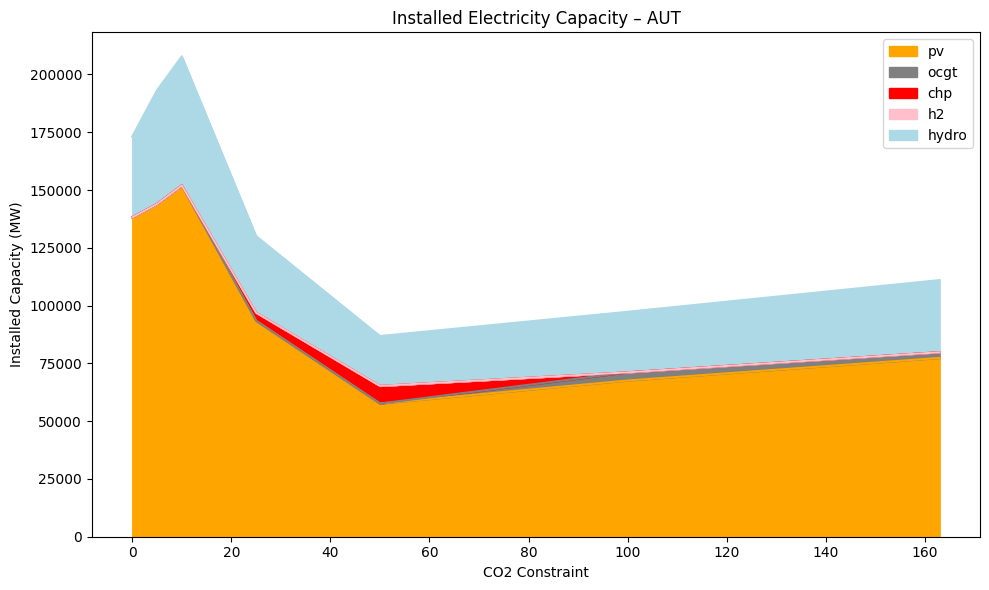

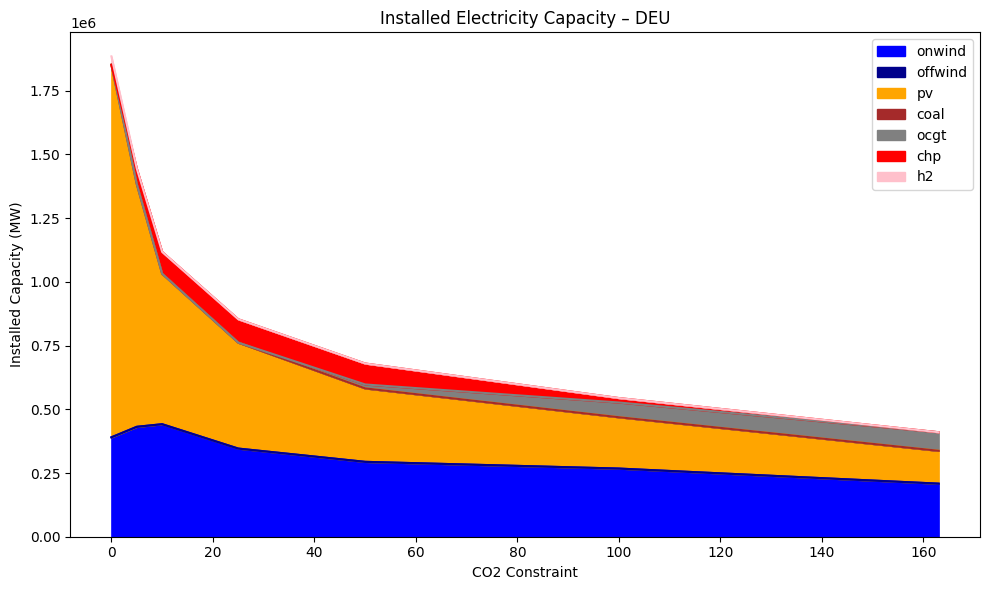

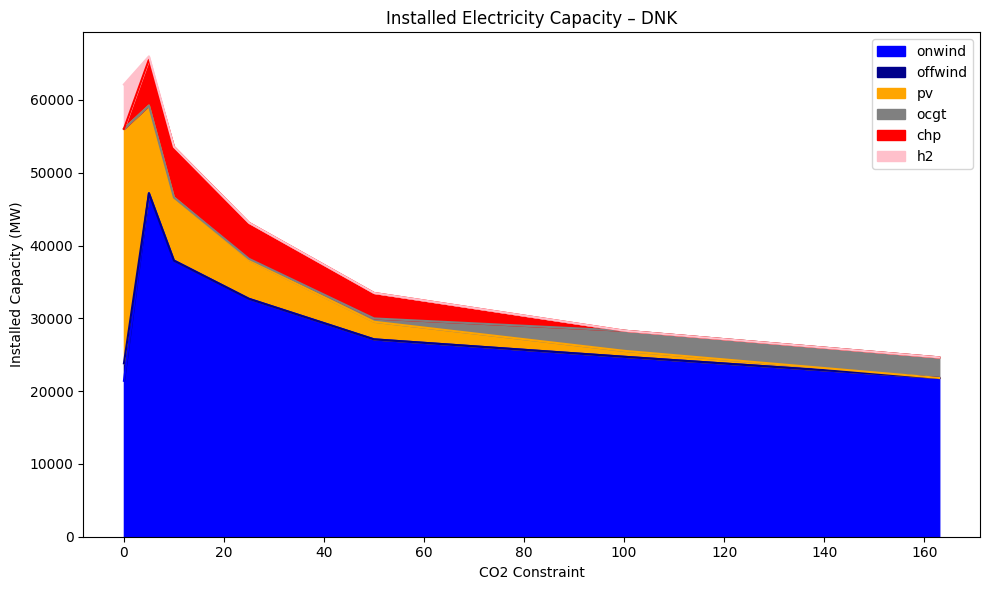

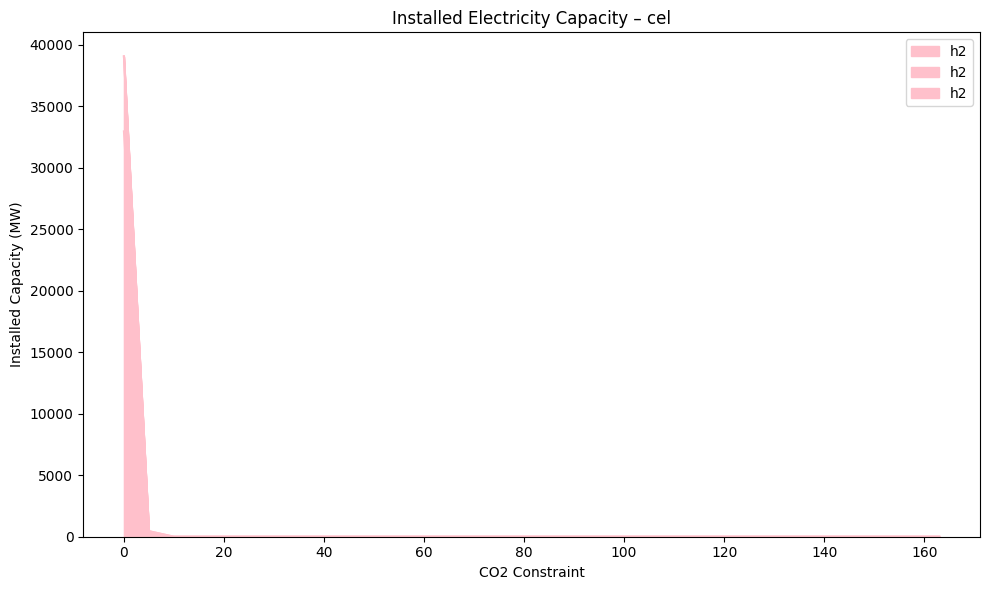

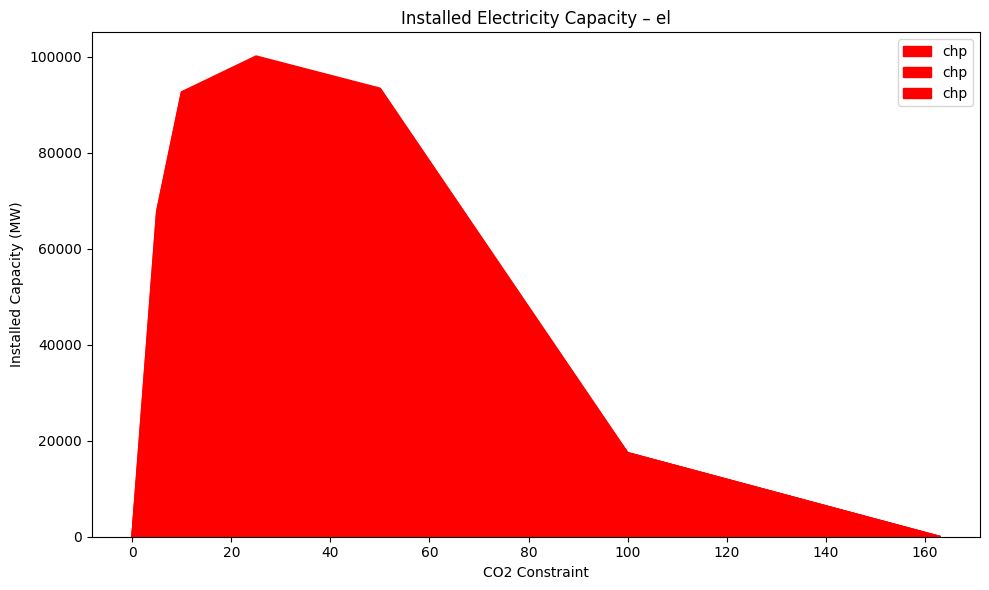

In [48]:
# Step 1: Define electricity generation technologies
electricity_techs = ["onwind", "offwind", "pv", "coal", "ocgt", "chp_el", "h2_cell", "hydro"]

# Step 2: Define fixed colors for technologies
tech_colors = {
    "onwind": "blue",
    "offwind": "darkblue",
    "pv": "orange",
    "coal": "brown",
    "ocgt": "grey",
    "chp": "red",
    "h2": "pink",
    "hydro": "lightblue",
}

# Step 3: Find all MW columns related to electricity generation
capacity_cols = [col for col in results.columns 
                 if col.endswith("MW") and any(col.startswith(tech) for tech in electricity_techs)]

# Step 4: Extract list of countries from column names
countries = sorted(set(col.split('_')[1][:3] for col in capacity_cols))

# Step 5: Plot installed capacity per country
for country in countries:
    country_cols = [col for col in capacity_cols if f"_{country}" in col]
    df_country = results[country_cols].copy()
    df_country.columns = [col.split('_')[0] for col in country_cols]  # Simplify column names
    df_country.index.name = "CO2 Constraint"

    # Clip negative values (just in case)
    df_country_clipped = df_country.clip(lower=0)

    # Plot
    df_country_clipped.plot.area(
        stacked=True,
        title=f"Installed Electricity Capacity – {country}",
        ylabel="Installed Capacity (MW)",
        xlabel="CO2 Constraint",
        color=[tech_colors[tech] for tech in df_country_clipped.columns],
        figsize=(10, 6)
    )
    plt.tight_layout()
    plt.show()



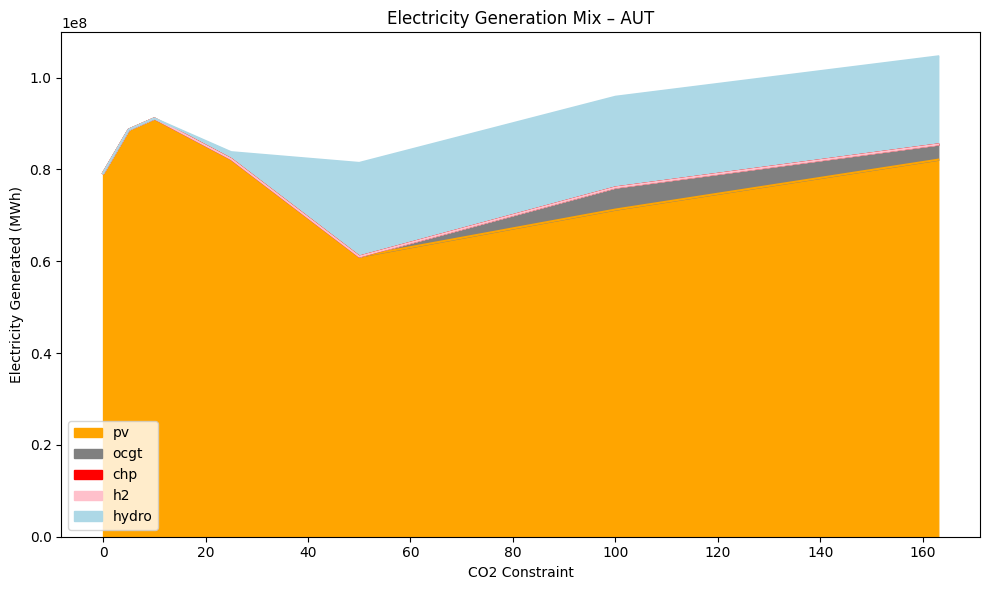

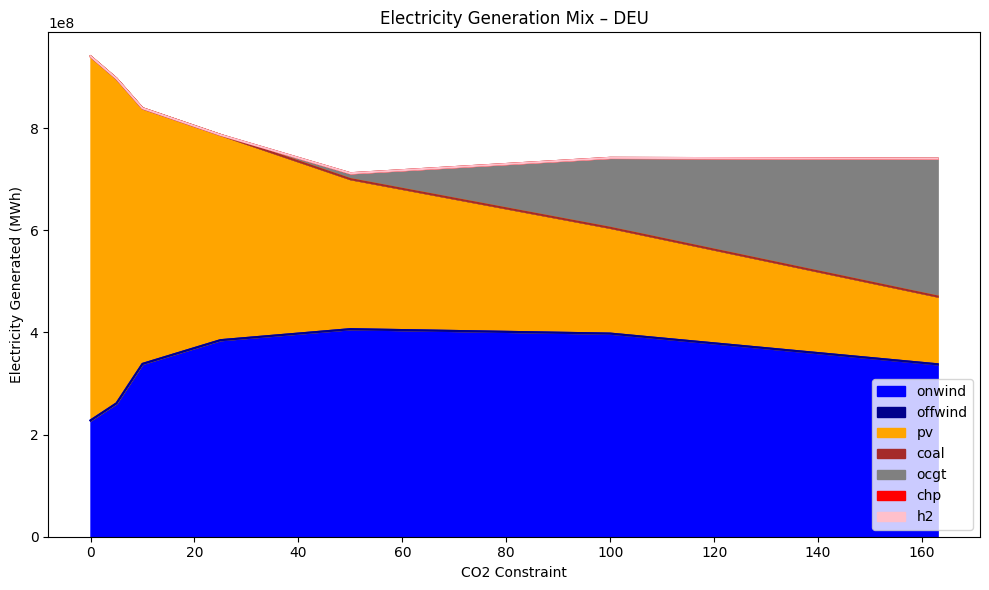

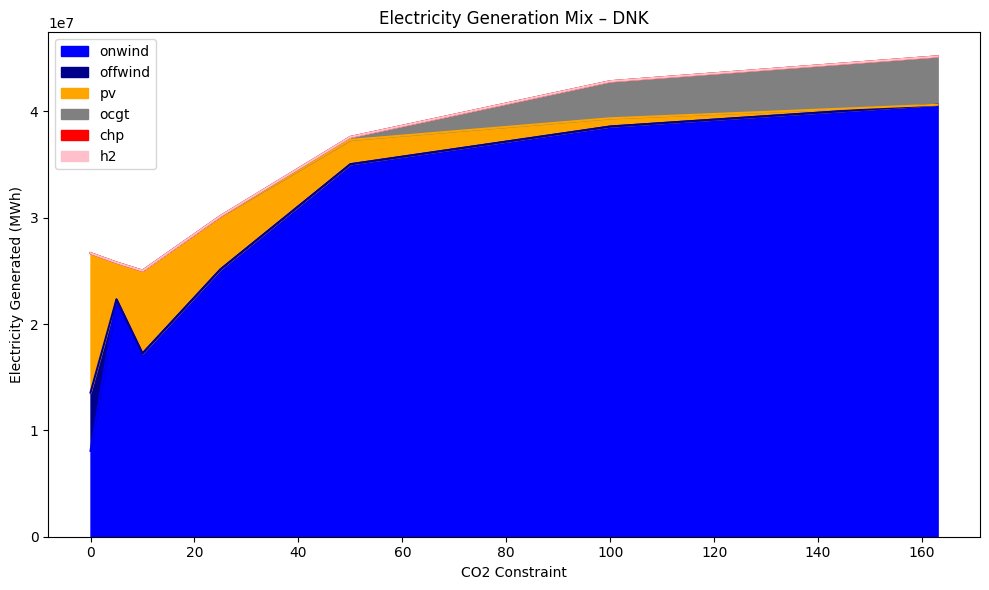

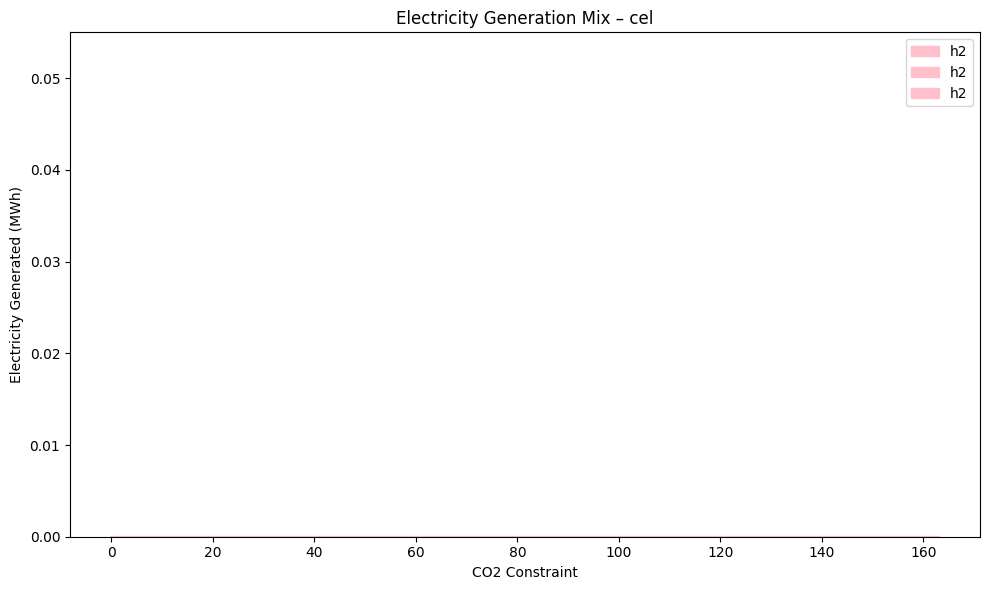

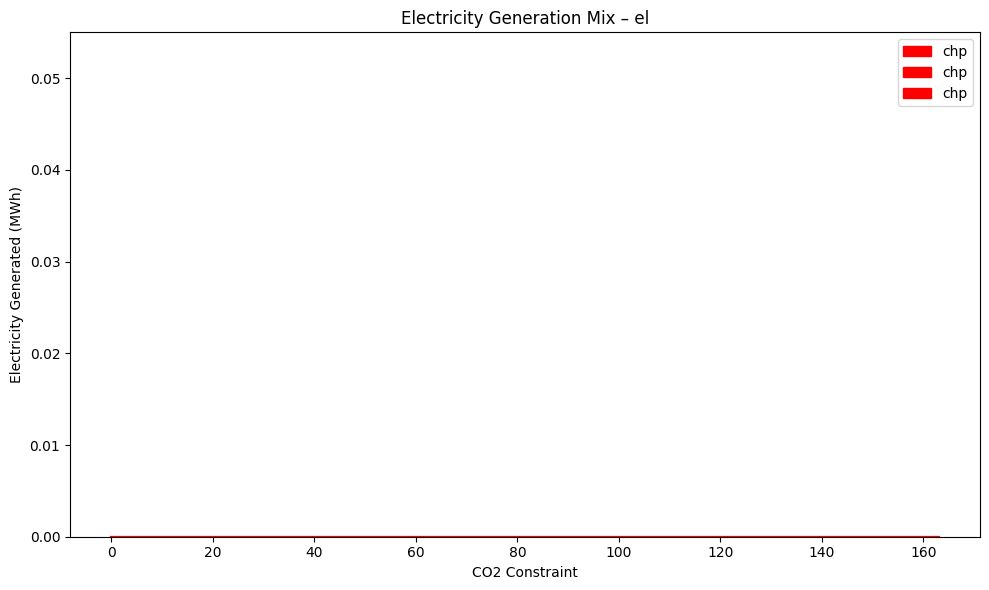

In [52]:
# Step 1: Define technologies
electricity_techs_mwh = ["onwind", "offwind", "pv", "coal", "ocgt", "chp_el", "h2_cell", "hydro"]

# Step 2: Define fixed colors for technologies
electricity_colors = {
    "onwind": "blue",
    "offwind": "darkblue",
    "pv": "orange",
    "coal": "brown",
    "ocgt": "grey",
    "chp": "red",
    "h2": "pink",
    "hydro": "lightblue",
}

# Step 3: Find MWh columns
gen_mwh_cols = [col for col in results.columns
                if col.endswith("MWh") and any(col.startswith(tech) for tech in electricity_techs_mwh)]

# Step 4: Extract countries
countries = sorted(set(col.split('_')[1][:3] for col in gen_mwh_cols))

# Step 5: Plot generation mix
for country in countries:
    country_cols = [col for col in gen_mwh_cols if f"_{country}" in col]
    df_country = results[country_cols].copy()
    df_country.columns = [col.split('_')[0] for col in country_cols]
    df_country.index.name = "CO2 Constraint"
    df_country_clipped = df_country.clip(lower=0)

    df_country_clipped.plot.area(
        stacked=True,
        title=f"Electricity Generation Mix – {country}",
        ylabel="Electricity Generated (MWh)",
        xlabel="CO2 Constraint",
        color=[electricity_colors[tech] for tech in df_country_clipped.columns],
        figsize=(10, 6)
    )
    plt.tight_layout()
    plt.show()
